# Install requirements and prepare dataset and environment

In [ ]:
!pip install gdown
!pip install sentence_transformers

In [7]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import gc
import random
import pickle
import gdown
import json
import string
from zipfile import ZipFile
from torch.nn.functional import cosine_similarity
from tabulate import tabulate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
url = "https://drive.google.com/file/d/1-4nIaIx2i0_WWks7neqRhoYaq43VdDGP/view?usp=sharing"
output = "pretrained_embeddings.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-4nIaIx2i0_WWks7neqRhoYaq43VdDGP
From (redirected): https://drive.google.com/uc?id=1-4nIaIx2i0_WWks7neqRhoYaq43VdDGP&confirm=t&uuid=de58dfbc-6dcf-4fcd-8dd2-c076b05bda49
To: /kaggle/working/pretrained_embeddings.zip
100%|██████████| 602M/602M [00:32<00:00, 18.3MB/s] 


'pretrained_embeddings.zip'

In [4]:
os.remove('pretrained_embeddings.zip')

In [4]:
url = "https://drive.google.com/file/d/1-3KQTJYaAJRc5nluH20FLhaXY2a1m0Q-/view?usp=sharing"
output = "pretrained_embeddings_common_voice.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-3KQTJYaAJRc5nluH20FLhaXY2a1m0Q-
From (redirected): https://drive.google.com/uc?id=1-3KQTJYaAJRc5nluH20FLhaXY2a1m0Q-&confirm=t&uuid=551e51b7-1c8a-4e2c-83ef-be9b652e79ed
To: /kaggle/working/pretrained_embeddings_common_voice.pkl
100%|██████████| 624M/624M [00:45<00:00, 13.8MB/s] 


'pretrained_embeddings_common_voice.pkl'

In [5]:
url = "https://drive.google.com/file/d/1lMXC-H60waEU9z9XlfOZeui9EmvMKvZR/view?usp=sharing"
output = "metadata.json"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1lMXC-H60waEU9z9XlfOZeui9EmvMKvZR
To: /kaggle/working/metadata.json
100%|██████████| 10.9M/10.9M [00:01<00:00, 10.8MB/s]


'metadata.json'

In [6]:
url = "https://drive.google.com/file/d/15cZ84V52tKQrtr4dVnGqf1p0tHxxK3jR/view?usp=sharing"
output = "fleurs_data.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=15cZ84V52tKQrtr4dVnGqf1p0tHxxK3jR
To: /kaggle/working/fleurs_data.pkl
100%|██████████| 41.2M/41.2M [00:04<00:00, 9.35MB/s]


'fleurs_data.pkl'

In [7]:
with ZipFile('pretrained_embeddings.zip', 'r') as zipObj:
    zipObj.extractall('pretrained_embeddings')

In [8]:
with open('metadata.json', 'r') as f:
    metadata_brown = json.load(f)

In [5]:
# open files in pretrained_embeddings
# 0 audio - 1 image - 2 text
brown_data = {}
for i in range(1, 11):
    with open(f'pretrained_embeddings/pretrained_embeddings_part{i}.pkl', 'rb') as f:
        brown_data.update(pickle.load(f))

In [6]:
len(brown_data)

54785

In [9]:
random_key = random.choice(list(metadata_brown.keys()))
print(random_key)
print(metadata_brown[random_key])

19840
{'id': 19840, 'file_path': 'dataset/part4/audios/audio_19840.wav', 'text': 'They think of it as a kind of spooky museum in which they may half see and half imagine the old splendor.', 'part_id': 4}


In [84]:
random_key = random.choice(list(brown_data.keys()))
print(random_key)
print(metadata_brown[str(random_key)])

8752
{'id': 8752, 'file_path': 'dataset/part2/audios/audio_8752.wav', 'text': 'The only other regions so blessed are the British Isles , western Europe , eastern China , southern Chile and parts of Japan , New Zealand and Tasmania.', 'part_id': 2}


In [11]:
with open(f'pretrained_embeddings_common_voice.pkl', 'rb') as f:
    common_voice_data = pickle.load(f)

In [ ]:
random_key = random.choice(list(common_voice_data['train'].keys()))
print(random_key)
common_voice_data['train'][random_key]

In [30]:
print(len(common_voice_data['train']))
print(len(common_voice_data['validation']))
print(len(common_voice_data['test']))

50000
3492
2197


In [13]:
with open(f'fleurs_data.pkl', 'rb') as f:
    fleurs_data = pickle.load(f)

In [ ]:
random_key = random.choice(list(fleurs_data['test'].keys()))
print(random_key)
fleurs_data['test'][random_key]

In [34]:
print(len(fleurs_data['train']) + len(common_voice_data['train']))
print(len(fleurs_data['validation']) + len(common_voice_data['validation']))
print(len(fleurs_data['test']) + len(common_voice_data['test']))
print(len(fleurs_data['train']) + len(common_voice_data['train']) + len(fleurs_data['validation']) + len(common_voice_data['validation']) + len(fleurs_data['test']) + len(common_voice_data['test']))

52602
3886
2844
59332


In [35]:
a = len(fleurs_data['train']) + len(common_voice_data['train']) + len(fleurs_data['validation']) + len(common_voice_data['validation']) + len(fleurs_data['test']) + len(common_voice_data['test'])
total = a + len(brown_data)
print(total)
test_len = int(total * 0.1)
train_len = int(total * 0.8) + 1
print(train_len)
print(total - train_len - test_len)
val_len = total - train_len - test_len
print(test_len)

114117
91294
11412
11411


In [36]:
train_num_brown = train_len - (len(fleurs_data['train']) + len(common_voice_data['train']))
val_num_brown = val_len - (len(fleurs_data['validation']) + len(common_voice_data['validation']))
test_num_brown = test_len - (len(fleurs_data['test']) + len(common_voice_data['test']))
print(train_num_brown, val_num_brown, test_num_brown)

38692 7526 8567


In [37]:
# now select randomly with determined seed this numbers from brown dataset
random.seed(42)

all_brown = list(set(brown_data.keys()))
train_brown = random.sample(all_brown, train_num_brown)
remaining_brown = list(set(all_brown) - set(train_brown))
val_brown = random.sample(list(set(remaining_brown) - set(train_brown)), val_num_brown)
test_brown = random.sample(list(set(all_brown) - set(train_brown) - set(val_brown)), test_num_brown)

print(len(train_brown), len(val_brown), len(test_brown))



38692 7526 8567


In [66]:
type(brown_data[train_brown[0]])

list

In [67]:
total_train = {}
total_train['audio'] = []
total_train['pure-text'] = []
for i in train_brown:
    x = brown_data[i][0]
    if x.device != 'cpu':
        x = x.cpu()
    total_train['audio'].append(x)
    total_train['pure-text'].append(metadata_brown[str(i)]['text'])
for value in common_voice_data['train'].values():
    total_train['audio'].append(value['audio_embedding'])
    total_train['pure-text'].append(value['text'])
for value in fleurs_data['train'].values():
    total_train['audio'].append(value['audio_embedding'])
    total_train['pure-text'].append(value['text'])

total_train['text'] = []
for i in train_brown:
    total_train['text'].append(torch.Tensor(brown_data[i][2]))
for value in common_voice_data['train'].values():
    total_train['text'].append(value['text_embedding'])
for value in fleurs_data['train'].values():
    total_train['text'].append(value['text_embedding'])

total_train['image'] = []
for i in train_brown:
    total_train['image'].append(brown_data[i][1])
for value in common_voice_data['train'].values():
    total_train['image'].append(value['image_embedding'])
for value in fleurs_data['train'].values():
    total_train['image'].append(value['image_embedding'])

# shuffle them together
indices = list(range(len(total_train['audio'])))
random.shuffle(indices)
total_train['audio'] = [total_train['audio'][i] for i in indices]
total_train['text'] = [total_train['text'][i] for i in indices]
total_train['image'] = [total_train['image'][i] for i in indices]
total_train['pure-text'] = [total_train['pure-text'][i] for i in indices]

print(len(total_train['audio']), len(total_train['text']), len(total_train['image']), len(total_train['pure-text']))

91294 91294 91294 91294


In [71]:
total_val = {}
total_val['audio'] = []
total_val['pure-text'] = []

for i in val_brown:
    x = brown_data[i][0]
    if x.device != 'cpu':
        x = x.cpu()
    total_val['audio'].append(x)
    total_val['pure-text'].append(metadata_brown[str(i)]['text'])
for value in common_voice_data['validation'].values():
    total_val['audio'].append(value['audio_embedding'])
    total_val['pure-text'].append(value['text'])
for value in fleurs_data['validation'].values():
    total_val['audio'].append(value['audio_embedding'])
    total_val['pure-text'].append(value['text'])
total_val['text'] = []
for i in val_brown:
    total_val['text'].append(torch.Tensor(brown_data[i][2]))
for value in common_voice_data['validation'].values():
    total_val['text'].append(value['text_embedding'])
for value in fleurs_data['validation'].values():
    total_val['text'].append(value['text_embedding'])

total_val['image'] = []
for i in val_brown:
    total_val['image'].append(brown_data[i][1])
for value in common_voice_data['validation'].values():
    total_val['image'].append(value['image_embedding'])
for value in fleurs_data['validation'].values():
    total_val['image'].append(value['image_embedding'])
    
# shuffle them together
indices = list(range(len(total_val['audio'])))
random.shuffle(indices)
total_val['audio'] = [total_val['audio'][i] for i in indices]
total_val['text'] = [total_val['text'][i] for i in indices]
total_val['image'] = [total_val['image'][i] for i in indices]
total_val['pure-text'] = [total_val['pure-text'][i] for i in indices]


print(len(total_val['audio']), len(total_val['text']), len(total_val['image']), len(total_val['pure-text']))

11412 11412 11412 11412


In [72]:
gc.collect()

13031

In [73]:
total_test = {}
total_test['audio'] = []
total_test['pure-text'] = []
for i in test_brown:
    if type(brown_data[i][0]) == np.ndarray:
        print(type(brown_data[i][0]))
        print('audio - brown')
    x = brown_data[i][0]
    if x.device != 'cpu':
        x = x.cpu()
    total_test['audio'].append(x)
    total_test['pure-text'].append(metadata_brown[str(i)]['text'])
    # print(brown_data[i][0].device)
    # print('audio - brown')
for value in common_voice_data['test'].values():
    if type(value['audio_embedding']) == np.ndarray:
        print(type(value['audio_embedding']))
        print('audio - common_voice')
    total_test['audio'].append(value['audio_embedding'])
    total_test['pure-text'].append(value['text'])
#     print(value['audio_embedding'].device)
#     print('audio - common_voice')
for value in fleurs_data['test'].values():
    if type(value['audio_embedding']) == np.ndarray:
        print(type(value['audio_embedding']))
        print('audio - fleurs')
    total_test['audio'].append(value['audio_embedding'])
    total_test['pure-text'].append(value['text'])
#     print(value['audio_embedding'].device)
#     print('audio - fleurs')

total_test['text'] = []
for i in test_brown:
#     if type(brown_data[i][2]) == np.ndarray:
#         print(type(brown_data[i][2]))
#         print('text - brown')
    total_test['text'].append(torch.Tensor(brown_data[i][2]))
    x = torch.Tensor(brown_data[i][2])
#     print(x.device)
#     print('text - brown')
for value in common_voice_data['test'].values():
    if type(value['text_embedding']) == np.ndarray:
        print(type(value['text_embedding']))
        print('text - common_voice')
    total_test['text'].append(value['text_embedding'])
#     print(value['text_embedding'].device)
#     print('text - common_voice')
for value in fleurs_data['test'].values():
    if type(value['text_embedding']) == np.ndarray:
        print(type(value['text_embedding']))
        print('text - fleurs')
    total_test['text'].append(value['text_embedding'])
#     print(value['text_embedding'].device)
#     print('text - fleurs')

total_test['image'] = []
for i in test_brown:
    if type(brown_data[i][1]) == np.ndarray:
        print(type(brown_data[i][1]))
        print('image - brown')
    total_test['image'].append(brown_data[i][1])
#     print(brown_data[i][1].device)
#     print('image - brown')
for value in common_voice_data['test'].values():
    if type(value['image_embedding']) == np.ndarray:
        print(type(value['image_embedding']))
        print('image - common_voice')
    total_test['image'].append(value['image_embedding'])
#     print(value['image_embedding'].device)
#     print('image - common_voice')
    
for value in fleurs_data['test'].values():
    if type(value['image_embedding']) == np.ndarray:
        print(type(value['image_embedding']))
        print('image - fleurs')
    total_test['image'].append(value['image_embedding'])
#     print(value['image_embedding'].device)
#     print('image - fleurs')
    
# shuffle them together
indices = list(range(len(total_test['audio'])))
random.shuffle(indices)
total_test['audio'] = [total_test['audio'][i] for i in indices]
total_test['text'] = [total_test['text'][i] for i in indices]
total_test['image'] = [total_test['image'][i] for i in indices]
total_test['pure-text'] = [total_test['pure-text'][i] for i in indices]

print(len(total_test['audio']), len(total_test['text']), len(total_test['image']), len(total_test['pure-text']))

11411 11411 11411 11411


In [74]:
total_dataset = {}
total_dataset['train'] = total_train
total_dataset['validation'] = total_val
total_dataset['test'] = total_test

with open('total_dataset_v1_with_text.pkl', 'wb') as f:
    pickle.dump(total_dataset, f)


In [4]:
# with open('total_dataset.pkl', 'rb') as f:
#     total_dataset = pickle.load(f)

In [75]:
len_train = len(total_dataset['train']['audio'])
len_val = len(total_dataset['validation']['audio'])
len_test = len(total_dataset['test']['audio'])

total_audio_embeddings = total_dataset['train']['audio'] + total_dataset['validation']['audio'] + total_dataset['test']['audio']
total_text_embeddings = total_dataset['train']['text'] + total_dataset['validation']['text'] + total_dataset['test']['text']
total_image_embeddings = total_dataset['train']['image'] + total_dataset['validation']['image'] + total_dataset['test']['image']

total_audio_embeddings = torch.stack(total_audio_embeddings)
total_text_embeddings = torch.stack(total_text_embeddings)
total_image_embeddings = torch.stack(total_image_embeddings)

# normalizer each embedding tensor
print(total_image_embeddings.shape)
total_audio_embeddings = F.normalize(total_audio_embeddings, dim=1)
total_text_embeddings = F.normalize(total_text_embeddings, dim=1)
total_image_embeddings = F.normalize(total_image_embeddings, dim=1)

# turn it back to lists and split it
# total_audio_embeddings = total_audio_embeddings.tolist()
# total_text_embeddings = total_text_embeddings.tolist()
# total_image_embeddings = total_image_embeddings.tolist()

audio_embeddings_train = total_audio_embeddings[:len_train]
audio_embeddings_val = total_audio_embeddings[len_train:len_train+len_val]
audio_embeddings_test = total_audio_embeddings[len_train+len_val:]



text_embeddings_train = total_text_embeddings[:len_train]
text_embeddings_val = total_text_embeddings[len_train:len_train+len_val]
text_embeddings_test = total_text_embeddings[len_train+len_val:]

image_embeddings_train = total_image_embeddings[:len_train]
image_embeddings_val = total_image_embeddings[len_train:len_train+len_val]
image_embeddings_test = total_image_embeddings[len_train+len_val:]

# with open('image_dataset_normalized.pkl', 'wb') as f:
#     pickle.dump((image_embeddings_train, image_embeddings_val, image_embeddings_test), f)

torch.Size([114117, 1000])


In [76]:
total_dataset_v2 = {
    'train': {
        'audio': audio_embeddings_train,
        'image': image_embeddings_train,
        'text': total_dataset['train']['text'],
        'pure-text': total_dataset['train']['pure-text']
    },
    'validation': {
        'audio': audio_embeddings_val,
        'image': image_embeddings_val,
        'text': total_dataset['validation']['text'],
        'pure-text': total_dataset['validation']['pure-text']
    },
    'test': {
        'audio': audio_embeddings_test,
        'image': image_embeddings_test,
        'text': total_dataset['test']['text'],
        'pure-text': total_dataset['test']['pure-text']
    }
}

In [77]:
# save the dataset
with open('total_dataset_v2_with_text.pkl', 'wb') as f:
    pickle.dump(total_dataset_v2, f)

In [102]:
with open('total_dataset_v2_with_text.pkl', 'rb') as f:
    total_dataset = pickle.load(f)

In [7]:
# converts list of tensors to tensor
len_train = len(total_dataset['train']['audio'])
len_val = len(total_dataset['validation']['audio'])
len_test = len(total_dataset['test']['audio'])

del total_text_embeddings
del text_embeddings_train
del text_embeddings_val
del text_embeddings_test

# total_audio_embeddings = total_dataset['train']['audio'] + total_dataset['validation']['audio'] + total_dataset['test']['audio']
# total_text_embeddings = total_dataset['train']['text'] + total_dataset['validation']['text'] + total_dataset['test']['text']
total_image_embeddings = total_dataset['train']['image'] + total_dataset['validation']['image'] + total_dataset['test']['image']

# total_audio_embeddings = torch.stack(total_audio_embeddings)
# total_text_embeddings = torch.stack(total_text_embeddings)
total_image_embeddings = torch.stack(total_image_embeddings)

# normalizer each embedding tensor
print(total_image_embeddings.shape)
# total_audio_embeddings = F.normalize(total_audio_embeddings, dim=1)
# total_text_embeddings = F.normalize(total_text_embeddings, dim=1)
total_image_embeddings = F.normalize(total_image_embeddings, dim=1)

# turn it back to lists and split it
# total_audio_embeddings = total_audio_embeddings.tolist()
# total_text_embeddings = total_text_embeddings.tolist()
# total_image_embeddings = total_image_embeddings.tolist()

# audio_embeddings_train = total_audio_embeddings[:len_train]
# audio_embeddings_val = total_audio_embeddings[len_train:len_train+len_val]
# audio_embeddings_test = total_audio_embeddings[len_train+len_val:]



# text_embeddings_train = total_text_embeddings[:len_train]
# text_embeddings_val = total_text_embeddings[len_train:len_train+len_val]
# text_embeddings_test = total_text_embeddings[len_train+len_val:]

image_embeddings_train = total_image_embeddings[:len_train]
image_embeddings_val = total_image_embeddings[len_train:len_train+len_val]
image_embeddings_test = total_image_embeddings[len_train+len_val:]

with open('image_dataset_normalized.pkl', 'wb') as f:
    pickle.dump((image_embeddings_train, image_embeddings_val, image_embeddings_test), f)

del total_image_embeddings
del image_embeddings_train
del image_embeddings_val
del image_embeddings_test
    
# total_dataset_v2 = {
#     'train': {
#         'audio': audio_embeddings_train,
#         'text': text_embeddings_train,
#         'image': image_embeddings_train,
#     },
#     'validation': {
#         'audio': audio_embeddings_val,
#         'text': text_embeddings_val,
#         'image': image_embeddings_val,
#     },
#     'test': {
#         'audio': audio_embeddings_test,
#         'text': text_embeddings_test,
#         'image': image_embeddings_test,
#     }
# }

torch.Size([114117, 1000])


In [6]:
len(image_embeddings_train)

91294

In [8]:
len(image_embeddings_train[0])

1000

In [9]:
with open('image_dataset_normalized.pkl', 'rb') as f:
    image_embeddings_train, image_embeddings_val, image_embeddings_test = pickle.load(f)
image_embeddings_train = [torch.Tensor(i) for i in image_embeddings_train]
image_embeddings_val = [torch.Tensor(i) for i in image_embeddings_val]
image_embeddings_test = [torch.Tensor(i) for i in image_embeddings_test]

gc.collect()

with open('text_dataset_normalized.pkl', 'rb') as f:
    text_embeddings_train, text_embeddings_val, text_embeddings_test = pickle.load(f)
text_embeddings_train = [torch.Tensor(i) for i in text_embeddings_train]
text_embeddings_val = [torch.Tensor(i) for i in text_embeddings_val]
text_embeddings_test = [torch.Tensor(i) for i in text_embeddings_test]

gc.collect()
    
with open('audio_dataset_normalized.pkl', 'rb') as f:
    audio_embeddings_train, audio_embeddings_val, audio_embeddings_test = pickle.load(f)
audio_embeddings_train = [torch.Tensor(i) for i in audio_embeddings_train]
audio_embeddings_val = [torch.Tensor(i) for i in audio_embeddings_val]
audio_embeddings_test = [torch.Tensor(i) for i in audio_embeddings_test]

gc.collect()
    
total_dataset_v2 = {
    'train': {
        'audio': audio_embeddings_train,
        'text': text_embeddings_train,
        'image': image_embeddings_train,
    },
    'validation': {
        'audio': audio_embeddings_val,
        'text': text_embeddings_val,
        'image': image_embeddings_val,
    },
    'test': {
        'audio': audio_embeddings_test,
        'text': text_embeddings_test,
        'image': image_embeddings_test,
    }
}

In [10]:
# save the dataset
with open('total_dataset_v2.pkl', 'wb') as f:
    pickle.dump(total_dataset_v2, f)

In [43]:
with open('total_dataset_v2.pkl', 'rb') as f:
    total_dataset = pickle.load(f)

In [21]:
with open('total_dataset_v2_with_text.pkl', 'rb') as f:
    total_dataset = pickle.load(f)

In [22]:
total_dataset['test'].keys()

dict_keys(['audio', 'image', 'text', 'pure-text'])

In [10]:
with open('metadata.json', 'r') as f:
    metadata_brown = json.load(f)

In [11]:
with open(f'pretrained_embeddings_common_voice.pkl', 'rb') as f:
    common_voice_data = pickle.load(f)

In [17]:
with open(f'fleurs_data.pkl', 'rb') as f:
    fleurs_data = pickle.load(f)

# add audio file path to the dataset

In [23]:


def find_brown_file_path(text):
    for i in metadata_brown.keys():
        data = metadata_brown[i]
        if data['text'] == text:
            return data['file_path'], data['id'], 'brown'
    return None, None, None

def find_common_voice_file_path(text, split):
    for i in common_voice_data[split].keys():
        data = common_voice_data[split][i]
        if data['text'] == text:
            return data['file_path'], data['id'], 'common_voice'
    return None, None, None

def find_fleurs_file_path(text, split):
    for i in fleurs_data[split].keys():
        data = fleurs_data[split][i]
        if data['text'] == text:
            return data['file_path'], data['id'], 'fleurs'
    return None, None, None

def find_file_path(text, split):
    file_path, id, dataset = find_brown_file_path(text)
    if file_path is None:
        file_path, id, dataset = find_common_voice_file_path(text, split)
    if file_path is None:
        file_path, id, dataset = find_fleurs_file_path(text, split)
    if file_path is None:
        print('No file path found for text: ', text)
    return file_path, id, dataset

In [32]:
#train
split = 'train'
total_dataset_with_audios_split = total_dataset[split].copy()
total_dataset_with_audios_split['audio_path'] = []
total_dataset_with_audios_split['id'] = []
total_dataset_with_audios_split['source'] = []
for i in tqdm(range(len(total_dataset_with_audios_split['pure-text']))):
    if i % 100 == 0:
        gc.collect()
    file_path, id, dataset_name = find_file_path(total_dataset_with_audios_split['pure-text'][i], split)
    total_dataset_with_audios_split['audio_path'].append(file_path)
    total_dataset_with_audios_split['id'].append(id)
    total_dataset_with_audios_split['source'].append(dataset_name)

100%|██████████| 91294/91294 [43:32<00:00, 34.94it/s]  


In [33]:
#validation
split = 'validation'
total_dataset_with_audios_split2 = total_dataset[split].copy()
total_dataset_with_audios_split2['audio_path'] = []
total_dataset_with_audios_split2['id'] = []
total_dataset_with_audios_split2['source'] = []
for i in tqdm(range(len(total_dataset_with_audios_split2['pure-text']))):
    if i % 100 == 0:
        gc.collect()
    file_path, id, dataset_name = find_file_path(total_dataset_with_audios_split2['pure-text'][i], split)
    total_dataset_with_audios_split2['audio_path'].append(file_path)
    total_dataset_with_audios_split2['id'].append(id)
    total_dataset_with_audios_split2['source'].append(dataset_name)

100%|██████████| 11412/11412 [03:10<00:00, 59.80it/s] 


In [34]:
total_dataset_v2 = {}
# save it to file
with open('total_dataset_test_with_text_audio.pkl', 'rb') as f:
    total_dataset_with_audios_test = pickle.load(f)
total_dataset_v2['test'] = total_dataset_with_audios_test
total_dataset_v2['train'] = total_dataset_with_audios_split
total_dataset_v2['validation'] = total_dataset_with_audios_split2
# save it to file
with open('total_dataset_v5.pkl', 'wb') as f:
    pickle.dump(total_dataset_v2, f)

7
7
7


In [2]:
from IPython.display import FileLink
FileLink('f.pkl')

/kaggle/working/total_dataset_v5.pkl

In [35]:
print(len(total_dataset_v2['test']['pure-text']))
print(len(total_dataset_v2['train']['pure-text']))
print(len(total_dataset_v2['validation']['pure-text']))

11411
91294
11412


In [36]:
total_dataset_v2['train'].keys()

dict_keys(['audio', 'image', 'text', 'pure-text', 'audio_path', 'id', 'source'])

In [28]:
len(total_dataset_with_audios_test['pure-text'])

11411

In [32]:
j = len(common_voice_data['test']) + total_brown_test
text = total_dataset_with_audios_test['pure-text'][j]
print(find_brown_file_path(text))
print(find_common_voice_file_path(text))
print(find_fleurs_file_path(text))

('dataset/part6/audios/audio_30022.wav', 30022)
bad text: If this be true , the possibility exists that an occlusive lesion of the bronchial arteries might cause widespread degeneration of supportive tissue similar to that seen in generalized emphysema.
None
bad text: If this be true , the possibility exists that an occlusive lesion of the bronchial arteries might cause widespread degeneration of supportive tissue similar to that seen in generalized emphysema.
None


In [34]:
# add and find filepathes and add them to this data
total_dataset_with_audios_test = total_dataset['test'].copy()
total_dataset_with_audios_test['audio_path'] = []
total_dataset_with_audios_test['id'] = []
total_dataset_with_audios_test['source'] = []
for i in tqdm(range(len(total_dataset_with_audios_test['pure-text']))):
    file_path, id, dataset_name = find_file_path(total_dataset_with_audios_test['pure-text'][i])
    total_dataset_with_audios_test['audio_path'].append(file_path)
    total_dataset_with_audios_test['id'].append(id)
    total_dataset_with_audios_test['source'].append(dataset_name)

100%|██████████| 11411/11411 [01:40<00:00, 113.76it/s]


In [20]:
!rm 'total_dataset_hubert_asr_v2.pkl'

In [35]:
# save it to file
with open('total_dataset_test_with_text_audio.pkl', 'wb') as f:
    pickle.dump(total_dataset_with_audios_test, f)

In [1]:
from IPython.display import FileLink 
FileLink('total_dataset_test_with_text_audio.pkl')

/kaggle/working/total_dataset_test_with_text_audio.pkl

# Prepare dataset for training

In [4]:
with open('total_dataset_v2_with_text.pkl', 'rb') as f:
    total_dataset = pickle.load(f)

In [5]:
class ImageMMDataSet(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset['audio'])

    def __getitem__(self, i):
        return self.dataset['text'][i], self.dataset['audio'][i], self.dataset['image'][i]

In [6]:
# text_embedding_train, text_embedding_val, audio_embedding_train, audio_embedding_val, image_embedding_train, image_embedding_val = train_test_split(selected_text_embeddings, selected_audio_embeddings, selected_image_embeddings, test_size=0.2, random_state=42)
# text_embedding_val, text_embedding_test, audio_embedding_val, audio_embedding_test, image_embedding_val, image_embedding_test = train_test_split(text_embedding_val, audio_embedding_val, image_embedding_val, test_size=0.5, random_state=42)

train_loader = DataLoader(dataset= ImageMMDataSet(total_dataset['train']), batch_size=32, shuffle=True)
val_loader = DataLoader(dataset= ImageMMDataSet(total_dataset['validation']), batch_size=16, shuffle=False)
test_loader = DataLoader(dataset= ImageMMDataSet(total_dataset['test']), batch_size=16, shuffle=False)

In [7]:
for text, audio, image in train_loader:
    print(text.shape, audio.shape, image.shape)
    print(text.requires_grad)
    print(audio.requires_grad)
    print(image.requires_grad)
    break

torch.Size([32, 768]) torch.Size([32, 768]) torch.Size([32, 1000])
False
False
False


In [8]:
total_dataset['train'].keys()

dict_keys(['audio', 'image', 'text', 'pure-text'])

# Explore Architectures & Modalities

In [13]:
class ImageTextAudioNNGating(nn.Module):
    def __init__(self, in_features_text, in_features_image):
        super(ImageTextAudioNNGating, self).__init__()
        self.image_seq = nn.Sequential(
            nn.Linear(in_features_image, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, in_features_text),
        )
        self.text_seq = nn.Sequential(
            nn.Linear(in_features_text, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, in_features_text),
        )
        
        # Input gate
        self.input_gate_text = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Sigmoid()
        )
        self.input_gate_image = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Sigmoid()
        )
        
        # Forget gate
        self.forget_gate_text = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Sigmoid()
        )
        self.forget_gate_image = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Sigmoid()
        )
        
        # Tanh function for new cell state computation
        self.tanh_text = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Tanh()
        )
        self.tanh_image = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Tanh()
        )
        
        # Weighting mechanism for final embedding computation
        self.weight = nn.Sequential(
            nn.Linear(in_features_text * 2, in_features_text * 2)
        )
        
        self.in_features_text = in_features_text

        
    def forward(self, x_text, x_image):
        x1 = self.text_seq(x_text)
        x2 = self.image_seq(x_image)
        
        # Apply input gate
        input_gate_text = self.input_gate_text(x1)
        input_gate_image = self.input_gate_image(x2)
        
        # Apply forget gate
        forget_gate_text = self.forget_gate_text(x1)
        forget_gate_image = self.forget_gate_image(x2)
        
        # Compute new cell state using tanh function
        new_cell_state_text = self.tanh_text(x1)
        new_cell_state_image = self.tanh_image(x2)
        
        # Update cell state using input and forget gates
        x1 = input_gate_text * new_cell_state_text + forget_gate_text * x1
        x2 = input_gate_image * new_cell_state_image + forget_gate_image * x2
        
        # Compute weighted average of updated cell states
        weight = torch.softmax(self.weight(torch.cat((x1, x2), dim=-1)), dim=-1)
        x = weight[:, :self.in_features_text] * x1 + weight[:, self.in_features_text:] * x2
        
        return x


In [22]:
import torch
import torch.nn as nn

class ImageTextAudioNNGating_v1(nn.Module):
    def __init__(self, in_features_text, in_features_image):
        super(ImageTextAudioNN, self).__init__()
        self.image_seq = nn.Sequential(
            nn.Linear(in_features_image, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
        self.text_seq = nn.Sequential(
            nn.Linear(in_features_text, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
        
        # Input gate
        self.input_gate_text = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Sigmoid()
        )
        self.input_gate_image = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Sigmoid()
        )
        
        # Forget gate
        self.forget_gate_text = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Sigmoid()
        )
        self.forget_gate_image = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Sigmoid()
        )
        
        # Tanh function for new cell state computation
        self.tanh_text = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Tanh()
        )
        self.tanh_image = nn.Sequential(
            nn.Linear(in_features_text, in_features_text),
            nn.Tanh()
        )
        
        # Weighting mechanism for final embedding computation
        self.weight = nn.Sequential(
            nn.Linear(in_features_text * 2, in_features_text)
        )
    
    def forward(self, x_text, x_image):
        x1 = self.text_seq(x_text)
        x2 = self.image_seq(x_image)
        
        # Apply input gate
        input_gate_text = self.input_gate_text(x1)
        input_gate_image = self.input_gate_image(x2)
        
        # Apply forget gate
        forget_gate_text = self.forget_gate_text(x1)
        forget_gate_image = self.forget_gate_image(x2)
        
        # Compute new cell state using tanh function
        new_cell_state_text = self.tanh_text(x1)
        new_cell_state_image = self.tanh_image(x2)
        
        # Update cell state using input and forget gates
        x1 = input_gate_text * new_cell_state_text + forget_gate_text * x1
        x2 = input_gate_image * new_cell_state_image + forget_gate_image * x2
        
        # Compute weighted average of updated cell states
        weight = torch.softmax(self.weight(torch.cat((x1, x2), dim=-1)), dim=-1)
        x = weight[:, :in_features_text] * x1 + weight[:, in_features_text:] * x2
        
        return x


In [22]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class ImageTextAudioNNV2(nn.Module):
    def __init__(self, in_features_text, in_features_image, nhead=8, nlayers=6, dropout=0.1):
        super(ImageTextAudioNNV2, self).__init__()
        self.image_seq = nn.Sequential(
            nn.Linear(in_features_image, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
        )
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features_text, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
        )
        
        # Transformer layer for image modality
        d_model = 576
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_model * 2, dropout)
        self.image_transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        # Transformer layer for audio modality
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_model * 2, dropout)
        self.audio_transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        self.mix_seq = nn.Sequential(
            nn.Linear(2 * d_model, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 800),
            nn.LeakyReLU(),
            nn.Linear(800, in_features_text)
        )
    
    def forward(self, x_audio, x_image):
        x1 = self.audio_seq(x_audio)
        x2 = self.image_seq(x_image)
        
        # Transformer layer for audio modality
        x1 = x1.unsqueeze(0) # add sequence dimension
        x1 = self.audio_transformer_encoder(x1)
        x1 = x1.squeeze(0) # remove sequence dimension
        
        # Transformer layer for image modality
        x2 = x2.unsqueeze(0) # add sequence dimension
        x2 = self.image_transformer_encoder(x2)
        x2 = x2.squeeze(0) # remove sequence dimension
        
        concats = torch.cat((x1, x2), dim=1)
        x = self.mix_seq(concats)
        
        x = self.fc(x)
        
        return x


In [14]:
class ImageTextAudioNN(nn.Module):
    def __init__(self, in_features_text, in_features_image):
        super(ImageTextAudioNN, self).__init__()
        self.image_seq = nn.Sequential(
            nn.Linear(in_features_image, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features_text, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
        
        self.mix_seq = nn.Sequential(
            nn.Linear(2 * in_features_text, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 800),
            nn.LeakyReLU(),
            nn.Linear(800, in_features_text),
        )
    
    def forward(self, x_audio, x_image):
        x1 = self.audio_seq(x_audio)
        x2 = self.image_seq(x_image)
        concats = torch.cat((x1, x2), dim=1)
        x = self.mix_seq(concats)
        return x

In [9]:
class TextAudioNN(nn.Module):
    def __init__(self, in_features_text):
        super(TextAudioNN, self).__init__()
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features_text, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
    
    def forward(self, x_audio):
        x1 = self.audio_seq(x_audio)
        return x1

In [10]:
class ImagetextNN(nn.Module):
    def __init__(self, in_features_text, in_features_image):
        super(ImagetextNN, self).__init__()
        self.image_seq = nn.Sequential(
            nn.Linear(in_features_image, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
       
    def forward(self, x_image):
        x2 = self.image_seq(x_image)
        return x2

In [10]:
def train_the_model(model, train_dataloader, val_dataloader, mode, num_epochs=100, learning_rate=5e-6, delta=0.6):
    criterion = nn.HuberLoss(delta=delta)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False, mode='joint'):
        eval_loss = 0
        model.eval()

        with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (text_emb, audio_emb, image_emb) in pbar:
                text_emb = text_emb.to(device)
                if mode == 'joint':
                    audio_emb = audio_emb.to(device)
                    image_emb = image_emb.to(device)
                    final_emb = model(audio_emb, image_emb) 
                elif mode == 'audio':
                    audio_emb = audio_emb.to(device)
                    final_emb = model(audio_emb)
                elif mode == 'image':
                    image_emb = image_emb.to(device)
                    final_emb = model(image_emb)              

                loss = criterion(final_emb, text_emb)

                eval_loss += loss.item()

                discription = 'Validation' if not test_mode else 'Test'
                pbar.set_description(f'{discription} Loss: {loss.item():.4f}')
        return eval_loss
    
    def train_epoch(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader, mode='joint'):
        train_loss = 0
        model.train()

        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (text_emb, audio_emb, image_emb) in pbar:
#                 if not audio_emb.requires_grad:
#                     audio_emb.requires_grad_(True)
#                 print(audio_emb.requires_grad)
#                 if not image_emb.requires_grad:
#                     image_emb.requires_grad_(True)
#                 if not text_emb.requires_grad:
#                     text_emb.requires_grad_(True)
#                 print(image_emb.requires_grad)
                    
                text_emb = text_emb.to(device)
                if mode == 'joint':
                    audio_emb = audio_emb.to(device)
                    image_emb = image_emb.to(device)
                    final_emb = model(audio_emb, image_emb) 
                elif mode == 'audio':
                    audio_emb = audio_emb.to(device)
                    final_emb = model(audio_emb)
                elif mode == 'image':
                    image_emb = image_emb.to(device)
                    final_emb = model(image_emb)              

                loss = criterion(final_emb, text_emb)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                pbar.set_description(f'Train Loss: {loss.item():.4f}')
        return train_loss
    
    def train(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, train_dataloader: torch.utils.data.DataLoader, val_dataloader: torch.utils.data.DataLoader, epochs: int, mode='joint'):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            gc.collect()
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            start_time = time()

            train_loss = train_epoch(model, criterion, optimizer, train_dataloader, mode)
            val_loss = eval_epoch(model, criterion, val_dataloader, mode=mode)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            end_time = time()
            
            print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')
            print(f"[Epoch {epoch + 1}]\t"
                f"Train Loss: {train_loss:.6f}\t"
                f"Validation Loss: {val_loss:.6f}")
        return train_losses, val_losses
    
    def plot_loss(loss, num_epochs, label):
        ls_epoch = [_ + 1 for _ in range(num_epochs)]
        plt.plot(ls_epoch, loss, color='r', label=label)
        plt.title('Loss plot')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
    
    
    train_losses, val_losses = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, mode)
    plot_loss(train_losses, num_epochs, 'train')
    plot_loss(val_losses, num_epochs, 'validation')
    return model

In [16]:
joint_model = ImageTextAudioNN(768, 1000).to(device)
audio_text_model = TextAudioNN(768).to(device)
image_text_model = ImagetextNN(768, 1000).to(device)

Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.91it/s]


Epoch 1 finished in 26.73s
[Epoch 1]	Train Loss: 1.800406	Validation Loss: 0.437015


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.09it/s]


Epoch 2 finished in 26.83s
[Epoch 2]	Train Loss: 1.684040	Validation Loss: 0.426941


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.53it/s]


Epoch 3 finished in 26.60s
[Epoch 3]	Train Loss: 1.657013	Validation Loss: 0.422248


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 265.81it/s]


Epoch 4 finished in 26.79s
[Epoch 4]	Train Loss: 1.643225	Validation Loss: 0.419619


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.47it/s]


Epoch 5 finished in 26.31s
[Epoch 5]	Train Loss: 1.634089	Validation Loss: 0.417446


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.43it/s]


Epoch 6 finished in 26.70s
[Epoch 6]	Train Loss: 1.625734	Validation Loss: 0.415619


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.61it/s]


Epoch 7 finished in 26.68s
[Epoch 7]	Train Loss: 1.619796	Validation Loss: 0.414303


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.23it/s]


Epoch 8 finished in 26.73s
[Epoch 8]	Train Loss: 1.615234	Validation Loss: 0.413186


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.32it/s]


Epoch 9 finished in 26.46s
[Epoch 9]	Train Loss: 1.611060	Validation Loss: 0.412207


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.34it/s]


Epoch 10 finished in 26.65s
[Epoch 10]	Train Loss: 1.607671	Validation Loss: 0.411289


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 246.20it/s]


Epoch 11 finished in 26.59s
[Epoch 11]	Train Loss: 1.605016	Validation Loss: 0.410709


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.68it/s]


Epoch 12 finished in 26.41s
[Epoch 12]	Train Loss: 1.601865	Validation Loss: 0.409887


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.59it/s]


Epoch 13 finished in 26.84s
[Epoch 13]	Train Loss: 1.598798	Validation Loss: 0.409141


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.86it/s]


Epoch 14 finished in 26.78s
[Epoch 14]	Train Loss: 1.596163	Validation Loss: 0.408576


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.67it/s]


Epoch 15 finished in 27.14s
[Epoch 15]	Train Loss: 1.594471	Validation Loss: 0.408187


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.14it/s]


Epoch 16 finished in 26.55s
[Epoch 16]	Train Loss: 1.592462	Validation Loss: 0.407718


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 255.55it/s]


Epoch 17 finished in 26.94s
[Epoch 17]	Train Loss: 1.590774	Validation Loss: 0.407375


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.82it/s]


Epoch 18 finished in 26.31s
[Epoch 18]	Train Loss: 1.589430	Validation Loss: 0.406897


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.75it/s]


Epoch 19 finished in 27.01s
[Epoch 19]	Train Loss: 1.588087	Validation Loss: 0.406553


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.30it/s]


Epoch 20 finished in 26.65s
[Epoch 20]	Train Loss: 1.585820	Validation Loss: 0.406036


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.67it/s]


Epoch 21 finished in 26.72s
[Epoch 21]	Train Loss: 1.584163	Validation Loss: 0.405673


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.73it/s]


Epoch 22 finished in 26.78s
[Epoch 22]	Train Loss: 1.582657	Validation Loss: 0.405255


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.61it/s]


Epoch 23 finished in 26.64s
[Epoch 23]	Train Loss: 1.580801	Validation Loss: 0.404831


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 239.35it/s]


Epoch 24 finished in 26.80s
[Epoch 24]	Train Loss: 1.579240	Validation Loss: 0.404366


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 265.80it/s]


Epoch 25 finished in 26.47s
[Epoch 25]	Train Loss: 1.577681	Validation Loss: 0.403996


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.21it/s]


Epoch 26 finished in 26.95s
[Epoch 26]	Train Loss: 1.576516	Validation Loss: 0.403746


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.65it/s]


Epoch 27 finished in 27.01s
[Epoch 27]	Train Loss: 1.575355	Validation Loss: 0.403509


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 255.72it/s]


Epoch 28 finished in 27.82s
[Epoch 28]	Train Loss: 1.574355	Validation Loss: 0.403263


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 263.68it/s]


Epoch 29 finished in 27.20s
[Epoch 29]	Train Loss: 1.573514	Validation Loss: 0.403056


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.14it/s]


Epoch 30 finished in 27.50s
[Epoch 30]	Train Loss: 1.572786	Validation Loss: 0.402858


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 237.98it/s]


Epoch 31 finished in 27.17s
[Epoch 31]	Train Loss: 1.571916	Validation Loss: 0.402611


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.84it/s]


Epoch 32 finished in 26.27s
[Epoch 32]	Train Loss: 1.570951	Validation Loss: 0.402395


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.93it/s]


Epoch 33 finished in 26.80s
[Epoch 33]	Train Loss: 1.570058	Validation Loss: 0.402215


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.14it/s]


Epoch 34 finished in 26.97s
[Epoch 34]	Train Loss: 1.569183	Validation Loss: 0.402014


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.43it/s]


Epoch 35 finished in 27.16s
[Epoch 35]	Train Loss: 1.568517	Validation Loss: 0.401922


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.04it/s]


Epoch 36 finished in 26.93s
[Epoch 36]	Train Loss: 1.567756	Validation Loss: 0.401656


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.23it/s]


Epoch 37 finished in 26.72s
[Epoch 37]	Train Loss: 1.567235	Validation Loss: 0.401525


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.32it/s]


Epoch 38 finished in 26.34s
[Epoch 38]	Train Loss: 1.566529	Validation Loss: 0.401360


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.16it/s]


Epoch 39 finished in 26.67s
[Epoch 39]	Train Loss: 1.565833	Validation Loss: 0.401235


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.88it/s]


Epoch 40 finished in 26.69s
[Epoch 40]	Train Loss: 1.565370	Validation Loss: 0.401127


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.84it/s]


Epoch 41 finished in 26.86s
[Epoch 41]	Train Loss: 1.564618	Validation Loss: 0.400911


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.87it/s]


Epoch 42 finished in 26.61s
[Epoch 42]	Train Loss: 1.563701	Validation Loss: 0.400762


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.10it/s]


Epoch 43 finished in 26.59s
[Epoch 43]	Train Loss: 1.562901	Validation Loss: 0.400483


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 243.95it/s]


Epoch 44 finished in 26.96s
[Epoch 44]	Train Loss: 1.562237	Validation Loss: 0.400361


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.93it/s]


Epoch 45 finished in 26.38s
[Epoch 45]	Train Loss: 1.561704	Validation Loss: 0.400259


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.07it/s]


Epoch 46 finished in 27.15s
[Epoch 46]	Train Loss: 1.561124	Validation Loss: 0.400127


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.52it/s]


Epoch 47 finished in 26.80s
[Epoch 47]	Train Loss: 1.560508	Validation Loss: 0.400034


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.79it/s]


Epoch 48 finished in 26.62s
[Epoch 48]	Train Loss: 1.559836	Validation Loss: 0.399724


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.04it/s]


Epoch 49 finished in 26.83s
[Epoch 49]	Train Loss: 1.559080	Validation Loss: 0.399593


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.40it/s]


Epoch 50 finished in 27.01s
[Epoch 50]	Train Loss: 1.558479	Validation Loss: 0.399492


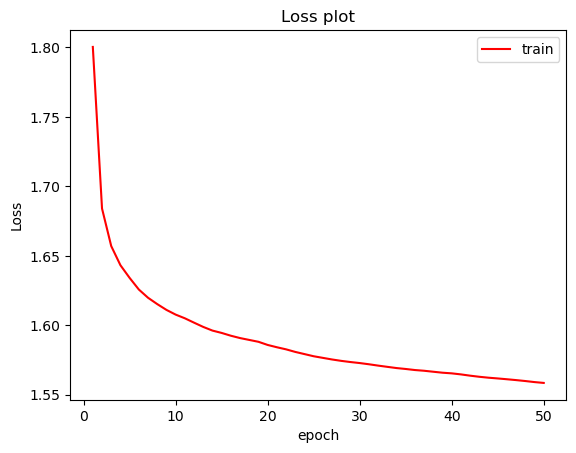

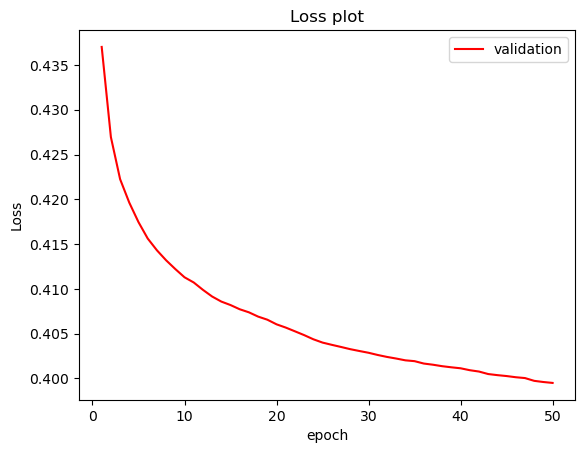

In [26]:
joint_model_gating = ImageTextAudioNNGating(768, 1000).to(device)
joint_model_gating = train_the_model(joint_model_gating, train_loader, val_loader, 'joint', num_epochs=50)
torch.save(joint_model_gating, 'gating_model.pt')

In [ ]:
joint_model_gating = torch.load('gating_model.pt')
joint_model_gating = train_the_model(joint_model_gating, train_loader, val_loader, 'joint', num_epochs=100)
torch.save(joint_model_gating, 'gating_model_v2.pt')

Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.04it/s]


Epoch 1 finished in 26.75s
[Epoch 1]	Train Loss: 1.557951	Validation Loss: 0.399352


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.67it/s]


Epoch 2 finished in 27.25s
[Epoch 2]	Train Loss: 1.557319	Validation Loss: 0.399221


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.11it/s]


Epoch 3 finished in 27.36s
[Epoch 3]	Train Loss: 1.556829	Validation Loss: 0.399114


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.98it/s]


Epoch 4 finished in 27.74s
[Epoch 4]	Train Loss: 1.556316	Validation Loss: 0.398985


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.25it/s]


Epoch 5 finished in 27.31s
[Epoch 5]	Train Loss: 1.555784	Validation Loss: 0.398856


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 281.50it/s]


Epoch 6 finished in 27.31s
[Epoch 6]	Train Loss: 1.555272	Validation Loss: 0.398837


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.61it/s]


Epoch 7 finished in 27.21s
[Epoch 7]	Train Loss: 1.554911	Validation Loss: 0.398666


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 229.48it/s]


Epoch 8 finished in 27.67s
[Epoch 8]	Train Loss: 1.554306	Validation Loss: 0.398574


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.20it/s]


Epoch 9 finished in 27.08s
[Epoch 9]	Train Loss: 1.553308	Validation Loss: 0.398273


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 265.70it/s]


Epoch 10 finished in 27.63s
[Epoch 10]	Train Loss: 1.552377	Validation Loss: 0.398135


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.60it/s]


Epoch 11 finished in 27.21s
[Epoch 11]	Train Loss: 1.551928	Validation Loss: 0.398032


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.76it/s]


Epoch 12 finished in 27.39s
[Epoch 12]	Train Loss: 1.551469	Validation Loss: 0.397912


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.56it/s]


Epoch 13 finished in 27.45s
[Epoch 13]	Train Loss: 1.551056	Validation Loss: 0.397924


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 266.07it/s]


Epoch 14 finished in 27.36s
[Epoch 14]	Train Loss: 1.550627	Validation Loss: 0.397933


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.43it/s]


Epoch 15 finished in 27.69s
[Epoch 15]	Train Loss: 1.550036	Validation Loss: 0.397650


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 257.17it/s]


Epoch 16 finished in 26.96s
[Epoch 16]	Train Loss: 1.549352	Validation Loss: 0.397527


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.83it/s]


Epoch 17 finished in 27.04s
[Epoch 17]	Train Loss: 1.548807	Validation Loss: 0.397356


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 261.36it/s]


Epoch 18 finished in 27.22s
[Epoch 18]	Train Loss: 1.548509	Validation Loss: 0.397352


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.76it/s]


Epoch 19 finished in 27.55s
[Epoch 19]	Train Loss: 1.548066	Validation Loss: 0.397278


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.32it/s]


Epoch 20 finished in 27.59s
[Epoch 20]	Train Loss: 1.547769	Validation Loss: 0.397155


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.18it/s]


Epoch 21 finished in 27.71s
[Epoch 21]	Train Loss: 1.547355	Validation Loss: 0.397114


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.00it/s]


Epoch 22 finished in 27.20s
[Epoch 22]	Train Loss: 1.547077	Validation Loss: 0.397081


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 224.79it/s]


Epoch 23 finished in 27.58s
[Epoch 23]	Train Loss: 1.546326	Validation Loss: 0.396873


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.91it/s]


Epoch 24 finished in 26.85s
[Epoch 24]	Train Loss: 1.545735	Validation Loss: 0.396745


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.32it/s]


Epoch 25 finished in 27.50s
[Epoch 25]	Train Loss: 1.545424	Validation Loss: 0.396735


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.57it/s]


Epoch 26 finished in 27.37s
[Epoch 26]	Train Loss: 1.545029	Validation Loss: 0.396689


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.45it/s]


Epoch 27 finished in 26.89s
[Epoch 27]	Train Loss: 1.544716	Validation Loss: 0.396620


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.53it/s]


Epoch 28 finished in 27.16s
[Epoch 28]	Train Loss: 1.544308	Validation Loss: 0.396480


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.96it/s]


Epoch 29 finished in 27.20s
[Epoch 29]	Train Loss: 1.544007	Validation Loss: 0.396464


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.36it/s]


Epoch 30 finished in 27.50s
[Epoch 30]	Train Loss: 1.543753	Validation Loss: 0.396390


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 262.63it/s]


Epoch 31 finished in 26.86s
[Epoch 31]	Train Loss: 1.543426	Validation Loss: 0.396413


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 280.23it/s]


Epoch 32 finished in 26.81s
[Epoch 32]	Train Loss: 1.543017	Validation Loss: 0.396178


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.03it/s]


Epoch 33 finished in 27.13s
[Epoch 33]	Train Loss: 1.542070	Validation Loss: 0.396103


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.86it/s]


Epoch 34 finished in 27.59s
[Epoch 34]	Train Loss: 1.541687	Validation Loss: 0.396035


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.06it/s]


Epoch 35 finished in 27.11s
[Epoch 35]	Train Loss: 1.541422	Validation Loss: 0.396000


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.18it/s]


Epoch 36 finished in 27.34s
[Epoch 36]	Train Loss: 1.541058	Validation Loss: 0.395983


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 279.30it/s]


Epoch 37 finished in 27.21s
[Epoch 37]	Train Loss: 1.540517	Validation Loss: 0.395883


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 227.65it/s]


Epoch 38 finished in 27.08s
[Epoch 38]	Train Loss: 1.540384	Validation Loss: 0.395816


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.25it/s]


Epoch 39 finished in 27.44s
[Epoch 39]	Train Loss: 1.539978	Validation Loss: 0.395750


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.82it/s]


Epoch 40 finished in 27.11s
[Epoch 40]	Train Loss: 1.539556	Validation Loss: 0.395631


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.08it/s]


Epoch 41 finished in 27.66s
[Epoch 41]	Train Loss: 1.539146	Validation Loss: 0.395558


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 284.94it/s]


Epoch 42 finished in 27.13s
[Epoch 42]	Train Loss: 1.538808	Validation Loss: 0.395563


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.19it/s]


Epoch 43 finished in 27.22s
[Epoch 43]	Train Loss: 1.538498	Validation Loss: 0.395534


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.03it/s]


Epoch 44 finished in 27.08s
[Epoch 44]	Train Loss: 1.538111	Validation Loss: 0.395318


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.25it/s]


Epoch 45 finished in 27.43s
[Epoch 45]	Train Loss: 1.537974	Validation Loss: 0.395324


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.77it/s]


Epoch 46 finished in 26.51s
[Epoch 46]	Train Loss: 1.537580	Validation Loss: 0.395431


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.19it/s]


Epoch 47 finished in 27.29s
[Epoch 47]	Train Loss: 1.537313	Validation Loss: 0.395324


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.63it/s]


Epoch 48 finished in 26.94s
[Epoch 48]	Train Loss: 1.536998	Validation Loss: 0.395264


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.17it/s]


Epoch 49 finished in 26.89s
[Epoch 49]	Train Loss: 1.536716	Validation Loss: 0.395153


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 282.18it/s]


Epoch 50 finished in 27.19s
[Epoch 50]	Train Loss: 1.536449	Validation Loss: 0.395152


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.12it/s]


Epoch 51 finished in 26.86s
[Epoch 51]	Train Loss: 1.536253	Validation Loss: 0.395118


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.72it/s]


Epoch 52 finished in 27.27s
[Epoch 52]	Train Loss: 1.535840	Validation Loss: 0.395040


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.56it/s]


Epoch 53 finished in 26.59s
[Epoch 53]	Train Loss: 1.535731	Validation Loss: 0.394980


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 266.63it/s]


Epoch 54 finished in 27.39s
[Epoch 54]	Train Loss: 1.535556	Validation Loss: 0.394917


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.45it/s]


Epoch 55 finished in 26.87s
[Epoch 55]	Train Loss: 1.535128	Validation Loss: 0.394920


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 281.13it/s]


Epoch 56 finished in 27.37s
[Epoch 56]	Train Loss: 1.534814	Validation Loss: 0.394877


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 282.27it/s]


Epoch 57 finished in 27.41s
[Epoch 57]	Train Loss: 1.534676	Validation Loss: 0.394854


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 281.70it/s]


Epoch 58 finished in 27.30s
[Epoch 58]	Train Loss: 1.534415	Validation Loss: 0.394885


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.58it/s]


Epoch 59 finished in 27.15s
[Epoch 59]	Train Loss: 1.534099	Validation Loss: 0.394752


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 234.28it/s]


Epoch 60 finished in 27.17s
[Epoch 60]	Train Loss: 1.533842	Validation Loss: 0.394659


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.87it/s]


Epoch 61 finished in 26.70s
[Epoch 61]	Train Loss: 1.533566	Validation Loss: 0.394661


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.10it/s]


Epoch 62 finished in 27.35s
[Epoch 62]	Train Loss: 1.533327	Validation Loss: 0.394647


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.43it/s]


Epoch 63 finished in 27.27s
[Epoch 63]	Train Loss: 1.533180	Validation Loss: 0.394695


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.10it/s]


Epoch 64 finished in 26.90s
[Epoch 64]	Train Loss: 1.532857	Validation Loss: 0.394607


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.50it/s]


Epoch 65 finished in 27.25s
[Epoch 65]	Train Loss: 1.532535	Validation Loss: 0.394547


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.13it/s]


Epoch 66 finished in 27.13s
[Epoch 66]	Train Loss: 1.532313	Validation Loss: 0.394544


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 229.91it/s]


Epoch 67 finished in 27.76s
[Epoch 67]	Train Loss: 1.531964	Validation Loss: 0.394415


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.84it/s]


Epoch 68 finished in 26.76s
[Epoch 68]	Train Loss: 1.531870	Validation Loss: 0.394534


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.23it/s]


Epoch 69 finished in 27.20s
[Epoch 69]	Train Loss: 1.531658	Validation Loss: 0.394383


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 280.84it/s]


Epoch 70 finished in 27.02s
[Epoch 70]	Train Loss: 1.531422	Validation Loss: 0.394413


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.85it/s]


Epoch 71 finished in 27.27s
[Epoch 71]	Train Loss: 1.531185	Validation Loss: 0.394252


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 279.14it/s]


Epoch 72 finished in 27.09s
[Epoch 72]	Train Loss: 1.530977	Validation Loss: 0.394287


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.17it/s]


Epoch 73 finished in 27.28s
[Epoch 73]	Train Loss: 1.530703	Validation Loss: 0.394249


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 232.34it/s]


Epoch 74 finished in 27.28s
[Epoch 74]	Train Loss: 1.530505	Validation Loss: 0.394183


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.61it/s]


Epoch 75 finished in 26.50s
[Epoch 75]	Train Loss: 1.530315	Validation Loss: 0.394184


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 280.09it/s]


Epoch 76 finished in 27.16s
[Epoch 76]	Train Loss: 1.530038	Validation Loss: 0.394094


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.34it/s]


Epoch 77 finished in 27.09s
[Epoch 77]	Train Loss: 1.529824	Validation Loss: 0.394168


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 266.40it/s]


Epoch 78 finished in 27.65s
[Epoch 78]	Train Loss: 1.529528	Validation Loss: 0.394141


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.13it/s]


Epoch 79 finished in 27.16s
[Epoch 79]	Train Loss: 1.529437	Validation Loss: 0.394049


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.13it/s]


Epoch 80 finished in 27.12s
[Epoch 80]	Train Loss: 1.529036	Validation Loss: 0.394006


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 252.47it/s]


Epoch 81 finished in 27.09s
[Epoch 81]	Train Loss: 1.528916	Validation Loss: 0.393950


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 261.35it/s]


Epoch 82 finished in 27.04s
[Epoch 82]	Train Loss: 1.528763	Validation Loss: 0.394086


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.68it/s]


Epoch 83 finished in 27.15s
[Epoch 83]	Train Loss: 1.528352	Validation Loss: 0.393945


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 266.10it/s]


Epoch 84 finished in 27.29s
[Epoch 84]	Train Loss: 1.528223	Validation Loss: 0.393995


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.70it/s]


Epoch 85 finished in 27.15s
[Epoch 85]	Train Loss: 1.528060	Validation Loss: 0.393921


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.34it/s]


Epoch 86 finished in 26.95s
[Epoch 86]	Train Loss: 1.527794	Validation Loss: 0.393899


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 266.52it/s]


Epoch 87 finished in 27.35s
[Epoch 87]	Train Loss: 1.527637	Validation Loss: 0.393830


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.34it/s]


Epoch 88 finished in 27.12s
[Epoch 88]	Train Loss: 1.527438	Validation Loss: 0.393856


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 266.67it/s]


Epoch 89 finished in 27.22s
[Epoch 89]	Train Loss: 1.527230	Validation Loss: 0.393819


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.34it/s]


Epoch 90 finished in 26.75s
[Epoch 90]	Train Loss: 1.527019	Validation Loss: 0.393744


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.23it/s]


Epoch 91 finished in 27.08s
[Epoch 91]	Train Loss: 1.526806	Validation Loss: 0.393795


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.18it/s]


Epoch 92 finished in 26.90s
[Epoch 92]	Train Loss: 1.526705	Validation Loss: 0.393716


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.79it/s]


Epoch 93 finished in 27.24s
[Epoch 93]	Train Loss: 1.526394	Validation Loss: 0.393757


Train Loss: 0.0006:  38%|███▊      | 1070/2853 [00:09<00:15, 115.90it/s]

In [ ]:
joint_model_gating = torch.load('gating_model_v2.pt')
joint_model_gating = train_the_model(joint_model_gating, train_loader, val_loader, 'joint', num_epochs=50)
torch.save(joint_model_gating, 'gating_model_v3.pt')

Train Loss: 0.0005: 100%|█████████▉| 2852/2853 [00:24<00:00, 121.29it/s]

Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 279.91it/s]


Epoch 1 finished in 27.03s
[Epoch 1]	Train Loss: 1.523788	Validation Loss: 0.393385


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.85it/s]


Epoch 2 finished in 27.11s
[Epoch 2]	Train Loss: 1.523678	Validation Loss: 0.393399


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 251.70it/s]


Epoch 3 finished in 27.06s
[Epoch 3]	Train Loss: 1.523549	Validation Loss: 0.393373


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.77it/s]


Epoch 4 finished in 26.73s
[Epoch 4]	Train Loss: 1.523585	Validation Loss: 0.393388


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.50it/s]


Epoch 5 finished in 27.09s
[Epoch 5]	Train Loss: 1.523511	Validation Loss: 0.393419


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.77it/s]


Epoch 6 finished in 27.15s
[Epoch 6]	Train Loss: 1.523453	Validation Loss: 0.393441


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.82it/s]


Epoch 7 finished in 27.12s
[Epoch 7]	Train Loss: 1.523409	Validation Loss: 0.393328


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.78it/s]


Epoch 8 finished in 26.89s
[Epoch 8]	Train Loss: 1.523315	Validation Loss: 0.393363


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.47it/s]


Epoch 9 finished in 27.31s
[Epoch 9]	Train Loss: 1.523350	Validation Loss: 0.393477


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.03it/s]


Epoch 10 finished in 27.06s
[Epoch 10]	Train Loss: 1.523279	Validation Loss: 0.393291


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 245.39it/s]


Epoch 11 finished in 26.92s
[Epoch 11]	Train Loss: 1.523236	Validation Loss: 0.393381


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 279.03it/s]


Epoch 12 finished in 26.56s
[Epoch 12]	Train Loss: 1.523043	Validation Loss: 0.393275


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.54it/s]


Epoch 13 finished in 27.15s
[Epoch 13]	Train Loss: 1.523117	Validation Loss: 0.393387


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 279.84it/s]


Epoch 14 finished in 27.19s
[Epoch 14]	Train Loss: 1.523157	Validation Loss: 0.393409


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.69it/s]


Epoch 15 finished in 27.10s
[Epoch 15]	Train Loss: 1.523027	Validation Loss: 0.393268


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.02it/s]


Epoch 16 finished in 27.01s
[Epoch 16]	Train Loss: 1.523017	Validation Loss: 0.393295


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.52it/s]


Epoch 17 finished in 27.07s
[Epoch 17]	Train Loss: 1.522970	Validation Loss: 0.393317


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 218.77it/s]


Epoch 18 finished in 27.39s
[Epoch 18]	Train Loss: 1.522828	Validation Loss: 0.393304


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 263.80it/s]


Epoch 19 finished in 26.65s
[Epoch 19]	Train Loss: 1.522736	Validation Loss: 0.393223


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.29it/s]


Epoch 20 finished in 26.92s
[Epoch 20]	Train Loss: 1.522807	Validation Loss: 0.393323


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.40it/s]


Epoch 21 finished in 27.01s
[Epoch 21]	Train Loss: 1.522792	Validation Loss: 0.393306


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.93it/s]


Epoch 22 finished in 27.01s
[Epoch 22]	Train Loss: 1.522880	Validation Loss: 0.393299


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 262.76it/s]


Epoch 23 finished in 27.67s
[Epoch 23]	Train Loss: 1.522687	Validation Loss: 0.393302


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.45it/s]


Epoch 24 finished in 27.21s
[Epoch 24]	Train Loss: 1.522724	Validation Loss: 0.393295


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 247.81it/s]


Epoch 25 finished in 27.05s
[Epoch 25]	Train Loss: 1.522653	Validation Loss: 0.393315


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.83it/s]


Epoch 26 finished in 26.54s
[Epoch 26]	Train Loss: 1.522516	Validation Loss: 0.393340


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.95it/s]


Epoch 27 finished in 27.00s
[Epoch 27]	Train Loss: 1.522525	Validation Loss: 0.393267


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.72it/s]


Epoch 28 finished in 27.24s
[Epoch 28]	Train Loss: 1.522566	Validation Loss: 0.393280


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.37it/s]


Epoch 29 finished in 27.01s
[Epoch 29]	Train Loss: 1.522307	Validation Loss: 0.393242


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.67it/s]


Epoch 30 finished in 27.54s
[Epoch 30]	Train Loss: 1.522397	Validation Loss: 0.393278


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.94it/s]


Epoch 31 finished in 26.96s
[Epoch 31]	Train Loss: 1.522409	Validation Loss: 0.393265


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 266.60it/s]


Epoch 32 finished in 27.12s
[Epoch 32]	Train Loss: 1.522317	Validation Loss: 0.393201


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.58it/s]


Epoch 33 finished in 26.90s
[Epoch 33]	Train Loss: 1.522233	Validation Loss: 0.393259


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.73it/s]


Epoch 34 finished in 27.04s
[Epoch 34]	Train Loss: 1.522157	Validation Loss: 0.393233


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.94it/s]


Epoch 35 finished in 27.16s
[Epoch 35]	Train Loss: 1.522256	Validation Loss: 0.393176


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.22it/s]


Epoch 36 finished in 26.99s
[Epoch 36]	Train Loss: 1.522246	Validation Loss: 0.393303


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.92it/s]


Epoch 37 finished in 27.26s
[Epoch 37]	Train Loss: 1.522028	Validation Loss: 0.393224


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 258.52it/s]


Epoch 38 finished in 27.22s
[Epoch 38]	Train Loss: 1.522034	Validation Loss: 0.393163


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.06it/s]


Epoch 39 finished in 26.84s
[Epoch 39]	Train Loss: 1.521992	Validation Loss: 0.393130


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 263.99it/s]


Epoch 40 finished in 26.80s
[Epoch 40]	Train Loss: 1.521953	Validation Loss: 0.393158


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.83it/s]


Epoch 41 finished in 26.79s
[Epoch 41]	Train Loss: 1.521904	Validation Loss: 0.393170


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.85it/s]


Epoch 42 finished in 27.25s
[Epoch 42]	Train Loss: 1.521841	Validation Loss: 0.393209


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 279.47it/s]


Epoch 43 finished in 27.03s
[Epoch 43]	Train Loss: 1.521899	Validation Loss: 0.393214


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.83it/s]


Epoch 44 finished in 27.01s
[Epoch 44]	Train Loss: 1.521863	Validation Loss: 0.393140


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.91it/s]


Epoch 45 finished in 27.11s
[Epoch 45]	Train Loss: 1.521735	Validation Loss: 0.393141


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.23it/s]


Epoch 46 finished in 27.05s
[Epoch 46]	Train Loss: 1.521727	Validation Loss: 0.393249


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 233.44it/s]


Epoch 47 finished in 27.10s
[Epoch 47]	Train Loss: 1.521820	Validation Loss: 0.393248


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.23it/s]


Epoch 48 finished in 26.65s
[Epoch 48]	Train Loss: 1.521670	Validation Loss: 0.393238


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.88it/s]


Epoch 49 finished in 27.10s
[Epoch 49]	Train Loss: 1.521603	Validation Loss: 0.393154


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.23it/s]


Epoch 50 finished in 26.98s
[Epoch 50]	Train Loss: 1.521626	Validation Loss: 0.393112


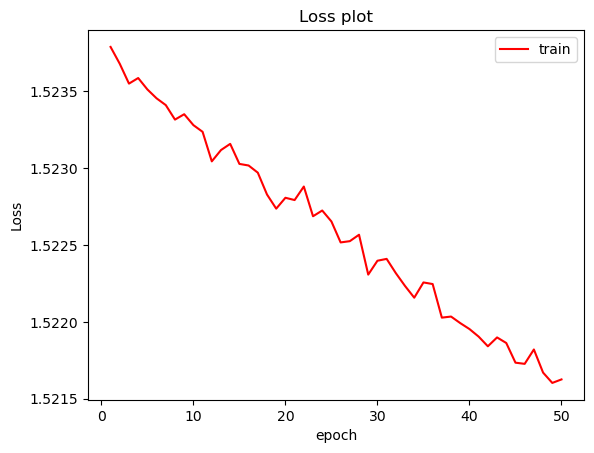

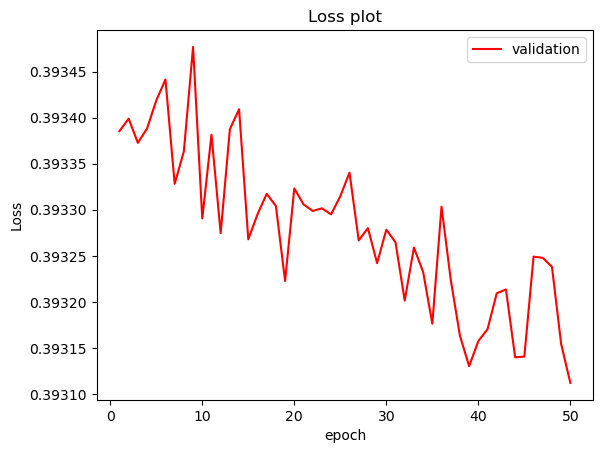

In [16]:
joint_model_gating = torch.load('gating_model_v2.pt')
joint_model_gating = train_the_model(joint_model_gating, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=1e-6)
torch.save(joint_model_gating, 'gating_model_v3_v2.pt')

Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.57it/s]


Epoch 1 finished in 30.03s
[Epoch 1]	Train Loss: 1.521449	Validation Loss: 0.393187


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.70it/s]


Epoch 2 finished in 27.43s
[Epoch 2]	Train Loss: 1.521598	Validation Loss: 0.393124


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.76it/s]


Epoch 3 finished in 27.32s
[Epoch 3]	Train Loss: 1.521493	Validation Loss: 0.393192


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.86it/s]


Epoch 4 finished in 27.31s
[Epoch 4]	Train Loss: 1.521367	Validation Loss: 0.393123


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.22it/s]


Epoch 5 finished in 27.29s
[Epoch 5]	Train Loss: 1.521414	Validation Loss: 0.393155


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.00it/s]


Epoch 6 finished in 27.35s
[Epoch 6]	Train Loss: 1.521351	Validation Loss: 0.393075


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 223.15it/s]


Epoch 7 finished in 27.59s
[Epoch 7]	Train Loss: 1.521262	Validation Loss: 0.393118


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 265.08it/s]


Epoch 8 finished in 26.91s
[Epoch 8]	Train Loss: 1.521229	Validation Loss: 0.393101


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.15it/s]


Epoch 9 finished in 27.08s
[Epoch 9]	Train Loss: 1.521300	Validation Loss: 0.393139


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.25it/s]


Epoch 10 finished in 27.27s
[Epoch 10]	Train Loss: 1.521226	Validation Loss: 0.393117


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.03it/s]


Epoch 11 finished in 27.23s
[Epoch 11]	Train Loss: 1.521234	Validation Loss: 0.393075


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.12it/s]


Epoch 12 finished in 27.45s
[Epoch 12]	Train Loss: 1.521275	Validation Loss: 0.393106


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.38it/s]


Epoch 13 finished in 27.21s
[Epoch 13]	Train Loss: 1.521044	Validation Loss: 0.393092


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.34it/s]


Epoch 14 finished in 27.28s
[Epoch 14]	Train Loss: 1.521093	Validation Loss: 0.393161


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.22it/s]


Epoch 15 finished in 27.00s
[Epoch 15]	Train Loss: 1.521075	Validation Loss: 0.393138


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.61it/s]


Epoch 16 finished in 27.20s
[Epoch 16]	Train Loss: 1.521081	Validation Loss: 0.393090


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.35it/s]


Epoch 19 finished in 27.55s
[Epoch 19]	Train Loss: 1.520793	Validation Loss: 0.393068


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.38it/s]


Epoch 20 finished in 27.28s
[Epoch 20]	Train Loss: 1.520979	Validation Loss: 0.393061


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.79it/s]


Epoch 21 finished in 27.10s
[Epoch 21]	Train Loss: 1.520827	Validation Loss: 0.393044


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 231.95it/s]


Epoch 22 finished in 27.18s
[Epoch 22]	Train Loss: 1.520742	Validation Loss: 0.393082


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.38it/s]


Epoch 23 finished in 26.88s
[Epoch 23]	Train Loss: 1.520861	Validation Loss: 0.393042


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.62it/s]


Epoch 24 finished in 27.15s
[Epoch 24]	Train Loss: 1.520846	Validation Loss: 0.393063


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.65it/s]


Epoch 25 finished in 27.13s
[Epoch 25]	Train Loss: 1.520821	Validation Loss: 0.393035


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.28it/s]


Epoch 26 finished in 27.09s
[Epoch 26]	Train Loss: 1.520704	Validation Loss: 0.393180


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.76it/s]


Epoch 27 finished in 27.17s
[Epoch 27]	Train Loss: 1.520725	Validation Loss: 0.393062


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 265.57it/s]


Epoch 28 finished in 27.10s
[Epoch 28]	Train Loss: 1.520689	Validation Loss: 0.393063


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.63it/s]


Epoch 29 finished in 27.23s
[Epoch 29]	Train Loss: 1.520527	Validation Loss: 0.393146


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.63it/s]


Epoch 30 finished in 26.73s
[Epoch 30]	Train Loss: 1.520614	Validation Loss: 0.393063


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.31it/s]


Epoch 31 finished in 27.24s
[Epoch 31]	Train Loss: 1.520567	Validation Loss: 0.393021


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.32it/s]


Epoch 32 finished in 27.24s
[Epoch 32]	Train Loss: 1.520512	Validation Loss: 0.393051


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.12it/s]


Epoch 33 finished in 27.05s
[Epoch 33]	Train Loss: 1.520483	Validation Loss: 0.393046


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.17it/s]


Epoch 34 finished in 27.26s
[Epoch 34]	Train Loss: 1.520444	Validation Loss: 0.393021


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 279.82it/s]


Epoch 35 finished in 27.03s
[Epoch 35]	Train Loss: 1.520489	Validation Loss: 0.393022


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 264.29it/s]


Epoch 36 finished in 27.18s
[Epoch 36]	Train Loss: 1.520382	Validation Loss: 0.393002


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 237.31it/s]


Epoch 37 finished in 27.22s
[Epoch 37]	Train Loss: 1.520306	Validation Loss: 0.393052


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.99it/s]


Epoch 38 finished in 26.73s
[Epoch 38]	Train Loss: 1.520245	Validation Loss: 0.393071


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.52it/s]


Epoch 39 finished in 27.08s
[Epoch 39]	Train Loss: 1.520386	Validation Loss: 0.393031


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.30it/s]


Epoch 40 finished in 27.23s
[Epoch 40]	Train Loss: 1.520319	Validation Loss: 0.392988


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.48it/s]


Epoch 41 finished in 27.01s
[Epoch 41]	Train Loss: 1.520220	Validation Loss: 0.393050


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 280.09it/s]


Epoch 42 finished in 27.08s
[Epoch 42]	Train Loss: 1.520205	Validation Loss: 0.393000


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 272.46it/s]


Epoch 43 finished in 27.20s
[Epoch 43]	Train Loss: 1.520237	Validation Loss: 0.393021


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 225.98it/s]


Epoch 44 finished in 27.25s
[Epoch 44]	Train Loss: 1.520233	Validation Loss: 0.392977


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.74it/s]


Epoch 45 finished in 26.56s
[Epoch 45]	Train Loss: 1.520115	Validation Loss: 0.393038


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.72it/s]


Epoch 46 finished in 27.22s
[Epoch 46]	Train Loss: 1.520113	Validation Loss: 0.393013


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 262.05it/s]


Epoch 47 finished in 27.17s
[Epoch 47]	Train Loss: 1.520012	Validation Loss: 0.392979


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.94it/s]


Epoch 48 finished in 27.20s
[Epoch 48]	Train Loss: 1.520095	Validation Loss: 0.393001


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 276.93it/s]


Epoch 49 finished in 27.17s
[Epoch 49]	Train Loss: 1.520013	Validation Loss: 0.393005


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 281.28it/s]


Epoch 50 finished in 27.10s
[Epoch 50]	Train Loss: 1.519981	Validation Loss: 0.393022


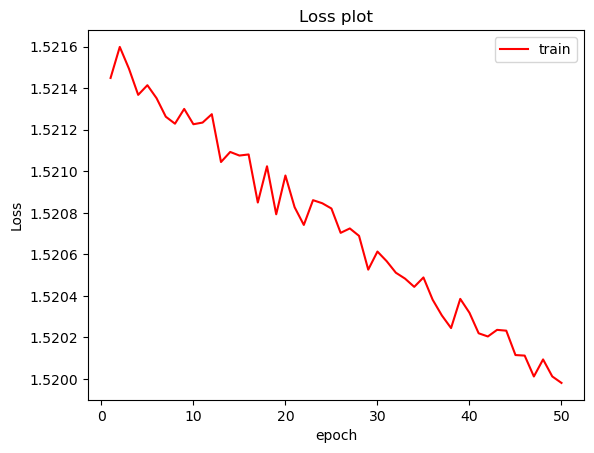

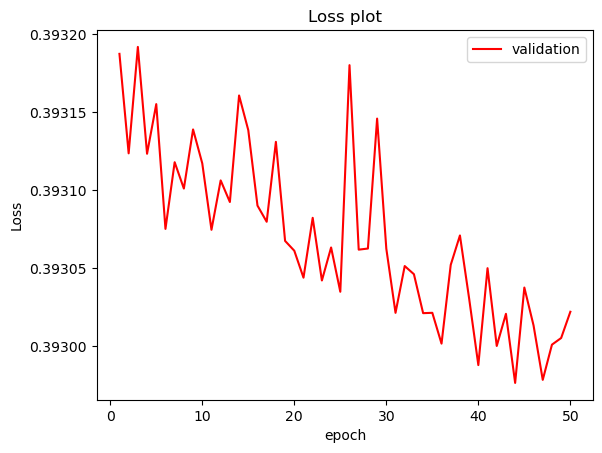

In [21]:
joint_model_gating = torch.load('gating_model_v3_v2.pt')
joint_model_gating = train_the_model(joint_model_gating, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=8e-7)
torch.save(joint_model_gating, 'gating_model_v4.pt')

In [ ]:
joint_model_gating = torch.load('gating_model_v4.pt')
joint_model_gating = train_the_model(joint_model_gating, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=4e-7)
torch.save(joint_model_gating, 'gating_model_v5.pt')

Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.03it/s]


Epoch 1 finished in 27.53s
[Epoch 1]	Train Loss: 1.519903	Validation Loss: 0.392966


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 245.08it/s]


Epoch 2 finished in 27.01s
[Epoch 2]	Train Loss: 1.519779	Validation Loss: 0.393015


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 273.01it/s]


Epoch 3 finished in 26.66s
[Epoch 3]	Train Loss: 1.519837	Validation Loss: 0.393003


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 281.80it/s]


Epoch 4 finished in 27.19s
[Epoch 4]	Train Loss: 1.519829	Validation Loss: 0.392997


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.39it/s]


Epoch 5 finished in 27.17s
[Epoch 5]	Train Loss: 1.519834	Validation Loss: 0.393040


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 267.55it/s]


Epoch 6 finished in 27.13s
[Epoch 6]	Train Loss: 1.519715	Validation Loss: 0.392955


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 269.57it/s]


Epoch 7 finished in 27.26s
[Epoch 7]	Train Loss: 1.519728	Validation Loss: 0.392977


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 268.64it/s]


Epoch 8 finished in 27.41s
[Epoch 8]	Train Loss: 1.519691	Validation Loss: 0.392941


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:03<00:00, 230.65it/s]


Epoch 9 finished in 27.22s
[Epoch 9]	Train Loss: 1.519805	Validation Loss: 0.392918


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.27it/s]


Epoch 10 finished in 26.95s
[Epoch 10]	Train Loss: 1.519625	Validation Loss: 0.392916


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 274.89it/s]


Epoch 11 finished in 27.68s
[Epoch 11]	Train Loss: 1.519634	Validation Loss: 0.392916


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 277.71it/s]


Epoch 12 finished in 27.33s
[Epoch 12]	Train Loss: 1.519641	Validation Loss: 0.392938


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 271.65it/s]


Epoch 13 finished in 27.17s
[Epoch 13]	Train Loss: 1.519648	Validation Loss: 0.392995


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 270.43it/s]


Epoch 14 finished in 27.09s
[Epoch 14]	Train Loss: 1.519643	Validation Loss: 0.392951


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 278.70it/s]


Epoch 15 finished in 27.16s
[Epoch 15]	Train Loss: 1.519556	Validation Loss: 0.392946


Train Loss: 0.0005:  59%|█████▊    | 1673/2853 [00:14<00:09, 120.52it/s]

In [15]:
joint_model_transformer = ImageTextAudioNNV2(768, 1000).to(device)
joint_model_transformer = train_the_model(joint_model_transformer, train_loader, val_loader, 'joint', num_epochs=150)
torch.save(joint_model_transformer, 'joint_model_transformer_v1.pt')

joint_model_transformer = torch.load('joint_model_transformer_v1.pt')
joint_model_transformer = train_the_model(joint_model_transformer, train_loader, val_loader, 'joint', num_epochs=100, learning_rate=1e-6)
torch.save(joint_model_transformer, 'joint_model_transformer_v2.pt')

Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.76it/s]


Epoch 1 finished in 118.54s
[Epoch 1]	Train Loss: 1.327528	Validation Loss: 0.347993


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 95.94it/s] 


Epoch 2 finished in 117.85s
[Epoch 2]	Train Loss: 1.327392	Validation Loss: 0.348109


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.76it/s]


Epoch 3 finished in 116.77s
[Epoch 3]	Train Loss: 1.327154	Validation Loss: 0.347898


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 106.86it/s]


Epoch 4 finished in 115.74s
[Epoch 4]	Train Loss: 1.327034	Validation Loss: 0.347848


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 97.08it/s] 


Epoch 5 finished in 115.34s
[Epoch 5]	Train Loss: 1.326855	Validation Loss: 0.348107


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.67it/s]


Epoch 6 finished in 117.53s
[Epoch 6]	Train Loss: 1.326764	Validation Loss: 0.347966


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.29it/s]


Epoch 7 finished in 117.72s
[Epoch 7]	Train Loss: 1.326366	Validation Loss: 0.348030


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:06<00:00, 105.33it/s]


Epoch 8 finished in 118.88s
[Epoch 8]	Train Loss: 1.326622	Validation Loss: 0.348228


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.17it/s]


Epoch 9 finished in 120.48s
[Epoch 9]	Train Loss: 1.326351	Validation Loss: 0.347850


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 94.66it/s] 


Epoch 10 finished in 117.90s
[Epoch 10]	Train Loss: 1.326223	Validation Loss: 0.347877


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.02it/s]


Epoch 11 finished in 116.36s
[Epoch 11]	Train Loss: 1.326468	Validation Loss: 0.347933


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.08it/s]


Epoch 12 finished in 117.70s
[Epoch 12]	Train Loss: 1.325891	Validation Loss: 0.347859


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 98.84it/s] 


Epoch 13 finished in 113.66s
[Epoch 13]	Train Loss: 1.325815	Validation Loss: 0.347974


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.68it/s]


Epoch 14 finished in 111.98s
[Epoch 14]	Train Loss: 1.325368	Validation Loss: 0.347750


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.06it/s]


Epoch 15 finished in 114.94s
[Epoch 15]	Train Loss: 1.325408	Validation Loss: 0.347817


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.51it/s]


Epoch 16 finished in 114.12s
[Epoch 16]	Train Loss: 1.325451	Validation Loss: 0.347851


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.53it/s]


Epoch 17 finished in 114.15s
[Epoch 17]	Train Loss: 1.325393	Validation Loss: 0.347708


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.35it/s] 


Epoch 18 finished in 113.22s
[Epoch 18]	Train Loss: 1.324983	Validation Loss: 0.347850


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 106.02it/s]


Epoch 19 finished in 112.02s
[Epoch 19]	Train Loss: 1.324887	Validation Loss: 0.347695


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.66it/s]


Epoch 20 finished in 113.71s
[Epoch 20]	Train Loss: 1.324870	Validation Loss: 0.347741


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.47it/s]


Epoch 21 finished in 114.51s
[Epoch 21]	Train Loss: 1.325139	Validation Loss: 0.347852


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.52it/s]


Epoch 22 finished in 114.99s
[Epoch 22]	Train Loss: 1.324916	Validation Loss: 0.347880


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.44it/s]


Epoch 23 finished in 115.62s
[Epoch 23]	Train Loss: 1.324724	Validation Loss: 0.347778


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 95.17it/s] 


Epoch 24 finished in 119.58s
[Epoch 24]	Train Loss: 1.324368	Validation Loss: 0.347818


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 89.73it/s] 


Epoch 25 finished in 123.83s
[Epoch 25]	Train Loss: 1.324543	Validation Loss: 0.347861


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.50it/s] 


Epoch 26 finished in 121.17s
[Epoch 26]	Train Loss: 1.324176	Validation Loss: 0.347736


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 99.09it/s] 


Epoch 27 finished in 120.72s
[Epoch 27]	Train Loss: 1.324355	Validation Loss: 0.347648


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.31it/s]


Epoch 28 finished in 120.70s
[Epoch 28]	Train Loss: 1.324076	Validation Loss: 0.347725


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.68it/s]


Epoch 29 finished in 117.93s
[Epoch 29]	Train Loss: 1.323753	Validation Loss: 0.347613


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.97it/s]


Epoch 30 finished in 115.72s
[Epoch 30]	Train Loss: 1.324110	Validation Loss: 0.347684


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.78it/s]


Epoch 31 finished in 115.74s
[Epoch 31]	Train Loss: 1.323588	Validation Loss: 0.347641


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.12it/s]


Epoch 32 finished in 115.42s
[Epoch 32]	Train Loss: 1.323511	Validation Loss: 0.347529


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.51it/s]


Epoch 33 finished in 115.26s
[Epoch 33]	Train Loss: 1.323369	Validation Loss: 0.347692


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.37it/s]


Epoch 34 finished in 115.22s
[Epoch 34]	Train Loss: 1.323493	Validation Loss: 0.347646


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.61it/s]


Epoch 35 finished in 114.82s
[Epoch 35]	Train Loss: 1.323174	Validation Loss: 0.347498


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.33it/s]


Epoch 36 finished in 115.03s
[Epoch 36]	Train Loss: 1.322781	Validation Loss: 0.347503


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.93it/s]


Epoch 37 finished in 114.57s
[Epoch 37]	Train Loss: 1.322877	Validation Loss: 0.347686


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.45it/s]


Epoch 38 finished in 115.16s
[Epoch 38]	Train Loss: 1.322724	Validation Loss: 0.347499


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.46it/s]


Epoch 39 finished in 114.48s
[Epoch 39]	Train Loss: 1.322368	Validation Loss: 0.347534


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.54it/s]


Epoch 40 finished in 115.99s
[Epoch 40]	Train Loss: 1.322415	Validation Loss: 0.347565


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.40it/s]


Epoch 41 finished in 115.27s
[Epoch 41]	Train Loss: 1.322593	Validation Loss: 0.347699


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.35it/s]


Epoch 42 finished in 114.54s
[Epoch 42]	Train Loss: 1.322107	Validation Loss: 0.347399


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.22it/s]


Epoch 43 finished in 117.01s
[Epoch 43]	Train Loss: 1.322014	Validation Loss: 0.347583


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.74it/s]


Epoch 44 finished in 116.18s
[Epoch 44]	Train Loss: 1.321757	Validation Loss: 0.347742


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.08it/s]


Epoch 45 finished in 115.33s
[Epoch 45]	Train Loss: 1.321918	Validation Loss: 0.347310


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.20it/s]


Epoch 46 finished in 115.69s
[Epoch 46]	Train Loss: 1.322021	Validation Loss: 0.347607


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.51it/s]


Epoch 47 finished in 115.89s
[Epoch 47]	Train Loss: 1.321604	Validation Loss: 0.347467


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.25it/s]


Epoch 48 finished in 114.05s
[Epoch 48]	Train Loss: 1.321281	Validation Loss: 0.347591


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.38it/s]


Epoch 49 finished in 114.69s
[Epoch 49]	Train Loss: 1.321371	Validation Loss: 0.347485


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.42it/s]


Epoch 50 finished in 115.13s
[Epoch 50]	Train Loss: 1.321289	Validation Loss: 0.347450


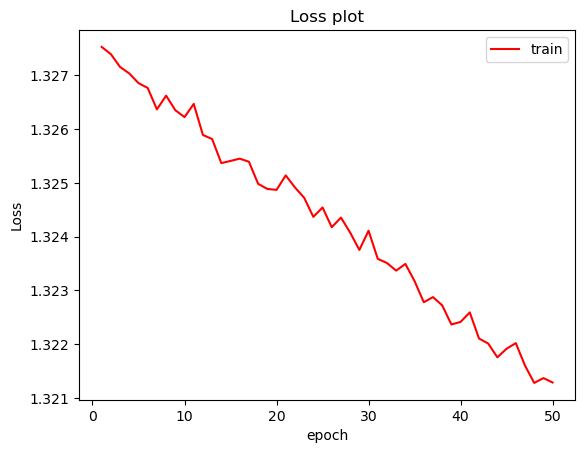

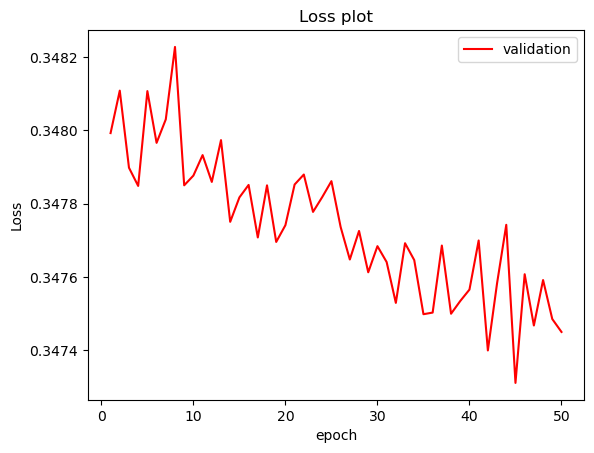

In [10]:
joint_model_transformer = torch.load('joint_model_transformer_v2.pt')
joint_model_transformer = train_the_model(joint_model_transformer, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=1e-6)
torch.save(joint_model_transformer, 'joint_model_transformer_v3.pt')

Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.93it/s]


Epoch 1 finished in 116.20s
[Epoch 1]	Train Loss: 1.320760	Validation Loss: 0.347362


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 95.77it/s] 


Epoch 2 finished in 116.33s
[Epoch 2]	Train Loss: 1.320759	Validation Loss: 0.347552


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.95it/s]


Epoch 3 finished in 115.29s
[Epoch 3]	Train Loss: 1.320632	Validation Loss: 0.347325


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.07it/s]


Epoch 4 finished in 114.96s
[Epoch 4]	Train Loss: 1.320436	Validation Loss: 0.347299


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 96.77it/s] 


Epoch 5 finished in 115.19s
[Epoch 5]	Train Loss: 1.320175	Validation Loss: 0.347584


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.25it/s]


Epoch 6 finished in 114.39s
[Epoch 6]	Train Loss: 1.320267	Validation Loss: 0.347170


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.36it/s]


Epoch 7 finished in 114.95s
[Epoch 7]	Train Loss: 1.320033	Validation Loss: 0.347257


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 99.06it/s] 


Epoch 8 finished in 115.82s
[Epoch 8]	Train Loss: 1.319982	Validation Loss: 0.347343


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.89it/s]


Epoch 9 finished in 115.04s
[Epoch 9]	Train Loss: 1.320085	Validation Loss: 0.347329


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.39it/s]


Epoch 10 finished in 115.40s
[Epoch 10]	Train Loss: 1.320032	Validation Loss: 0.347249


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.09it/s] 


Epoch 11 finished in 115.26s
[Epoch 11]	Train Loss: 1.319940	Validation Loss: 0.347314


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.64it/s]


Epoch 12 finished in 116.01s
[Epoch 12]	Train Loss: 1.319820	Validation Loss: 0.347248


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.44it/s]


Epoch 13 finished in 116.21s
[Epoch 13]	Train Loss: 1.319701	Validation Loss: 0.347409


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 95.51it/s] 


Epoch 14 finished in 115.71s
[Epoch 14]	Train Loss: 1.319687	Validation Loss: 0.347538


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.11it/s]


Epoch 15 finished in 114.98s
[Epoch 15]	Train Loss: 1.319767	Validation Loss: 0.347250


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.72it/s]


Epoch 16 finished in 114.84s
[Epoch 16]	Train Loss: 1.319169	Validation Loss: 0.347387


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.00it/s] 


Epoch 17 finished in 114.68s
[Epoch 17]	Train Loss: 1.319656	Validation Loss: 0.347621


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.05it/s]


Epoch 18 finished in 115.02s
[Epoch 18]	Train Loss: 1.319567	Validation Loss: 0.347397


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.95it/s]


Epoch 19 finished in 115.47s
[Epoch 19]	Train Loss: 1.319661	Validation Loss: 0.347397


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.07it/s] 


Epoch 20 finished in 115.29s
[Epoch 20]	Train Loss: 1.319578	Validation Loss: 0.347476


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.56it/s]


Epoch 21 finished in 114.53s
[Epoch 21]	Train Loss: 1.319108	Validation Loss: 0.347230


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 105.05it/s]


Epoch 22 finished in 115.09s
[Epoch 22]	Train Loss: 1.319184	Validation Loss: 0.347470


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.11it/s]


Epoch 23 finished in 114.98s
[Epoch 23]	Train Loss: 1.319324	Validation Loss: 0.347409


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.52it/s]


Epoch 24 finished in 115.35s
[Epoch 24]	Train Loss: 1.318966	Validation Loss: 0.347807


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.58it/s]


Epoch 25 finished in 115.27s
[Epoch 25]	Train Loss: 1.319051	Validation Loss: 0.347199


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.94it/s]


Epoch 26 finished in 113.58s
[Epoch 26]	Train Loss: 1.318944	Validation Loss: 0.347329


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.95it/s]


Epoch 27 finished in 115.09s
[Epoch 27]	Train Loss: 1.319077	Validation Loss: 0.347286


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:06<00:00, 104.04it/s]


Epoch 28 finished in 114.16s
[Epoch 28]	Train Loss: 1.318824	Validation Loss: 0.347416


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.62it/s]


Epoch 29 finished in 112.93s
[Epoch 29]	Train Loss: 1.318711	Validation Loss: 0.347389


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.60it/s]


Epoch 30 finished in 115.30s
[Epoch 30]	Train Loss: 1.318684	Validation Loss: 0.347199


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 95.61it/s] 


Epoch 31 finished in 114.61s
[Epoch 31]	Train Loss: 1.318494	Validation Loss: 0.347278


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.19it/s]


Epoch 32 finished in 116.51s
[Epoch 32]	Train Loss: 1.318901	Validation Loss: 0.347300


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.79it/s]


Epoch 33 finished in 118.67s
[Epoch 33]	Train Loss: 1.318353	Validation Loss: 0.347175


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 99.92it/s] 


Epoch 34 finished in 119.37s
[Epoch 34]	Train Loss: 1.318260	Validation Loss: 0.347154


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 93.11it/s] 


Epoch 35 finished in 119.08s
[Epoch 35]	Train Loss: 1.318132	Validation Loss: 0.347360


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 92.49it/s] 


Epoch 36 finished in 123.36s
[Epoch 36]	Train Loss: 1.318129	Validation Loss: 0.347199


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 99.80it/s] 


Epoch 37 finished in 121.13s
[Epoch 37]	Train Loss: 1.318237	Validation Loss: 0.347320


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.66it/s]


Epoch 38 finished in 119.91s
[Epoch 38]	Train Loss: 1.318121	Validation Loss: 0.347164


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.17it/s]


Epoch 39 finished in 118.44s
[Epoch 39]	Train Loss: 1.317962	Validation Loss: 0.347226


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.57it/s]


Epoch 40 finished in 118.06s
[Epoch 40]	Train Loss: 1.318205	Validation Loss: 0.347085


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.73it/s]


Epoch 41 finished in 117.06s
[Epoch 41]	Train Loss: 1.318152	Validation Loss: 0.347254


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.84it/s]


Epoch 42 finished in 115.94s
[Epoch 42]	Train Loss: 1.317422	Validation Loss: 0.347411


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:06<00:00, 104.57it/s]


Epoch 43 finished in 115.15s
[Epoch 43]	Train Loss: 1.318043	Validation Loss: 0.347215


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.12it/s]


Epoch 44 finished in 114.97s
[Epoch 44]	Train Loss: 1.317769	Validation Loss: 0.347163


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.84it/s]


Epoch 45 finished in 115.50s
[Epoch 45]	Train Loss: 1.317840	Validation Loss: 0.347034


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.07it/s]


Epoch 46 finished in 116.33s
[Epoch 46]	Train Loss: 1.317673	Validation Loss: 0.347303


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 95.84it/s] 


Epoch 47 finished in 115.77s
[Epoch 47]	Train Loss: 1.317450	Validation Loss: 0.347154


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.63it/s]


Epoch 48 finished in 117.42s
[Epoch 48]	Train Loss: 1.317408	Validation Loss: 0.347025


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.20it/s]


Epoch 49 finished in 114.28s
[Epoch 49]	Train Loss: 1.317499	Validation Loss: 0.347215


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 97.98it/s] 


Epoch 50 finished in 114.72s
[Epoch 50]	Train Loss: 1.317253	Validation Loss: 0.347226


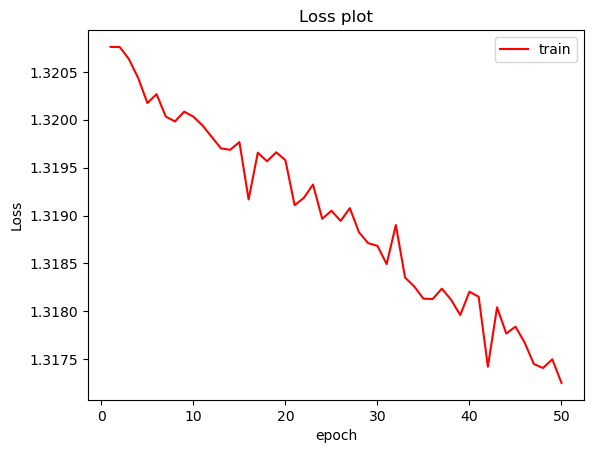

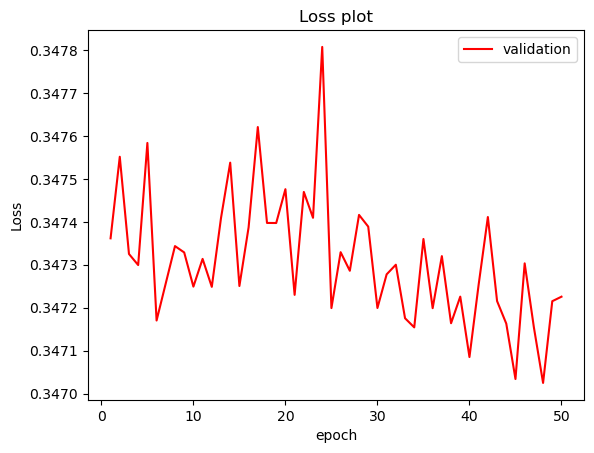

In [16]:
joint_model_transformer = torch.load('joint_model_transformer_v3.pt')
joint_model_transformer = train_the_model(joint_model_transformer, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=5e-7)
torch.save(joint_model_transformer, 'joint_model_transformer_v4.pt')

In [ ]:
joint_model_transformer = torch.load('joint_model_transformer_v4.pt')
joint_model_transformer = train_the_model(joint_model_transformer, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=1e-7)
torch.save(joint_model_transformer, 'joint_model_transformer_v5.pt')

Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.41it/s]


Epoch 1 finished in 114.48s
[Epoch 1]	Train Loss: 1.317200	Validation Loss: 0.346972


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.55it/s]


Epoch 2 finished in 115.05s
[Epoch 2]	Train Loss: 1.316740	Validation Loss: 0.347178


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 92.00it/s] 


Epoch 3 finished in 116.32s
[Epoch 3]	Train Loss: 1.317201	Validation Loss: 0.347174


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.71it/s]


Epoch 4 finished in 118.73s
[Epoch 4]	Train Loss: 1.316807	Validation Loss: 0.347173


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.45it/s]


Epoch 5 finished in 114.68s
[Epoch 5]	Train Loss: 1.316940	Validation Loss: 0.347104


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 97.39it/s] 


Epoch 6 finished in 114.95s
[Epoch 6]	Train Loss: 1.316931	Validation Loss: 0.347172


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 103.02it/s]


Epoch 7 finished in 114.35s
[Epoch 7]	Train Loss: 1.316859	Validation Loss: 0.347292


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.49it/s]


Epoch 8 finished in 114.02s
[Epoch 8]	Train Loss: 1.316823	Validation Loss: 0.347275


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.50it/s] 


Epoch 9 finished in 114.72s
[Epoch 9]	Train Loss: 1.316612	Validation Loss: 0.347322


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.85it/s]


Epoch 10 finished in 116.02s
[Epoch 10]	Train Loss: 1.316884	Validation Loss: 0.347150


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.46it/s]


Epoch 11 finished in 115.08s
[Epoch 11]	Train Loss: 1.316758	Validation Loss: 0.347123


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 96.46it/s] 


Epoch 12 finished in 114.57s
[Epoch 12]	Train Loss: 1.316773	Validation Loss: 0.347218


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.88it/s]


Epoch 13 finished in 114.11s
[Epoch 13]	Train Loss: 1.316724	Validation Loss: 0.347305


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 104.72it/s]


Epoch 14 finished in 114.64s
[Epoch 14]	Train Loss: 1.316792	Validation Loss: 0.347130


Train Loss: 0.0005:  93%|█████████▎| 2663/2853 [01:41<00:06, 27.61it/s]

Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 90.72it/s]


Epoch 1 finished in 133.30s
[Epoch 1]	Train Loss: 1.316398	Validation Loss: 0.347103


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 93.20it/s]


Epoch 2 finished in 130.98s
[Epoch 2]	Train Loss: 1.316425	Validation Loss: 0.347254


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:08<00:00, 88.97it/s]


Epoch 3 finished in 130.66s
[Epoch 3]	Train Loss: 1.316503	Validation Loss: 0.347220


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 91.76it/s]


Epoch 4 finished in 130.55s
[Epoch 4]	Train Loss: 1.316184	Validation Loss: 0.347212


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:08<00:00, 86.91it/s]


Epoch 5 finished in 133.03s
[Epoch 5]	Train Loss: 1.316099	Validation Loss: 0.346987


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 91.41it/s]


Epoch 6 finished in 131.07s
[Epoch 6]	Train Loss: 1.316423	Validation Loss: 0.347181


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 90.03it/s]


Epoch 7 finished in 132.28s
[Epoch 7]	Train Loss: 1.316091	Validation Loss: 0.347074


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 92.09it/s]


Epoch 8 finished in 129.99s
[Epoch 8]	Train Loss: 1.316212	Validation Loss: 0.346941


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 91.53it/s]


Epoch 9 finished in 130.61s
[Epoch 9]	Train Loss: 1.316160	Validation Loss: 0.347403


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 93.59it/s]


Epoch 10 finished in 131.18s
[Epoch 10]	Train Loss: 1.316202	Validation Loss: 0.347084


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:08<00:00, 84.44it/s]


Epoch 11 finished in 132.92s
[Epoch 11]	Train Loss: 1.316064	Validation Loss: 0.347159


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 92.18it/s]


Epoch 12 finished in 132.99s
[Epoch 12]	Train Loss: 1.316020	Validation Loss: 0.347312


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:08<00:00, 87.81it/s]


Epoch 13 finished in 133.13s
[Epoch 13]	Train Loss: 1.315947	Validation Loss: 0.346996


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 92.00it/s]


Epoch 14 finished in 133.60s
[Epoch 14]	Train Loss: 1.316015	Validation Loss: 0.346990


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:08<00:00, 85.29it/s]


Epoch 15 finished in 138.32s
[Epoch 15]	Train Loss: 1.316008	Validation Loss: 0.347067


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 90.18it/s]


Epoch 16 finished in 133.73s
[Epoch 16]	Train Loss: 1.316065	Validation Loss: 0.346922


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 89.97it/s]


Epoch 17 finished in 132.03s
[Epoch 17]	Train Loss: 1.315856	Validation Loss: 0.347044


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 92.48it/s]


Epoch 18 finished in 130.26s
[Epoch 18]	Train Loss: 1.315986	Validation Loss: 0.347242


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 96.62it/s] 


Epoch 19 finished in 129.36s
[Epoch 19]	Train Loss: 1.316028	Validation Loss: 0.346981


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 96.73it/s] 


Epoch 20 finished in 125.43s
[Epoch 20]	Train Loss: 1.316114	Validation Loss: 0.347189


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 99.11it/s] 


Epoch 21 finished in 121.56s
[Epoch 21]	Train Loss: 1.316216	Validation Loss: 0.347149


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.24it/s] 


Epoch 22 finished in 121.93s
[Epoch 22]	Train Loss: 1.315928	Validation Loss: 0.346987


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.28it/s] 


Epoch 23 finished in 121.90s
[Epoch 23]	Train Loss: 1.315950	Validation Loss: 0.347255


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 99.26it/s] 


Epoch 24 finished in 120.12s
[Epoch 24]	Train Loss: 1.315949	Validation Loss: 0.347022


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 90.92it/s] 


Epoch 25 finished in 123.14s
[Epoch 25]	Train Loss: 1.315684	Validation Loss: 0.347146


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:08<00:00, 89.08it/s]


Epoch 26 finished in 123.37s
[Epoch 26]	Train Loss: 1.316339	Validation Loss: 0.346944


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.62it/s]


Epoch 27 finished in 121.97s
[Epoch 27]	Train Loss: 1.315919	Validation Loss: 0.347208


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.44it/s]


Epoch 28 finished in 119.34s
[Epoch 28]	Train Loss: 1.315847	Validation Loss: 0.347097


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 97.92it/s] 


Epoch 29 finished in 118.86s
[Epoch 29]	Train Loss: 1.316032	Validation Loss: 0.347142


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.84it/s] 


Epoch 30 finished in 121.75s
[Epoch 30]	Train Loss: 1.316027	Validation Loss: 0.346973


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 97.00it/s] 


Epoch 31 finished in 121.85s
[Epoch 31]	Train Loss: 1.315734	Validation Loss: 0.347016


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 93.71it/s] 


Epoch 32 finished in 120.01s
[Epoch 32]	Train Loss: 1.316023	Validation Loss: 0.347085


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.43it/s]


Epoch 33 finished in 118.63s
[Epoch 33]	Train Loss: 1.316059	Validation Loss: 0.347006


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.25it/s]


Epoch 34 finished in 117.72s
[Epoch 34]	Train Loss: 1.315941	Validation Loss: 0.346998


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 101.49it/s]


Epoch 35 finished in 117.56s
[Epoch 35]	Train Loss: 1.315751	Validation Loss: 0.347327


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 95.89it/s] 


Epoch 36 finished in 116.85s
[Epoch 36]	Train Loss: 1.315901	Validation Loss: 0.346980


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 100.11it/s]


Epoch 37 finished in 118.28s
[Epoch 37]	Train Loss: 1.315343	Validation Loss: 0.347145


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.74it/s]


Epoch 38 finished in 118.01s
[Epoch 38]	Train Loss: 1.315850	Validation Loss: 0.347199


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:06<00:00, 102.91it/s]


Epoch 39 finished in 116.91s
[Epoch 39]	Train Loss: 1.315516	Validation Loss: 0.347290


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 101.18it/s]


Epoch 40 finished in 116.75s
[Epoch 40]	Train Loss: 1.316117	Validation Loss: 0.346994


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 97.45it/s] 


Epoch 41 finished in 123.31s
[Epoch 41]	Train Loss: 1.315774	Validation Loss: 0.347134


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:07<00:00, 96.60it/s] 


Epoch 42 finished in 122.93s
[Epoch 42]	Train Loss: 1.315864	Validation Loss: 0.347113


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 93.68it/s]


Epoch 43 finished in 123.72s
[Epoch 43]	Train Loss: 1.315535	Validation Loss: 0.346869


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 98.36it/s] 


Epoch 44 finished in 123.42s
[Epoch 44]	Train Loss: 1.315524	Validation Loss: 0.347302


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 93.95it/s]


Epoch 45 finished in 125.88s
[Epoch 45]	Train Loss: 1.315543	Validation Loss: 0.347036


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 93.48it/s]


Epoch 46 finished in 126.41s
[Epoch 46]	Train Loss: 1.315726	Validation Loss: 0.347019


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 94.44it/s]


Epoch 47 finished in 127.49s
[Epoch 47]	Train Loss: 1.315662	Validation Loss: 0.346976


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 94.43it/s]


Epoch 48 finished in 128.11s
[Epoch 48]	Train Loss: 1.315872	Validation Loss: 0.347042


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 94.41it/s]


Epoch 49 finished in 129.90s
[Epoch 49]	Train Loss: 1.315382	Validation Loss: 0.347151


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:07<00:00, 92.58it/s]


Epoch 50 finished in 129.55s
[Epoch 50]	Train Loss: 1.315976	Validation Loss: 0.347027


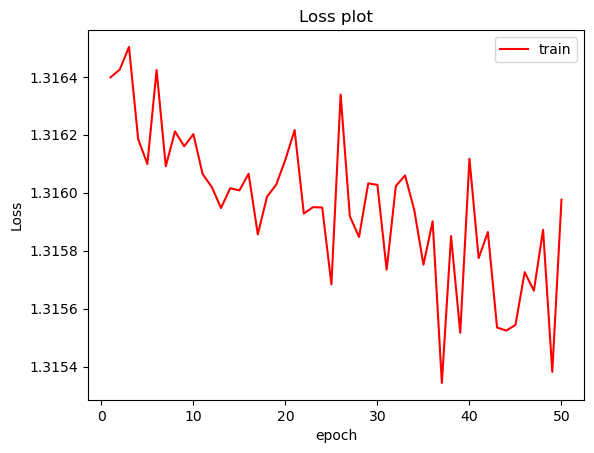

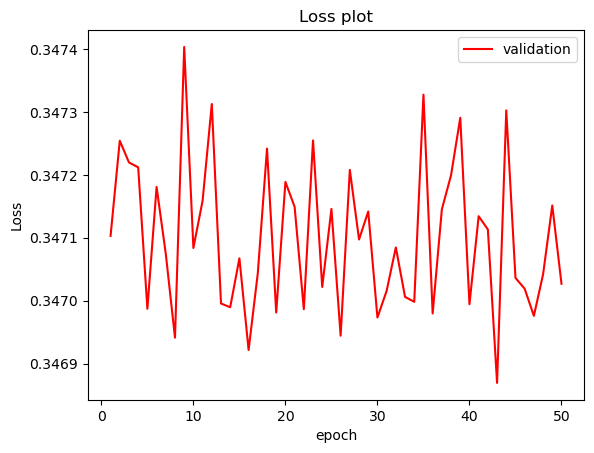

In [24]:
joint_model_transformer = torch.load('joint_model_transformer_v5.pt')
joint_model_transformer = train_the_model(joint_model_transformer, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=1e-7)
torch.save(joint_model_transformer, 'joint_model_transformer_v6.pt')

In [ ]:
joint_model_transformer = torch.load('joint_model_transformer_v6.pt')
joint_model_transformer = train_the_model(joint_model_transformer, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=1e-7)
torch.save(joint_model_transformer, 'joint_model_transformer_v7.pt')

In [ ]:
joint_model = train_the_model(joint_model, train_loader, val_loader, 'joint', num_epochs=150)
torch.save(joint_model, 'joint_model_translation.pt')

Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 288.07it/s]


Epoch 1 finished in 24.18s
[Epoch 1]	Train Loss: 4.104502	Validation Loss: 0.446610


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 279.72it/s]


Epoch 2 finished in 22.68s
[Epoch 2]	Train Loss: 1.641315	Validation Loss: 0.411437


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 275.81it/s]


Epoch 3 finished in 23.59s
[Epoch 3]	Train Loss: 1.588817	Validation Loss: 0.405077


Validation Loss: 0.0006: 100%|██████████| 714/714 [00:02<00:00, 291.24it/s]


Epoch 4 finished in 23.08s
[Epoch 4]	Train Loss: 1.558374	Validation Loss: 0.394987


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 286.02it/s]


Epoch 5 finished in 22.83s
[Epoch 5]	Train Loss: 1.536738	Validation Loss: 0.391316


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 288.23it/s]


Epoch 6 finished in 23.40s
[Epoch 6]	Train Loss: 1.525055	Validation Loss: 0.388453


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 291.58it/s]


Epoch 7 finished in 22.79s
[Epoch 7]	Train Loss: 1.515883	Validation Loss: 0.386571


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 274.68it/s]


Epoch 8 finished in 23.34s
[Epoch 8]	Train Loss: 1.508774	Validation Loss: 0.384447


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 281.58it/s]


Epoch 9 finished in 23.33s
[Epoch 9]	Train Loss: 1.502473	Validation Loss: 0.382587


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 281.50it/s]


Epoch 10 finished in 22.52s
[Epoch 10]	Train Loss: 1.496492	Validation Loss: 0.380989


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 291.32it/s]


Epoch 11 finished in 24.59s
[Epoch 11]	Train Loss: 1.491147	Validation Loss: 0.379534


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 290.17it/s]


Epoch 12 finished in 22.85s
[Epoch 12]	Train Loss: 1.485691	Validation Loss: 0.378070


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:03<00:00, 228.58it/s]


Epoch 13 finished in 23.03s
[Epoch 13]	Train Loss: 1.480495	Validation Loss: 0.376799


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 287.89it/s]


Epoch 14 finished in 23.25s
[Epoch 14]	Train Loss: 1.475546	Validation Loss: 0.375473


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.18it/s]


Epoch 15 finished in 22.79s
[Epoch 15]	Train Loss: 1.470867	Validation Loss: 0.374296


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 279.52it/s]


Epoch 16 finished in 23.85s
[Epoch 16]	Train Loss: 1.466608	Validation Loss: 0.373101


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 278.06it/s]


Epoch 17 finished in 22.46s
[Epoch 17]	Train Loss: 1.462450	Validation Loss: 0.372293


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 290.88it/s]


Epoch 18 finished in 22.40s
[Epoch 18]	Train Loss: 1.458718	Validation Loss: 0.371174


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 289.16it/s]


Epoch 19 finished in 23.90s
[Epoch 19]	Train Loss: 1.455069	Validation Loss: 0.370362


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 289.85it/s]


Epoch 20 finished in 22.80s
[Epoch 20]	Train Loss: 1.451571	Validation Loss: 0.369536


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 274.09it/s]


Epoch 21 finished in 23.36s
[Epoch 21]	Train Loss: 1.448406	Validation Loss: 0.368734


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 288.87it/s]


Epoch 22 finished in 23.14s
[Epoch 22]	Train Loss: 1.445422	Validation Loss: 0.367914


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 287.20it/s]


Epoch 23 finished in 22.94s
[Epoch 23]	Train Loss: 1.442489	Validation Loss: 0.367198


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 282.53it/s]


Epoch 24 finished in 23.83s
[Epoch 24]	Train Loss: 1.439711	Validation Loss: 0.366580


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 286.06it/s]


Epoch 25 finished in 22.32s
[Epoch 25]	Train Loss: 1.437134	Validation Loss: 0.365850


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 277.13it/s]


Epoch 26 finished in 23.40s
[Epoch 26]	Train Loss: 1.434525	Validation Loss: 0.365192


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 289.23it/s]


Epoch 27 finished in 23.26s
[Epoch 27]	Train Loss: 1.432011	Validation Loss: 0.364724


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 270.65it/s]


Epoch 28 finished in 22.89s
[Epoch 28]	Train Loss: 1.429727	Validation Loss: 0.363985


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 282.81it/s]


Epoch 29 finished in 23.64s
[Epoch 29]	Train Loss: 1.427533	Validation Loss: 0.363653


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 286.17it/s]


Epoch 30 finished in 22.96s
[Epoch 30]	Train Loss: 1.425395	Validation Loss: 0.362866


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 281.10it/s]


Epoch 31 finished in 23.10s
[Epoch 31]	Train Loss: 1.423251	Validation Loss: 0.362590


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 245.66it/s]


Epoch 32 finished in 23.52s
[Epoch 32]	Train Loss: 1.421308	Validation Loss: 0.362152


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 280.18it/s]


Epoch 33 finished in 22.47s
[Epoch 33]	Train Loss: 1.419232	Validation Loss: 0.361701


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 276.99it/s]


Epoch 34 finished in 23.88s
[Epoch 34]	Train Loss: 1.417529	Validation Loss: 0.361205


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 288.68it/s]


Epoch 35 finished in 22.89s
[Epoch 35]	Train Loss: 1.415715	Validation Loss: 0.360768


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 269.13it/s]


Epoch 36 finished in 22.71s
[Epoch 36]	Train Loss: 1.413846	Validation Loss: 0.360291


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 296.25it/s]


Epoch 37 finished in 23.25s
[Epoch 37]	Train Loss: 1.412166	Validation Loss: 0.359983


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.22it/s]


Epoch 38 finished in 22.62s
[Epoch 38]	Train Loss: 1.410569	Validation Loss: 0.359561


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 276.15it/s]


Epoch 39 finished in 23.83s
[Epoch 39]	Train Loss: 1.408973	Validation Loss: 0.359420


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 285.82it/s]


Epoch 40 finished in 22.51s
[Epoch 40]	Train Loss: 1.407344	Validation Loss: 0.359108


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 293.16it/s]


Epoch 41 finished in 22.75s
[Epoch 41]	Train Loss: 1.405823	Validation Loss: 0.358396


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 280.48it/s]


Epoch 42 finished in 23.76s
[Epoch 42]	Train Loss: 1.404209	Validation Loss: 0.358363


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 288.54it/s]


Epoch 43 finished in 22.72s
[Epoch 43]	Train Loss: 1.402857	Validation Loss: 0.358001


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 276.64it/s]


Epoch 44 finished in 23.20s
[Epoch 44]	Train Loss: 1.401115	Validation Loss: 0.357563


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 288.03it/s]


Epoch 45 finished in 23.10s
[Epoch 45]	Train Loss: 1.399978	Validation Loss: 0.357286


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 285.62it/s]


Epoch 46 finished in 22.82s
[Epoch 46]	Train Loss: 1.398658	Validation Loss: 0.357043


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 248.13it/s]


Epoch 47 finished in 23.96s
[Epoch 47]	Train Loss: 1.397125	Validation Loss: 0.356612


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 287.25it/s]


Epoch 48 finished in 22.49s
[Epoch 48]	Train Loss: 1.395852	Validation Loss: 0.356307


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 281.43it/s]


Epoch 49 finished in 23.37s
[Epoch 49]	Train Loss: 1.394307	Validation Loss: 0.356074


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 288.15it/s]


Epoch 50 finished in 23.13s
[Epoch 50]	Train Loss: 1.393247	Validation Loss: 0.355945


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 272.56it/s]


Epoch 51 finished in 22.56s
[Epoch 51]	Train Loss: 1.391902	Validation Loss: 0.355541


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 282.88it/s]


Epoch 52 finished in 23.54s
[Epoch 52]	Train Loss: 1.390565	Validation Loss: 0.355219


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 285.53it/s]


Epoch 53 finished in 23.00s
[Epoch 53]	Train Loss: 1.389437	Validation Loss: 0.355074


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 281.00it/s]


Epoch 54 finished in 23.32s
[Epoch 54]	Train Loss: 1.388089	Validation Loss: 0.355123


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 295.65it/s]


Epoch 55 finished in 22.93s
[Epoch 55]	Train Loss: 1.387173	Validation Loss: 0.354408


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 283.50it/s]


Epoch 56 finished in 23.10s
[Epoch 56]	Train Loss: 1.385754	Validation Loss: 0.354226


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.82it/s]


Epoch 57 finished in 23.84s
[Epoch 57]	Train Loss: 1.384665	Validation Loss: 0.354018


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 293.68it/s]


Epoch 58 finished in 22.80s
[Epoch 58]	Train Loss: 1.383499	Validation Loss: 0.353823


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 276.53it/s]


Epoch 59 finished in 22.69s
[Epoch 59]	Train Loss: 1.382399	Validation Loss: 0.353601


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 287.27it/s]


Epoch 60 finished in 23.78s
[Epoch 60]	Train Loss: 1.381144	Validation Loss: 0.353392


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 286.66it/s]


Epoch 61 finished in 22.95s
[Epoch 61]	Train Loss: 1.380198	Validation Loss: 0.353276


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 275.76it/s]


Epoch 62 finished in 23.81s
[Epoch 62]	Train Loss: 1.379330	Validation Loss: 0.352949


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 290.58it/s]


Epoch 63 finished in 22.39s
[Epoch 63]	Train Loss: 1.378203	Validation Loss: 0.352922


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 279.25it/s]


Epoch 64 finished in 22.95s
[Epoch 64]	Train Loss: 1.376910	Validation Loss: 0.352559


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 288.29it/s]


Epoch 65 finished in 23.87s
[Epoch 65]	Train Loss: 1.375989	Validation Loss: 0.352442


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 244.25it/s]


Epoch 66 finished in 22.85s
[Epoch 66]	Train Loss: 1.374891	Validation Loss: 0.352135


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 272.44it/s]


Epoch 67 finished in 23.16s
[Epoch 67]	Train Loss: 1.373772	Validation Loss: 0.351989


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 287.34it/s]


Epoch 68 finished in 22.98s
[Epoch 68]	Train Loss: 1.372941	Validation Loss: 0.351685


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.21it/s]


Epoch 69 finished in 22.83s
[Epoch 69]	Train Loss: 1.371993	Validation Loss: 0.351539


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 240.55it/s]


Epoch 70 finished in 24.09s
[Epoch 70]	Train Loss: 1.371044	Validation Loss: 0.351384


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.01it/s]


Epoch 71 finished in 22.43s
[Epoch 71]	Train Loss: 1.369946	Validation Loss: 0.351275


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 281.34it/s]


Epoch 72 finished in 23.22s
[Epoch 72]	Train Loss: 1.369056	Validation Loss: 0.351026


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 281.55it/s]


Epoch 73 finished in 23.20s
[Epoch 73]	Train Loss: 1.367866	Validation Loss: 0.350881


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 293.55it/s]


Epoch 74 finished in 22.50s
[Epoch 74]	Train Loss: 1.367117	Validation Loss: 0.350634


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.09it/s]


Epoch 75 finished in 24.07s
[Epoch 75]	Train Loss: 1.366276	Validation Loss: 0.350609


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 287.99it/s]


Epoch 76 finished in 22.72s
[Epoch 76]	Train Loss: 1.365162	Validation Loss: 0.350350


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 284.22it/s]


Epoch 77 finished in 23.11s
[Epoch 77]	Train Loss: 1.364163	Validation Loss: 0.350247


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 293.08it/s]


Epoch 78 finished in 22.92s
[Epoch 78]	Train Loss: 1.363628	Validation Loss: 0.350115


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 282.51it/s]


Epoch 79 finished in 22.89s
[Epoch 79]	Train Loss: 1.362507	Validation Loss: 0.349860


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 290.80it/s]


Epoch 80 finished in 23.91s
[Epoch 80]	Train Loss: 1.361448	Validation Loss: 0.349762


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 268.88it/s]


Epoch 81 finished in 22.87s
[Epoch 81]	Train Loss: 1.360685	Validation Loss: 0.349594


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 273.75it/s]


Epoch 82 finished in 22.57s
[Epoch 82]	Train Loss: 1.359844	Validation Loss: 0.349478


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 291.62it/s]


Epoch 83 finished in 23.66s
[Epoch 83]	Train Loss: 1.358979	Validation Loss: 0.349298


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.25it/s]


Epoch 84 finished in 22.85s
[Epoch 84]	Train Loss: 1.358397	Validation Loss: 0.349170


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:03<00:00, 226.43it/s]


Epoch 85 finished in 24.00s
[Epoch 85]	Train Loss: 1.357461	Validation Loss: 0.349158


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 288.80it/s]


Epoch 86 finished in 22.47s
[Epoch 86]	Train Loss: 1.356449	Validation Loss: 0.349039


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.62it/s]


Epoch 87 finished in 23.10s
[Epoch 87]	Train Loss: 1.355668	Validation Loss: 0.348803


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 296.37it/s]


Epoch 88 finished in 23.88s
[Epoch 88]	Train Loss: 1.354994	Validation Loss: 0.348692


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 269.78it/s]


Epoch 89 finished in 22.64s
[Epoch 89]	Train Loss: 1.353941	Validation Loss: 0.348449


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 290.79it/s]


Epoch 91 finished in 22.90s
[Epoch 91]	Train Loss: 1.352497	Validation Loss: 0.348347


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 292.90it/s]


Epoch 94 finished in 22.88s
[Epoch 94]	Train Loss: 1.350177	Validation Loss: 0.348239


Validation Loss: 0.0005: 100%|██████████| 714/714 [00:02<00:00, 276.57it/s]


Epoch 95 finished in 23.40s
[Epoch 95]	Train Loss: 1.349320	Validation Loss: 0.347748


Train Loss: 0.0005:  53%|█████▎    | 1502/2853 [00:10<00:09, 144.89it/s]

In [ ]:
joint_model_transformer = torch.load('joint_model_transformer_v5.pt')
joint_model_transformer = train_the_model(joint_model_transformer, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=1e-7)
torch.save(joint_model_transformer, 'joint_model_transformer_v6.pt')

In [ ]:
joint_model = torch.load('joint_model_translation.pt')
joint_model = train_the_model(joint_model, train_loader, val_loader, 'joint', num_epochs=100, learning_rate=1e-6)
torch.save(joint_model, 'joint_model_translation_v2.pt')

In [ ]:
joint_model = torch.load('joint_model_translation_v2.pt')
joint_model = train_the_model(joint_model, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=8e-7)
torch.save(joint_model, 'joint_model_translation_v3.pt')

In [ ]:
joint_model = torch.load('joint_model_translation_v3.pt')
joint_model = train_the_model(joint_model, train_loader, val_loader, 'joint', num_epochs=50, learning_rate=4e-7)
torch.save(joint_model, 'joint_model_translation_v4.pt')

In [ ]:
joint_model = train_the_model(joint_model, train_loader, val_loader, 'joint', num_epochs=150)
torch.save(joint_model, 'joint_model_v2.pt')

In [ ]:
audio_text_model = train_the_model(audio_text_model, train_loader, val_loader, 'audio')
torch.save(audio_text_model, 'audio_text_model.pt')

In [ ]:
image_text_model = train_the_model(image_text_model, train_loader, val_loader, 'image')
torch.save(image_text_model, 'image_text_model.pt')

In [ ]:
joint_model = torch.load('joint_model_v2.pt')
joint_model = train_the_model(joint_model, train_loader, val_loader, 'joint', num_epochs=100, learning_rate=1e-6)
torch.save(joint_model, 'joint_model_v3.pt')

In [ ]:
joint_model = train_the_model(joint_model, train_loader, val_loader, 'joint', num_epochs=50)
torch.save(joint_model, 'joint_model_50epochs_v2.pt')

In [ ]:
audio_text_model = train_the_model(audio_text_model, train_loader, val_loader, 'audio', num_epochs=50)
torch.save(audio_text_model, 'audio_text_model_50epochs_v2.pt')

In [ ]:
image_text_model = train_the_model(image_text_model, train_loader, val_loader, 'image', num_epochs=50)
torch.save(image_text_model, 'image_text_model_50epochs_v2.pt')

# Evaluation

## 5 Candidates

In [11]:
test_len_data = len(total_dataset['test']['text'])

number_of_candidates_per_sample = 5
test_metadata = []

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata.append(candidate_indexes)
len(test_metadata)

11411

In [12]:
class TestDataset(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['text'][index]
        audio_embeddings = [self.data['audio'][i] for i in candidate_indexes]
        image_embeddings = [self.data['image'][i] for i in candidate_indexes]
        label_index = len(candidate_indexes) - 1
        audio_embeddings = torch.stack(audio_embeddings)
        image_embeddings = torch.stack(image_embeddings)

        return text_embedding, audio_embeddings, image_embeddings, label_index

In [13]:
test_dataset = TestDataset(total_dataset['test'], test_metadata)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [14]:
def evaluate(model_path, mode='joint', threshold=0.5):
    model = torch.load(model_path)
    model.eval()
    model = model.to(device)

    def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
        similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
        return similarity

    def cosine_similarity(embedding1, embedding2):
        dim = 1
        embedding1 = F.normalize(embedding1, p=2, dim=dim)
        embedding2 = F.normalize(embedding2, p=2, dim=dim)

        dot_product = torch.sum(embedding1 * embedding2, dim=dim)

        magnitude1 = torch.norm(embedding1, p=2, dim=dim)
        magnitude2 = torch.norm(embedding2, p=2, dim=dim)

        cosine_sim = dot_product / (magnitude1 * magnitude2)

        return cosine_sim
    
    def _evaluate(model, dataloader, threshold=0.5, mode='joint'):
        total_hits_1 = 0
        total_mrr = 0
        total_instances = 0
        total_labels = []
        total_predictions = []
        number_of_golden_predictions = 0

        with torch.no_grad():
            for text_embedding, audio_candidates, image_candidates, label in tqdm(dataloader):
                label = label[0]
                text_embedding = text_embedding[0].to(device)
                label = label.to(device)

                if mode == 'joint':   
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(audio_candidates, image_candidates)
                elif mode == 'audio':
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    final_embs = model(audio_candidates)
                elif mode == 'image':
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(image_candidates)    
                
                text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in final_embs]
                predicted_idx = np.argmax(text_candidate_cosine_similarities)
                
                label_similarity = text_candidate_cosine_similarities[label.item()]

                # Compute Hits@1
                if predicted_idx == label.item():   
                    total_hits_1 += 1

                # Compute MRR
                label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
                reciprocal_rank = 1 / (label_rank + 1)
                total_mrr += reciprocal_rank

                # Record predictions and labels
                predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
                total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
                total_predictions.extend(predictions)
                if label_similarity >= threshold:
                    number_of_golden_predictions += 1

                total_instances += 1

        # Compute average metrics over all instances
        avg_hits_1 = total_hits_1 / total_instances
        avg_mrr = total_mrr / total_instances
        precision = precision_score(total_labels, total_predictions, average='macro')
        recall = recall_score(total_labels, total_predictions, average='macro')
        f1 = f1_score(total_labels, total_predictions, average='macro')
        precision_micro = precision_score(total_labels, total_predictions, average='micro')
        recall_micro = recall_score(total_labels, total_predictions, average='micro')
        f1_micro = f1_score(total_labels, total_predictions, average='micro')
        accuracy = accuracy_score(total_labels, total_predictions)
        golden_prediction_accuracy = number_of_golden_predictions / total_instances

        return {
            'Hits@1': avg_hits_1,
            'MRR': avg_mrr,
            'Macro Precision': precision,
            'Macro Recall': recall,
            'Macro F1': f1,
            'Micro Precision': precision_micro,
            'Micro Recall': recall_micro,
            'Micro F1': f1_micro,
            'Accuracy': accuracy,
            'Golden Accuracy': golden_prediction_accuracy,
        }
    
    results = _evaluate(model, test_final_loader, threshold=threshold, mode=mode)
    table = []
    for i in range(len(results)):
        table.append([list(results.keys())[i], list(results.values())[i]])
    print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))


In [31]:
evaluate('gating_model.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:32<00:00, 348.18it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.957497 |
+-----------------+----------+
| MRR             | 0.977573 |
+-----------------+----------+
| Macro Precision | 0.760088 |
+-----------------+----------+
| Macro Recall    | 0.624398 |
+-----------------+----------+
| Macro F1        | 0.649659 |
+-----------------+----------+
| Micro Precision | 0.829515 |
+-----------------+----------+
| Micro Recall    | 0.829515 |
+-----------------+----------+
| Micro F1        | 0.829515 |
+-----------------+----------+
| Accuracy        | 0.829515 |
+-----------------+----------+
| Golden Accuracy | 0.282534 |
+-----------------+----------+


In [33]:
evaluate('gating_model_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:31<00:00, 357.57it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.978179 |
+-----------------+----------+
| MRR             | 0.988536 |
+-----------------+----------+
| Macro Precision | 0.811371 |
+-----------------+----------+
| Macro Recall    | 0.670614 |
+-----------------+----------+
| Macro F1        | 0.705361 |
+-----------------+----------+
| Micro Precision | 0.850933 |
+-----------------+----------+
| Micro Recall    | 0.850933 |
+-----------------+----------+
| Micro F1        | 0.850933 |
+-----------------+----------+
| Accuracy        | 0.850933 |
+-----------------+----------+
| Golden Accuracy | 0.370082 |
+-----------------+----------+


In [15]:
evaluate('gating_model_v3.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:33<00:00, 345.12it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.978004 |
+-----------------+----------+
| MRR             | 0.98858  |
+-----------------+----------+
| Macro Precision | 0.822043 |
+-----------------+----------+
| Macro Recall    | 0.679553 |
+-----------------+----------+
| Macro F1        | 0.715909 |
+-----------------+----------+
| Micro Precision | 0.855508 |
+-----------------+----------+
| Micro Recall    | 0.855508 |
+-----------------+----------+
| Micro F1        | 0.855508 |
+-----------------+----------+
| Accuracy        | 0.855508 |
+-----------------+----------+
| Golden Accuracy | 0.386294 |
+-----------------+----------+


In [25]:
evaluate('gating_model_v4.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:31<00:00, 365.79it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.977478 |
+-----------------+----------+
| MRR             | 0.988276 |
+-----------------+----------+
| Macro Precision | 0.815258 |
+-----------------+----------+
| Macro Recall    | 0.673495 |
+-----------------+----------+
| Macro F1        | 0.708827 |
+-----------------+----------+
| Micro Precision | 0.852493 |
+-----------------+----------+
| Micro Recall    | 0.852493 |
+-----------------+----------+
| Micro F1        | 0.852493 |
+-----------------+----------+
| Accuracy        | 0.852493 |
+-----------------+----------+
| Golden Accuracy | 0.375164 |
+-----------------+----------+


In [26]:
evaluate('gating_model_v5.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:31<00:00, 365.89it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.977916 |
+-----------------+----------+
| MRR             | 0.988524 |
+-----------------+----------+
| Macro Precision | 0.814407 |
+-----------------+----------+
| Macro Recall    | 0.674853 |
+-----------------+----------+
| Macro F1        | 0.710103 |
+-----------------+----------+
| Micro Precision | 0.852668 |
+-----------------+----------+
| Micro Recall    | 0.852668 |
+-----------------+----------+
| Micro F1        | 0.852668 |
+-----------------+----------+
| Accuracy        | 0.852668 |
+-----------------+----------+
| Golden Accuracy | 0.378494 |
+-----------------+----------+


In [29]:
evaluate('gating_model_v5.pt', mode='joint', threshold=0.35)

100%|██████████| 11411/11411 [00:32<00:00, 348.09it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.977916 |
+-----------------+----------+
| MRR             | 0.988524 |
+-----------------+----------+
| Macro Precision | 0.777579 |
+-----------------+----------+
| Macro Recall    | 0.78639  |
+-----------------+----------+
| Macro F1        | 0.781827 |
+-----------------+----------+
| Micro Precision | 0.858137 |
+-----------------+----------+
| Micro Recall    | 0.858137 |
+-----------------+----------+
| Micro F1        | 0.858137 |
+-----------------+----------+
| Accuracy        | 0.858137 |
+-----------------+----------+
| Golden Accuracy | 0.666813 |
+-----------------+----------+


In [20]:
evaluate('joint_model_translation_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:29<00:00, 386.41it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.981246 |
+-----------------+----------+
| MRR             | 0.9903   |
+-----------------+----------+
| Macro Precision | 0.887256 |
+-----------------+----------+
| Macro Recall    | 0.909079 |
+-----------------+----------+
| Macro F1        | 0.897544 |
+-----------------+----------+
| Micro Precision | 0.932556 |
+-----------------+----------+
| Micro Recall    | 0.932556 |
+-----------------+----------+
| Micro F1        | 0.932556 |
+-----------------+----------+
| Accuracy        | 0.932556 |
+-----------------+----------+
| Golden Accuracy | 0.86995  |
+-----------------+----------+


In [17]:
evaluate('gating_model_v3_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:32<00:00, 348.18it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.977478 |
+-----------------+----------+
| MRR             | 0.988232 |
+-----------------+----------+
| Macro Precision | 0.811573 |
+-----------------+----------+
| Macro Recall    | 0.672016 |
+-----------------+----------+
| Macro F1        | 0.706829 |
+-----------------+----------+
| Micro Precision | 0.851336 |
+-----------------+----------+
| Micro Recall    | 0.851336 |
+-----------------+----------+
| Micro F1        | 0.851336 |
+-----------------+----------+
| Accuracy        | 0.851336 |
+-----------------+----------+
| Golden Accuracy | 0.373149 |
+-----------------+----------+


In [22]:
# 5 candidates
evaluate('joint_model_transformer_v1.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [01:35<00:00, 118.94it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.969854 |
+-----------------+----------+
| MRR             | 0.984164 |
+-----------------+----------+
| Macro Precision | 0.866844 |
+-----------------+----------+
| Macro Recall    | 0.883238 |
+-----------------+----------+
| Macro F1        | 0.874664 |
+-----------------+----------+
| Micro Precision | 0.917974 |
+-----------------+----------+
| Micro Recall    | 0.917974 |
+-----------------+----------+
| Micro F1        | 0.917974 |
+-----------------+----------+
| Accuracy        | 0.917974 |
+-----------------+----------+
| Golden Accuracy | 0.825344 |
+-----------------+----------+


In [19]:
# 5 candidates
evaluate('joint_model_transformer_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [01:39<00:00, 115.12it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.970818 |
+-----------------+----------+
| MRR             | 0.984709 |
+-----------------+----------+
| Macro Precision | 0.878706 |
+-----------------+----------+
| Macro Recall    | 0.891935 |
+-----------------+----------+
| Macro F1        | 0.885086 |
+-----------------+----------+
| Micro Precision | 0.92516  |
+-----------------+----------+
| Micro Recall    | 0.92516  |
+-----------------+----------+
| Micro F1        | 0.92516  |
+-----------------+----------+
| Accuracy        | 0.92516  |
+-----------------+----------+
| Golden Accuracy | 0.836561 |
+-----------------+----------+


In [15]:
# 5 candidates
evaluate('joint_model_transformer_v3.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [01:44<00:00, 109.13it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.971694 |
+-----------------+----------+
| MRR             | 0.985147 |
+-----------------+----------+
| Macro Precision | 0.877776 |
+-----------------+----------+
| Macro Recall    | 0.89325  |
+-----------------+----------+
| Macro F1        | 0.88519  |
+-----------------+----------+
| Micro Precision | 0.925002 |
+-----------------+----------+
| Micro Recall    | 0.925002 |
+-----------------+----------+
| Micro F1        | 0.925002 |
+-----------------+----------+
| Accuracy        | 0.925002 |
+-----------------+----------+
| Golden Accuracy | 0.84033  |
+-----------------+----------+


In [19]:
# 5 candidates
evaluate('joint_model_transformer_v4.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [01:43<00:00, 110.20it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.970555 |
+-----------------+----------+
| MRR             | 0.984563 |
+-----------------+----------+
| Macro Precision | 0.879693 |
+-----------------+----------+
| Macro Recall    | 0.893874 |
+-----------------+----------+
| Macro F1        | 0.886514 |
+-----------------+----------+
| Micro Precision | 0.926001 |
+-----------------+----------+
| Micro Recall    | 0.926001 |
+-----------------+----------+
| Micro F1        | 0.926001 |
+-----------------+----------+
| Accuracy        | 0.926001 |
+-----------------+----------+
| Golden Accuracy | 0.84033  |
+-----------------+----------+


In [23]:
evaluate('joint_model_transformer_v5.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [02:01<00:00, 94.02it/s] 


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.97257  |
+-----------------+----------+
| MRR             | 0.985597 |
+-----------------+----------+
| Macro Precision | 0.880566 |
+-----------------+----------+
| Macro Recall    | 0.894006 |
+-----------------+----------+
| Macro F1        | 0.887045 |
+-----------------+----------+
| Micro Precision | 0.926422 |
+-----------------+----------+
| Micro Recall    | 0.926422 |
+-----------------+----------+
| Micro F1        | 0.926422 |
+-----------------+----------+
| Accuracy        | 0.926422 |
+-----------------+----------+
| Golden Accuracy | 0.839979 |
+-----------------+----------+


In [17]:
evaluate('joint_model_transformer_v6.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [01:38<00:00, 115.33it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.972307 |
+-----------------+----------+
| MRR             | 0.985553 |
+-----------------+----------+
| Macro Precision | 0.880614 |
+-----------------+----------+
| Macro Recall    | 0.894926 |
+-----------------+----------+
| Macro F1        | 0.887496 |
+-----------------+----------+
| Micro Precision | 0.926632 |
+-----------------+----------+
| Micro Recall    | 0.926632 |
+-----------------+----------+
| Micro F1        | 0.926632 |
+-----------------+----------+
| Accuracy        | 0.926632 |
+-----------------+----------+
| Golden Accuracy | 0.842082 |
+-----------------+----------+


In [18]:
evaluate('joint_model_transformer_v7.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [01:37<00:00, 116.73it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.972045 |
+-----------------+----------+
| MRR             | 0.985448 |
+-----------------+----------+
| Macro Precision | 0.880515 |
+-----------------+----------+
| Macro Recall    | 0.89463  |
+-----------------+----------+
| Macro F1        | 0.887306 |
+-----------------+----------+
| Micro Precision | 0.926527 |
+-----------------+----------+
| Micro Recall    | 0.926527 |
+-----------------+----------+
| Micro F1        | 0.926527 |
+-----------------+----------+
| Accuracy        | 0.926527 |
+-----------------+----------+
| Golden Accuracy | 0.841469 |
+-----------------+----------+


In [25]:
evaluate('joint_model_translation_v3.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:29<00:00, 391.95it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.980808 |
+-----------------+----------+
| MRR             | 0.990099 |
+-----------------+----------+
| Macro Precision | 0.890278 |
+-----------------+----------+
| Macro Recall    | 0.909046 |
+-----------------+----------+
| Macro F1        | 0.899206 |
+-----------------+----------+
| Micro Precision | 0.933923 |
+-----------------+----------+
| Micro Recall    | 0.933923 |
+-----------------+----------+
| Micro F1        | 0.933923 |
+-----------------+----------+
| Accuracy        | 0.933923 |
+-----------------+----------+
| Golden Accuracy | 0.867584 |
+-----------------+----------+


In [26]:
evaluate('joint_model_translation_v4.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:30<00:00, 379.05it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.980545 |
+-----------------+----------+
| MRR             | 0.989996 |
+-----------------+----------+
| Macro Precision | 0.890051 |
+-----------------+----------+
| Macro Recall    | 0.910032 |
+-----------------+----------+
| Macro F1        | 0.899524 |
+-----------------+----------+
| Micro Precision | 0.934029 |
+-----------------+----------+
| Micro Recall    | 0.934029 |
+-----------------+----------+
| Micro F1        | 0.934029 |
+-----------------+----------+
| Accuracy        | 0.934029 |
+-----------------+----------+
| Golden Accuracy | 0.870038 |
+-----------------+----------+


In [61]:
# 5 candidates
evaluate('joint_model_translation.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:28<00:00, 396.88it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.980195 |
+-----------------+----------+
| MRR             | 0.989745 |
+-----------------+----------+
| Macro Precision | 0.885158 |
+-----------------+----------+
| Macro Recall    | 0.90703  |
+-----------------+----------+
| Macro F1        | 0.895463 |
+-----------------+----------+
| Micro Precision | 0.931172 |
+-----------------+----------+
| Micro Recall    | 0.931172 |
+-----------------+----------+
| Micro F1        | 0.931172 |
+-----------------+----------+
| Accuracy        | 0.931172 |
+-----------------+----------+
| Golden Accuracy | 0.866795 |
+-----------------+----------+


In [25]:
# 5 candidates
evaluate('joint_model_translation_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:29<00:00, 385.11it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.980983 |
+-----------------+----------+
| MRR             | 0.990115 |
+-----------------+----------+
| Macro Precision | 0.891825 |
+-----------------+----------+
| Macro Recall    | 0.910569 |
+-----------------+----------+
| Macro F1        | 0.900744 |
+-----------------+----------+
| Micro Precision | 0.93494  |
+-----------------+----------+
| Micro Recall    | 0.93494  |
+-----------------+----------+
| Micro F1        | 0.93494  |
+-----------------+----------+
| Accuracy        | 0.93494  |
+-----------------+----------+
| Golden Accuracy | 0.86995  |
+-----------------+----------+


In [41]:
# 10 candidates
evaluate('joint_model_translation.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:45<00:00, 253.08it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.96109  |
+-----------------+----------+
| MRR             | 0.979341 |
+-----------------+----------+
| Macro Precision | 0.815586 |
+-----------------+----------+
| Macro Recall    | 0.907073 |
+-----------------+----------+
| Macro F1        | 0.853137 |
+-----------------+----------+
| Micro Precision | 0.939295 |
+-----------------+----------+
| Micro Recall    | 0.939295 |
+-----------------+----------+
| Micro F1        | 0.939295 |
+-----------------+----------+
| Accuracy        | 0.939295 |
+-----------------+----------+
| Golden Accuracy | 0.866795 |
+-----------------+----------+


In [42]:
# 10 candidates
evaluate('joint_model_translation_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:43<00:00, 260.70it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.963807 |
+-----------------+----------+
| MRR             | 0.98051  |
+-----------------+----------+
| Macro Precision | 0.820517 |
+-----------------+----------+
| Macro Recall    | 0.909634 |
+-----------------+----------+
| Macro F1        | 0.857413 |
+-----------------+----------+
| Micro Precision | 0.941381 |
+-----------------+----------+
| Micro Recall    | 0.941381 |
+-----------------+----------+
| Micro F1        | 0.941381 |
+-----------------+----------+
| Accuracy        | 0.941381 |
+-----------------+----------+
| Golden Accuracy | 0.86995  |
+-----------------+----------+


In [43]:
evaluate('joint_model_v3.pt', mode='joint')

100%|██████████| 11411/11411 [00:32<00:00, 348.30it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.97739  |
+-----------------+----------+
| MRR             | 0.988152 |
+-----------------+----------+
| Macro Precision | 0.912892 |
+-----------------+----------+
| Macro Recall    | 0.73198  |
+-----------------+----------+
| Macro F1        | 0.781384 |
+-----------------+----------+
| Micro Precision | 0.888546 |
+-----------------+----------+
| Micro Recall    | 0.888546 |
+-----------------+----------+
| Micro F1        | 0.888546 |
+-----------------+----------+
| Accuracy        | 0.888546 |
+-----------------+----------+
| Golden Accuracy | 0.471037 |
+-----------------+----------+


In [44]:
evaluate('joint_model_v3.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:33<00:00, 343.72it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.97739  |
+-----------------+----------+
| MRR             | 0.988152 |
+-----------------+----------+
| Macro Precision | 0.87851  |
+-----------------+----------+
| Macro Recall    | 0.900688 |
+-----------------+----------+
| Macro F1        | 0.888935 |
+-----------------+----------+
| Micro Precision | 0.926807 |
+-----------------+----------+
| Micro Recall    | 0.926807 |
+-----------------+----------+
| Micro F1        | 0.926807 |
+-----------------+----------+
| Accuracy        | 0.926807 |
+-----------------+----------+
| Golden Accuracy | 0.857155 |
+-----------------+----------+


In [46]:
evaluate('joint_model_v3.pt', mode='joint', threshold=0.35)

100%|██████████| 11411/11411 [00:35<00:00, 320.08it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.97739  |
+-----------------+----------+
| MRR             | 0.988152 |
+-----------------+----------+
| Macro Precision | 0.815863 |
+-----------------+----------+
| Macro Recall    | 0.908082 |
+-----------------+----------+
| Macro F1        | 0.846343 |
+-----------------+----------+
| Micro Precision | 0.886005 |
+-----------------+----------+
| Micro Recall    | 0.886005 |
+-----------------+----------+
| Micro F1        | 0.886005 |
+-----------------+----------+
| Accuracy        | 0.886005 |
+-----------------+----------+
| Golden Accuracy | 0.944878 |
+-----------------+----------+


In [47]:
evaluate('joint_model_v3.pt', mode='joint', threshold=0.45)

100%|██████████| 11411/11411 [00:34<00:00, 330.09it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.97739  |
+-----------------+----------+
| MRR             | 0.988152 |
+-----------------+----------+
| Macro Precision | 0.910368 |
+-----------------+----------+
| Macro Recall    | 0.837427 |
+-----------------+----------+
| Macro F1        | 0.86744  |
+-----------------+----------+
| Micro Precision | 0.922443 |
+-----------------+----------+
| Micro Recall    | 0.922443 |
+-----------------+----------+
| Micro F1        | 0.922443 |
+-----------------+----------+
| Accuracy        | 0.922443 |
+-----------------+----------+
| Golden Accuracy | 0.695732 |
+-----------------+----------+


In [33]:
evaluate('joint_model_v2.pt', mode='joint')

100%|██████████| 11411/11411 [00:29<00:00, 390.10it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.975287 |
+-----------------+----------+
| MRR             | 0.98709  |
+-----------------+----------+
| Macro Precision | 0.910495 |
+-----------------+----------+
| Macro Recall    | 0.724312 |
+-----------------+----------+
| Macro F1        | 0.773455 |
+-----------------+----------+
| Micro Precision | 0.885479 |
+-----------------+----------+
| Micro Recall    | 0.885479 |
+-----------------+----------+
| Micro F1        | 0.885479 |
+-----------------+----------+
| Accuracy        | 0.885479 |
+-----------------+----------+
| Golden Accuracy | 0.455701 |
+-----------------+----------+


In [34]:
evaluate('joint_model.pt', mode='joint')

100%|██████████| 11411/11411 [00:29<00:00, 393.36it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.973359 |
+-----------------+----------+
| MRR             | 0.986031 |
+-----------------+----------+
| Macro Precision | 0.900758 |
+-----------------+----------+
| Macro Recall    | 0.702688 |
+-----------------+----------+
| Macro F1        | 0.749973 |
+-----------------+----------+
| Micro Precision | 0.876435 |
+-----------------+----------+
| Micro Recall    | 0.876435 |
+-----------------+----------+
| Micro F1        | 0.876435 |
+-----------------+----------+
| Accuracy        | 0.876435 |
+-----------------+----------+
| Golden Accuracy | 0.41311  |
+-----------------+----------+


In [16]:
evaluate('audio_text_model.pt', mode='audio')

100%|██████████| 11411/11411 [00:23<00:00, 481.44it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.972833 |
+-----------------+----------+
| MRR             | 0.985884 |
+-----------------+----------+
| Macro Precision | 0.889414 |
+-----------------+----------+
| Macro Recall    | 0.680834 |
+-----------------+----------+
| Macro F1        | 0.725007 |
+-----------------+----------+
| Micro Precision | 0.867233 |
+-----------------+----------+
| Micro Recall    | 0.867233 |
+-----------------+----------+
| Micro F1        | 0.867233 |
+-----------------+----------+
| Accuracy        | 0.867233 |
+-----------------+----------+
| Golden Accuracy | 0.370169 |
+-----------------+----------+


In [17]:
evaluate('image_text_model.pt', mode='image')

100%|██████████| 11411/11411 [00:21<00:00, 529.56it/s]


+-----------------+-----------+
| Metrics         |    Values |
+=================+===========+
| Hits@1          | 0.613268  |
+-----------------+-----------+
| MRR             | 0.777311  |
+-----------------+-----------+
| Macro Precision | 0.642991  |
+-----------------+-----------+
| Macro Recall    | 0.535437  |
+-----------------+-----------+
| Macro F1        | 0.523788  |
+-----------------+-----------+
| Micro Precision | 0.797862  |
+-----------------+-----------+
| Micro Recall    | 0.797862  |
+-----------------+-----------+
| Micro F1        | 0.797862  |
+-----------------+-----------+
| Accuracy        | 0.797862  |
+-----------------+-----------+
| Golden Accuracy | 0.0980633 |
+-----------------+-----------+


In [30]:
evaluate('joint_model_50epochs.pt', mode='joint')

100%|██████████| 11411/11411 [00:29<00:00, 381.51it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.946806 |
+-----------------+----------+
| MRR             | 0.972094 |
+-----------------+----------+
| Macro Precision | 0.863804 |
+-----------------+----------+
| Macro Recall    | 0.647719 |
+-----------------+----------+
| Macro F1        | 0.684354 |
+-----------------+----------+
| Micro Precision | 0.852633 |
+-----------------+----------+
| Micro Recall    | 0.852633 |
+-----------------+----------+
| Micro F1        | 0.852633 |
+-----------------+----------+
| Accuracy        | 0.852633 |
+-----------------+----------+
| Golden Accuracy | 0.306196 |
+-----------------+----------+


In [31]:
evaluate('audio_text_model_50epochs.pt', mode='audio')

100%|██████████| 11411/11411 [00:22<00:00, 513.25it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.947594 |
+-----------------+----------+
| MRR             | 0.972585 |
+-----------------+----------+
| Macro Precision | 0.850292 |
+-----------------+----------+
| Macro Recall    | 0.631901 |
+-----------------+----------+
| Macro F1        | 0.663924 |
+-----------------+----------+
| Micro Precision | 0.84578  |
+-----------------+----------+
| Micro Recall    | 0.84578  |
+-----------------+----------+
| Micro F1        | 0.84578  |
+-----------------+----------+
| Accuracy        | 0.84578  |
+-----------------+----------+
| Golden Accuracy | 0.275436 |
+-----------------+----------+


In [32]:
evaluate('image_text_model_50epochs.pt', mode='image')

100%|██████████| 11411/11411 [00:22<00:00, 516.60it/s]


+-----------------+-----------+
| Metrics         |    Values |
+=================+===========+
| Hits@1          | 0.581281  |
+-----------------+-----------+
| MRR             | 0.756557  |
+-----------------+-----------+
| Macro Precision | 0.627856  |
+-----------------+-----------+
| Macro Recall    | 0.531494  |
+-----------------+-----------+
| Macro F1        | 0.51776   |
+-----------------+-----------+
| Micro Precision | 0.795496  |
+-----------------+-----------+
| Micro Recall    | 0.795496  |
+-----------------+-----------+
| Micro F1        | 0.795496  |
+-----------------+-----------+
| Accuracy        | 0.795496  |
+-----------------+-----------+
| Golden Accuracy | 0.0914907 |
+-----------------+-----------+


In [48]:
evaluate('joint_model_50epochs.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:34<00:00, 327.81it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.946806 |
+-----------------+----------+
| MRR             | 0.972094 |
+-----------------+----------+
| Macro Precision | 0.804012 |
+-----------------+----------+
| Macro Recall    | 0.828762 |
+-----------------+----------+
| Macro F1        | 0.81528  |
+-----------------+----------+
| Micro Precision | 0.876873 |
+-----------------+----------+
| Micro Recall    | 0.876873 |
+-----------------+----------+
| Micro F1        | 0.876873 |
+-----------------+----------+
| Accuracy        | 0.876873 |
+-----------------+----------+
| Golden Accuracy | 0.748576 |
+-----------------+----------+


In [49]:
evaluate('audio_text_model_50epochs.pt', mode='audio', threshold=0.4)

100%|██████████| 11411/11411 [00:24<00:00, 458.32it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.947594 |
+-----------------+----------+
| MRR             | 0.972585 |
+-----------------+----------+
| Macro Precision | 0.784803 |
+-----------------+----------+
| Macro Recall    | 0.812078 |
+-----------------+----------+
| Macro F1        | 0.796969 |
+-----------------+----------+
| Micro Precision | 0.863693 |
+-----------------+----------+
| Micro Recall    | 0.863693 |
+-----------------+----------+
| Micro F1        | 0.863693 |
+-----------------+----------+
| Accuracy        | 0.863693 |
+-----------------+----------+
| Golden Accuracy | 0.726054 |
+-----------------+----------+


In [37]:
evaluate('joint_model_50epochs_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:28<00:00, 395.92it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.964508 |
+-----------------+----------+
| MRR             | 0.981503 |
+-----------------+----------+
| Macro Precision | 0.831846 |
+-----------------+----------+
| Macro Recall    | 0.8587   |
+-----------------+----------+
| Macro F1        | 0.844114 |
+-----------------+----------+
| Micro Precision | 0.896118 |
+-----------------+----------+
| Micro Recall    | 0.896118 |
+-----------------+----------+
| Micro F1        | 0.896118 |
+-----------------+----------+
| Accuracy        | 0.896118 |
+-----------------+----------+
| Golden Accuracy | 0.796337 |
+-----------------+----------+


In [38]:
evaluate('audio_text_model_50epochs_v2.pt', mode='audio', threshold=0.4)

100%|██████████| 11411/11411 [00:22<00:00, 518.19it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.948646 |
+-----------------+----------+
| MRR             | 0.972874 |
+-----------------+----------+
| Macro Precision | 0.789402 |
+-----------------+----------+
| Macro Recall    | 0.814225 |
+-----------------+----------+
| Macro F1        | 0.800623 |
+-----------------+----------+
| Micro Precision | 0.866813 |
+-----------------+----------+
| Micro Recall    | 0.866813 |
+-----------------+----------+
| Micro F1        | 0.866813 |
+-----------------+----------+
| Accuracy        | 0.866813 |
+-----------------+----------+
| Golden Accuracy | 0.72658  |
+-----------------+----------+


In [39]:
evaluate('image_text_model_50epochs_v2.pt', mode='image', threshold=0.4)

100%|██████████| 11411/11411 [00:21<00:00, 521.12it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.588555 |
+-----------------+----------+
| MRR             | 0.761233 |
+-----------------+----------+
| Macro Precision | 0.607948 |
+-----------------+----------+
| Macro Recall    | 0.618066 |
+-----------------+----------+
| Macro F1        | 0.612157 |
+-----------------+----------+
| Micro Precision | 0.739883 |
+-----------------+----------+
| Micro Recall    | 0.739883 |
+-----------------+----------+
| Micro F1        | 0.739883 |
+-----------------+----------+
| Accuracy        | 0.739883 |
+-----------------+----------+
| Golden Accuracy | 0.415038 |
+-----------------+----------+


In [40]:
evaluate('joint_model_v4n_150.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:29<00:00, 389.31it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.979581 |
+-----------------+----------+
| MRR             | 0.989358 |
+-----------------+----------+
| Macro Precision | 0.880296 |
+-----------------+----------+
| Macro Recall    | 0.903383 |
+-----------------+----------+
| Macro F1        | 0.891125 |
+-----------------+----------+
| Micro Precision | 0.928175 |
+-----------------+----------+
| Micro Recall    | 0.928175 |
+-----------------+----------+
| Micro F1        | 0.928175 |
+-----------------+----------+
| Accuracy        | 0.928175 |
+-----------------+----------+
| Golden Accuracy | 0.862063 |
+-----------------+----------+


In [41]:
evaluate('joint_model_v4n_250.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:28<00:00, 397.16it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.980195 |
+-----------------+----------+
| MRR             | 0.989687 |
+-----------------+----------+
| Macro Precision | 0.886623 |
+-----------------+----------+
| Macro Recall    | 0.907589 |
+-----------------+----------+
| Macro F1        | 0.896529 |
+-----------------+----------+
| Micro Precision | 0.93196  |
+-----------------+----------+
| Micro Recall    | 0.93196  |
+-----------------+----------+
| Micro F1        | 0.93196  |
+-----------------+----------+
| Accuracy        | 0.93196  |
+-----------------+----------+
| Golden Accuracy | 0.86697  |
+-----------------+----------+


## 10 candidates

In [53]:
evaluate('joint_model_50epochs_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:43<00:00, 262.46it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.935063 |
+-----------------+----------+
| MRR             | 0.964547 |
+-----------------+----------+
| Macro Precision | 0.752523 |
+-----------------+----------+
| Macro Recall    | 0.858781 |
+-----------------+----------+
| Macro F1        | 0.791778 |
+-----------------+----------+
| Micro Precision | 0.908737 |
+-----------------+----------+
| Micro Recall    | 0.908737 |
+-----------------+----------+
| Micro F1        | 0.908737 |
+-----------------+----------+
| Accuracy        | 0.908737 |
+-----------------+----------+
| Golden Accuracy | 0.796337 |
+-----------------+----------+


In [54]:
evaluate('audio_text_model_50epochs_v2.pt', mode='audio', threshold=0.4)

100%|██████████| 11411/11411 [00:35<00:00, 324.44it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.904215 |
+-----------------+----------+
| MRR             | 0.946709 |
+-----------------+----------+
| Macro Precision | 0.711662 |
+-----------------+----------+
| Macro Recall    | 0.815105 |
+-----------------+----------+
| Macro F1        | 0.747342 |
+-----------------+----------+
| Micro Precision | 0.885926 |
+-----------------+----------+
| Micro Recall    | 0.885926 |
+-----------------+----------+
| Micro F1        | 0.885926 |
+-----------------+----------+
| Accuracy        | 0.885926 |
+-----------------+----------+
| Golden Accuracy | 0.72658  |
+-----------------+----------+


In [55]:
evaluate('image_text_model_50epochs_v2.pt', mode='image', threshold=0.4)

100%|██████████| 11411/11411 [00:36<00:00, 315.56it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.39865  |
+-----------------+----------+
| MRR             | 0.610014 |
+-----------------+----------+
| Macro Precision | 0.566854 |
+-----------------+----------+
| Macro Recall    | 0.619125 |
+-----------------+----------+
| Macro F1        | 0.574039 |
+-----------------+----------+
| Micro Precision | 0.782394 |
+-----------------+----------+
| Micro Recall    | 0.782394 |
+-----------------+----------+
| Micro F1        | 0.782394 |
+-----------------+----------+
| Accuracy        | 0.782394 |
+-----------------+----------+
| Golden Accuracy | 0.415038 |
+-----------------+----------+


In [56]:
evaluate('joint_model_v4n_250.pt', mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:42<00:00, 271.11it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.963632 |
+-----------------+----------+
| MRR             | 0.980433 |
+-----------------+----------+
| Macro Precision | 0.821448 |
+-----------------+----------+
| Macro Recall    | 0.908475 |
+-----------------+----------+
| Macro F1        | 0.857663 |
+-----------------+----------+
| Micro Precision | 0.941679 |
+-----------------+----------+
| Micro Recall    | 0.941679 |
+-----------------+----------+
| Micro F1        | 0.941679 |
+-----------------+----------+
| Accuracy        | 0.941679 |
+-----------------+----------+
| Golden Accuracy | 0.86697  |
+-----------------+----------+


## Multilingual

In [4]:
! pip install sentencepiece
!pip install transformers
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=42cd5a478cc4d285814a4515874aaa4481d61527df5c66e2a2b0d7eec2ec6464
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [5]:
# Copyright (c) 2022 Idiap Research Institute, http://www.idiap.ch/
# Written by Alireza Mohammadshahi <alireza.mohammadshahi@idiap.ch>
# This is a modified version of https://github.com/huggingface/transformers/blob/main/src/transformers/models/m2m_100/tokenization_m2m_100.py 
# which owns by Fariseq Authors and The HuggingFace Inc. team.
#
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Tokenization classes for SMALL100."""
import json
import os
from pathlib import Path
from shutil import copyfile
from typing import Any, Dict, List, Optional, Tuple, Union

import sentencepiece

from transformers.tokenization_utils import BatchEncoding, PreTrainedTokenizer
from transformers.utils import logging


logger = logging.get_logger(__name__)

SPIECE_UNDERLINE = "▁"

VOCAB_FILES_NAMES = {
    "vocab_file": "vocab.json",
    "spm_file": "sentencepiece.bpe.model",
    "tokenizer_config_file": "tokenizer_config.json",
}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "alirezamsh/small100": "https://huggingface.co/alirezamsh/small100/resolve/main/vocab.json",
    },
    "spm_file": {
        "alirezamsh/small100": "https://huggingface.co/alirezamsh/small100/resolve/main/sentencepiece.bpe.model",
    },
    "tokenizer_config_file": {
        "alirezamsh/small100": "https://huggingface.co/alirezamsh/small100/resolve/main/tokenizer_config.json",
    },
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "alirezamsh/small100": 1024,
}

# fmt: off
FAIRSEQ_LANGUAGE_CODES = {
    "m2m100": ["af", "am", "ar", "ast", "az", "ba", "be", "bg", "bn", "br", "bs", "ca", "ceb", "cs", "cy", "da", "de", "el", "en", "es", "et", "fa", "ff", "fi", "fr", "fy", "ga", "gd", "gl", "gu", "ha", "he", "hi", "hr", "ht", "hu", "hy", "id", "ig", "ilo", "is", "it", "ja", "jv", "ka", "kk", "km", "kn", "ko", "lb", "lg", "ln", "lo", "lt", "lv", "mg", "mk", "ml", "mn", "mr", "ms", "my", "ne", "nl", "no", "ns", "oc", "or", "pa", "pl", "ps", "pt", "ro", "ru", "sd", "si", "sk", "sl", "so", "sq", "sr", "ss", "su", "sv", "sw", "ta", "th", "tl", "tn", "tr", "uk", "ur", "uz", "vi", "wo", "xh", "yi", "yo", "zh", "zu"]
}
# fmt: on


class SMALL100Tokenizer(PreTrainedTokenizer):
    """
    Construct an SMALL100 tokenizer. Based on [SentencePiece](https://github.com/google/sentencepiece).
    This tokenizer inherits from [`PreTrainedTokenizer`] which contains most of the main methods. Users should refer to
    this superclass for more information regarding those methods.
    Args:
        vocab_file (`str`):
            Path to the vocabulary file.
        spm_file (`str`):
            Path to [SentencePiece](https://github.com/google/sentencepiece) file (generally has a .spm extension) that
            contains the vocabulary.
        tgt_lang (`str`, *optional*):
            A string representing the target language.
        eos_token (`str`, *optional*, defaults to `"</s>"`):
            The end of sequence token.
        sep_token (`str`, *optional*, defaults to `"</s>"`):
            The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for
            sequence classification or for a text and a question for question answering. It is also used as the last
            token of a sequence built with special tokens.
        unk_token (`str`, *optional*, defaults to `"<unk>"`):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        pad_token (`str`, *optional*, defaults to `"<pad>"`):
            The token used for padding, for example when batching sequences of different lengths.
        language_codes (`str`, *optional*):
            What language codes to use. Should be `"m2m100"`.
        sp_model_kwargs (`dict`, *optional*):
            Will be passed to the `SentencePieceProcessor.__init__()` method. The [Python wrapper for
            SentencePiece](https://github.com/google/sentencepiece/tree/master/python) can be used, among other things,
            to set:
            - `enable_sampling`: Enable subword regularization.
            - `nbest_size`: Sampling parameters for unigram. Invalid for BPE-Dropout.
              - `nbest_size = {0,1}`: No sampling is performed.
              - `nbest_size > 1`: samples from the nbest_size results.
              - `nbest_size < 0`: assuming that nbest_size is infinite and samples from the all hypothesis (lattice)
                using forward-filtering-and-backward-sampling algorithm.
            - `alpha`: Smoothing parameter for unigram sampling, and dropout probability of merge operations for
              BPE-dropout.
    Examples:
    ```python
    >>> from tokenization_small100 import SMALL100Tokenizer
    >>> tokenizer = SMALL100Tokenizer.from_pretrained("alirezamsh/small100", tgt_lang="ro")
    >>> src_text = " UN Chief Says There Is No Military Solution in Syria"
    >>> tgt_text = "Şeful ONU declară că nu există o soluţie militară în Siria"
    >>> model_inputs = tokenizer(src_text, text_target=tgt_text, return_tensors="pt")
    >>> model(**model_inputs)  # should work
    ```"""

    vocab_files_names = VOCAB_FILES_NAMES
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    model_input_names = ["input_ids", "attention_mask"]

    prefix_tokens: List[int] = []
    suffix_tokens: List[int] = []

    def __init__(
        self,
        vocab_file,
        spm_file,
        tgt_lang=None,
        bos_token="<s>",
        eos_token="</s>",
        sep_token="</s>",
        pad_token="<pad>",
        unk_token="<unk>",
        language_codes="m2m100",
        sp_model_kwargs: Optional[Dict[str, Any]] = None,
        num_madeup_words=8,
        **kwargs,
    ) -> None:
        self.sp_model_kwargs = {} if sp_model_kwargs is None else sp_model_kwargs

        self.language_codes = language_codes
        fairseq_language_code = FAIRSEQ_LANGUAGE_CODES[language_codes]
        self.lang_code_to_token = {lang_code: f"__{lang_code}__" for lang_code in fairseq_language_code}

        kwargs["additional_special_tokens"] = kwargs.get("additional_special_tokens", [])
        kwargs["additional_special_tokens"] += [
            self.get_lang_token(lang_code)
            for lang_code in fairseq_language_code
            if self.get_lang_token(lang_code) not in kwargs["additional_special_tokens"]
        ]

        super().__init__(
            tgt_lang=tgt_lang,
            bos_token=bos_token,
            eos_token=eos_token,
            sep_token=sep_token,
            unk_token=unk_token,
            pad_token=pad_token,
            language_codes=language_codes,
            sp_model_kwargs=self.sp_model_kwargs,
            num_madeup_words=num_madeup_words,
            **kwargs,
        )

        self.vocab_file = vocab_file
        self.encoder = load_json(vocab_file)
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.spm_file = spm_file
        self.sp_model = load_spm(spm_file, self.sp_model_kwargs)

        self.encoder_size = len(self.encoder)

        self.lang_token_to_id = {
            self.get_lang_token(lang_code): self.encoder_size + i for i, lang_code in enumerate(fairseq_language_code)
        }
        self.lang_code_to_id = {lang_code: self.encoder_size + i for i, lang_code in enumerate(fairseq_language_code)}
        self.id_to_lang_token = {v: k for k, v in self.lang_token_to_id.items()}

        self._tgt_lang = tgt_lang if tgt_lang is not None else "en"
        self.cur_lang_id = self.get_lang_id(self._tgt_lang)
        self.set_lang_special_tokens(self._tgt_lang)

        self.num_madeup_words = num_madeup_words

    @property
    def vocab_size(self) -> int:
        return len(self.encoder) + len(self.lang_token_to_id) + self.num_madeup_words

    @property
    def tgt_lang(self) -> str:
        return self._tgt_lang

    @tgt_lang.setter
    def tgt_lang(self, new_tgt_lang: str) -> None:
        self._tgt_lang = new_tgt_lang
        self.set_lang_special_tokens(self._tgt_lang)

    def _tokenize(self, text: str) -> List[str]:
        return self.sp_model.encode(text, out_type=str)

    def _convert_token_to_id(self, token):
        if token in self.lang_token_to_id:
            return self.lang_token_to_id[token]
        return self.encoder.get(token, self.encoder[self.unk_token])

    def _convert_id_to_token(self, index: int) -> str:
        """Converts an index (integer) in a token (str) using the decoder."""
        if index in self.id_to_lang_token:
            return self.id_to_lang_token[index]
        return self.decoder.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens: List[str]) -> str:
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        return self.sp_model.decode(tokens)

    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieve sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer `prepare_for_model` method.
        Args:
            token_ids_0 (`List[int]`):
                List of IDs.
            token_ids_1 (`List[int]`, *optional*):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (`bool`, *optional*, defaults to `False`):
                Whether or not the token list is already formatted with special tokens for the model.
        Returns:
            `List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            return super().get_special_tokens_mask(
                token_ids_0=token_ids_0, token_ids_1=token_ids_1, already_has_special_tokens=True
            )

        prefix_ones = [1] * len(self.prefix_tokens)
        suffix_ones = [1] * len(self.suffix_tokens)
        if token_ids_1 is None:
            return prefix_ones + ([0] * len(token_ids_0)) + suffix_ones
        return prefix_ones + ([0] * len(token_ids_0)) + ([0] * len(token_ids_1)) + suffix_ones

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks by concatenating and
        adding special tokens. An MBART sequence has the following format, where `X` represents the sequence:
        - `input_ids` (for encoder) `X [eos, src_lang_code]`
        - `decoder_input_ids`: (for decoder) `X [eos, tgt_lang_code]`
        BOS is never used. Pairs of sequences are not the expected use case, but they will be handled without a
        separator.
        Args:
            token_ids_0 (`List[int]`):
                List of IDs to which the special tokens will be added.
            token_ids_1 (`List[int]`, *optional*):
                Optional second list of IDs for sequence pairs.
        Returns:
            `List[int]`: List of [input IDs](../glossary#input-ids) with the appropriate special tokens.
        """
        if token_ids_1 is None:
            if self.prefix_tokens is None:
                return token_ids_0 + self.suffix_tokens
            else:
                return self.prefix_tokens + token_ids_0 + self.suffix_tokens
        # We don't expect to process pairs, but leave the pair logic for API consistency
        if self.prefix_tokens is None:
            return token_ids_0 + token_ids_1 + self.suffix_tokens
        else:
            return self.prefix_tokens + token_ids_0 + token_ids_1 + self.suffix_tokens

    def get_vocab(self) -> Dict:
        vocab = {self.convert_ids_to_tokens(i): i for i in range(self.vocab_size)}
        vocab.update(self.added_tokens_encoder)
        return vocab

    def __getstate__(self) -> Dict:
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d: Dict) -> None:
        self.__dict__ = d

        # for backward compatibility
        if not hasattr(self, "sp_model_kwargs"):
            self.sp_model_kwargs = {}

        self.sp_model = load_spm(self.spm_file, self.sp_model_kwargs)

    def save_vocabulary(self, save_directory: str, filename_prefix: Optional[str] = None) -> Tuple[str]:
        save_dir = Path(save_directory)
        if not save_dir.is_dir():
            raise OSError(f"{save_directory} should be a directory")
        vocab_save_path = save_dir / (
            (filename_prefix + "-" if filename_prefix else "") + self.vocab_files_names["vocab_file"]
        )
        spm_save_path = save_dir / (
            (filename_prefix + "-" if filename_prefix else "") + self.vocab_files_names["spm_file"]
        )

        save_json(self.encoder, vocab_save_path)

        if os.path.abspath(self.spm_file) != os.path.abspath(spm_save_path) and os.path.isfile(self.spm_file):
            copyfile(self.spm_file, spm_save_path)
        elif not os.path.isfile(self.spm_file):
            with open(spm_save_path, "wb") as fi:
                content_spiece_model = self.sp_model.serialized_model_proto()
                fi.write(content_spiece_model)

        return (str(vocab_save_path), str(spm_save_path))

    def prepare_seq2seq_batch(
        self,
        src_texts: List[str],
        tgt_texts: Optional[List[str]] = None,
        tgt_lang: str = "ro",
        **kwargs,
    ) -> BatchEncoding:
        self.tgt_lang = tgt_lang
        self.set_lang_special_tokens(self.tgt_lang)
        return super().prepare_seq2seq_batch(src_texts, tgt_texts, **kwargs)

    def _build_translation_inputs(self, raw_inputs, tgt_lang: Optional[str], **extra_kwargs):
        """Used by translation pipeline, to prepare inputs for the generate function"""
        if tgt_lang is None:
            raise ValueError("Translation requires a `tgt_lang` for this model")
        self.tgt_lang = tgt_lang
        inputs = self(raw_inputs, add_special_tokens=True, **extra_kwargs)
        return inputs

    def _switch_to_input_mode(self):
        self.set_lang_special_tokens(self.tgt_lang)

    def _switch_to_target_mode(self):
        self.prefix_tokens = None
        self.suffix_tokens = [self.eos_token_id]        

    def set_lang_special_tokens(self, src_lang: str) -> None:
        """Reset the special tokens to the tgt lang setting. No prefix and suffix=[eos, tgt_lang_code]."""
        lang_token = self.get_lang_token(src_lang)
        self.cur_lang_id = self.lang_token_to_id[lang_token]
        self.prefix_tokens = [self.cur_lang_id]
        self.suffix_tokens = [self.eos_token_id]

    def get_lang_token(self, lang: str) -> str:
        return self.lang_code_to_token[lang]

    def get_lang_id(self, lang: str) -> int:
        lang_token = self.get_lang_token(lang)
        return self.lang_token_to_id[lang_token]


def load_spm(path: str, sp_model_kwargs: Dict[str, Any]) -> sentencepiece.SentencePieceProcessor:
    spm = sentencepiece.SentencePieceProcessor(**sp_model_kwargs)
    spm.Load(str(path))
    return spm


def load_json(path: str) -> Union[Dict, List]:
    with open(path, "r") as f:
        return json.load(f)


def save_json(data, path: str) -> None:
    with open(path, "w") as f:
        json.dump(data, f, indent=2)


In [ ]:
from transformers import M2M100ForConditionalGeneration


model = M2M100ForConditionalGeneration.from_pretrained("alirezamsh/small100").to(device)
tokenizer = SMALL100Tokenizer.from_pretrained("alirezamsh/small100")

In [7]:
def translate(text, target_lang='fa'):
    tokenizer.tgt_lang = target_lang
    encoded_zh = tokenizer(text, return_tensors="pt", padding=True).to(device)
    generated_tokens = model.generate(**encoded_zh)
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

In [8]:
translate(['hi i am good', 'this is water'])

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (256) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['سلام من خوب هستم', 'این آب است']

In [9]:
translate(['سلام من خوب هستم', 'این آب است'], target_lang='en')

['Hello I am fine.', 'This is water.']

In [ ]:
from sentence_transformers import SentenceTransformer

text_model = SentenceTransformer('sentence-transformers/LaBSE').to(device)

In [11]:
a = text_model.encode(translate(['hi i am good', 'this is water']))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
url = 'https://drive.google.com/file/d/1CqvoSvftZYgQtKMfEgJ4rh_w85avtT2R/view?usp=sharing'
output = "hubert_labse_model.pt"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1CqvoSvftZYgQtKMfEgJ4rh_w85avtT2R
To: /kaggle/working/hubert_labse_model.pt
100%|██████████| 25.4M/25.4M [00:00<00:00, 45.4MB/s]


'hubert_labse_model.pt'

In [28]:
with open('total_dataset_v2_with_text.pkl', 'rb') as f:
    total_dataset = pickle.load(f)

In [7]:
total_dataset['train'].keys()

dict_keys(['audio', 'image', 'text', 'pure-text'])

In [64]:
test_len_data = len(total_dataset['test']['text'])

number_of_candidates_per_sample = 5
test_metadata = []

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata.append(candidate_indexes)
len(test_metadata)

11411

In [66]:
class TestDatasetV2(Dataset):
    def __init__(self, test_dataset, metadata, target_lang='fa', load=False, batch_size=128):
        self.data = test_dataset
        if load:
            with open(f'translated-text-embeddings-test-{target_lang}.pkl', 'rb') as f:
                self.data['translated-text-embeddings'] = pickle.load(f)
        else:
            self.data['translated-text-embeddings'] = []
            for s in tqdm(self.batch(self.data['pure-text'], batch_size)):
                self.data['translated-text-embeddings'].extend(torch.Tensor(text_model.encode(translate(s, target_lang))))
            with open(f'translated-text-embeddings-test-{target_lang}.pkl', 'wb') as f:
                pickle.dump(self.data['translated-text-embeddings'], f)
        
        self.data['translated-text-embeddings'] = torch.stack(self.data['translated-text-embeddings'])
        self.data['translated-text-embeddings'] = F.normalize(self.data['translated-text-embeddings'], dim=1)
    
        
        
        self.metadata = metadata
        self.target_lang = target_lang
        

    def batch(self, iterable, n=1):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text = self.data['pure-text'][index]
#         text_embedding = self.data['text'][index]
        text_embedding = self.data['translated-text-embeddings'][index]
        audio_embeddings = [self.data['audio'][i] for i in candidate_indexes]
        image_embeddings = [self.data['image'][i] for i in candidate_indexes]
        label_index = len(candidate_indexes) - 1
        audio_embeddings = torch.stack(audio_embeddings)
        image_embeddings = torch.stack(image_embeddings)

        return text_embedding, audio_embeddings, image_embeddings, label_index

In [67]:
def evaluate(model_path, test_final_loader, mode='joint', threshold=0.5):
    model = torch.load(model_path)
    model.eval()
    model = model.to(device)

    def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
        similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
        return similarity

    def cosine_similarity(embedding1, embedding2):
        dim = 1
        embedding1 = F.normalize(embedding1, p=2, dim=dim)
        embedding2 = F.normalize(embedding2, p=2, dim=dim)

        dot_product = torch.sum(embedding1 * embedding2, dim=dim)

        magnitude1 = torch.norm(embedding1, p=2, dim=dim)
        magnitude2 = torch.norm(embedding2, p=2, dim=dim)

        cosine_sim = dot_product / (magnitude1 * magnitude2)

        return cosine_sim
    
    def _evaluate(model, dataloader, threshold=0.5, mode='joint'):
        total_hits_1 = 0
        total_mrr = 0
        total_instances = 0
        total_labels = []
        total_predictions = []
        number_of_golden_predictions = 0

        with torch.no_grad():
            for text_embedding, audio_candidates, image_candidates, label in tqdm(dataloader):
                label = label[0]
                text_embedding = text_embedding[0].to(device)
                label = label.to(device)

                if mode == 'joint':   
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(audio_candidates, image_candidates)
                elif mode == 'audio':
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    final_embs = model(audio_candidates)
                elif mode == 'image':
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(image_candidates)    
                
                text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in final_embs]
                predicted_idx = np.argmax(text_candidate_cosine_similarities)
                
                label_similarity = text_candidate_cosine_similarities[label.item()]

                # Compute Hits@1
                if predicted_idx == label.item():   
                    total_hits_1 += 1

                # Compute MRR
                label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
                reciprocal_rank = 1 / (label_rank + 1)
                total_mrr += reciprocal_rank

                # Record predictions and labels
                predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
                total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
                total_predictions.extend(predictions)
                if label_similarity >= threshold:
                    number_of_golden_predictions += 1

                total_instances += 1

        # Compute average metrics over all instances
        avg_hits_1 = total_hits_1 / total_instances
        avg_mrr = total_mrr / total_instances
        precision = precision_score(total_labels, total_predictions, average='macro')
        recall = recall_score(total_labels, total_predictions, average='macro')
        f1 = f1_score(total_labels, total_predictions, average='macro')
        precision_micro = precision_score(total_labels, total_predictions, average='micro')
        recall_micro = recall_score(total_labels, total_predictions, average='micro')
        f1_micro = f1_score(total_labels, total_predictions, average='micro')
        accuracy = accuracy_score(total_labels, total_predictions)
        golden_prediction_accuracy = number_of_golden_predictions / total_instances

        return {
            'Hits@1': avg_hits_1,
            'MRR': avg_mrr,
            'Macro Precision': precision,
            'Macro Recall': recall,
            'Macro F1': f1,
            'Micro Precision': precision_micro,
            'Micro Recall': recall_micro,
            'Micro F1': f1_micro,
            'Accuracy': accuracy,
            'Golden Accuracy': golden_prediction_accuracy,
        }
    
    results = _evaluate(model, test_final_loader, threshold=threshold, mode=mode)
    table = []
    for i in range(len(results)):
        table.append([list(results.keys())[i], list(results.values())[i]])
    print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))


In [68]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.ipc_collect()

In [3]:
from IPython.display import FileLink
 
FileLink('translated-text-embeddings-test-fa.pkl')

/kaggle/working/translated-text-embeddings-test-fa.pkl

In [4]:
FileLink('translated-text-embeddings-test-de.pkl')

/kaggle/working/translated-text-embeddings-test-de.pkl

In [5]:
FileLink('translated-text-embeddings-test-fr.pkl')

/kaggle/working/translated-text-embeddings-test-fr.pkl

In [6]:
FileLink('translated-text-embeddings-test-zh.pkl')

/kaggle/working/translated-text-embeddings-test-zh.pkl

In [70]:
test_dataset = TestDatasetV2(total_dataset['test'], test_metadata, load=True,  target_lang='fa')
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate('joint_model_translation_v2.pt', test_final_loader, mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:31<00:00, 363.39it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.908159 |
+-----------------+----------+
| MRR             | 0.947828 |
+-----------------+----------+
| Macro Precision | 0.727722 |
+-----------------+----------+
| Macro Recall    | 0.834261 |
+-----------------+----------+
| Macro F1        | 0.741498 |
+-----------------+----------+
| Micro Precision | 0.787766 |
+-----------------+----------+
| Micro Recall    | 0.787766 |
+-----------------+----------+
| Micro F1        | 0.787766 |
+-----------------+----------+
| Accuracy        | 0.787766 |
+-----------------+----------+
| Golden Accuracy | 0.911752 |
+-----------------+----------+


In [71]:
test_dataset = TestDatasetV2(total_dataset['test'], test_metadata, load=True,  target_lang='de')
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate('joint_model_translation_v2.pt', test_final_loader, mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:29<00:00, 385.76it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.93033  |
+-----------------+----------+
| MRR             | 0.961336 |
+-----------------+----------+
| Macro Precision | 0.702781 |
+-----------------+----------+
| Macro Recall    | 0.813842 |
+-----------------+----------+
| Macro F1        | 0.692707 |
+-----------------+----------+
| Micro Precision | 0.730067 |
+-----------------+----------+
| Micro Recall    | 0.730067 |
+-----------------+----------+
| Micro F1        | 0.730067 |
+-----------------+----------+
| Accuracy        | 0.730067 |
+-----------------+----------+
| Golden Accuracy | 0.953466 |
+-----------------+----------+


In [72]:
test_dataset = TestDatasetV2(total_dataset['test'], test_metadata, load=True,  target_lang='fr')
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate('joint_model_translation_v2.pt', test_final_loader, mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:29<00:00, 385.98it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.943037 |
+-----------------+----------+
| MRR             | 0.968783 |
+-----------------+----------+
| Macro Precision | 0.758813 |
+-----------------+----------+
| Macro Recall    | 0.867047 |
+-----------------+----------+
| Macro F1        | 0.781437 |
+-----------------+----------+
| Micro Precision | 0.82608  |
+-----------------+----------+
| Micro Recall    | 0.82608  |
+-----------------+----------+
| Micro F1        | 0.82608  |
+-----------------+----------+
| Accuracy        | 0.82608  |
+-----------------+----------+
| Golden Accuracy | 0.935326 |
+-----------------+----------+


In [73]:
test_dataset = TestDatasetV2(total_dataset['test'], test_metadata, load=True,  target_lang='zh')
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate('joint_model_translation_v2.pt', test_final_loader, mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:30<00:00, 379.70it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.904829 |
+-----------------+----------+
| MRR             | 0.946153 |
+-----------------+----------+
| Macro Precision | 0.866581 |
+-----------------+----------+
| Macro Recall    | 0.770167 |
+-----------------+----------+
| Macro F1        | 0.805246 |
+-----------------+----------+
| Micro Precision | 0.890965 |
+-----------------+----------+
| Micro Recall    | 0.890965 |
+-----------------+----------+
| Micro F1        | 0.890965 |
+-----------------+----------+
| Accuracy        | 0.890965 |
+-----------------+----------+
| Golden Accuracy | 0.568837 |
+-----------------+----------+


In [68]:
# persian
evaluate('joint_model_v4n_250.pt', test_final_loader, mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:31<00:00, 362.71it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.905705 |
+-----------------+----------+
| MRR             | 0.946227 |
+-----------------+----------+
| Macro Precision | 0.726908 |
+-----------------+----------+
| Macro Recall    | 0.833297 |
+-----------------+----------+
| Macro F1        | 0.740438 |
+-----------------+----------+
| Micro Precision | 0.78675  |
+-----------------+----------+
| Micro Recall    | 0.78675  |
+-----------------+----------+
| Micro F1        | 0.78675  |
+-----------------+----------+
| Accuracy        | 0.78675  |
+-----------------+----------+
| Golden Accuracy | 0.910875 |
+-----------------+----------+


In [ ]:
test_dataset = TestDatasetV2(total_dataset['test'], test_metadata, target_lang='fr', batch_size=32)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [70]:
evaluate('joint_model_v4n_250.pt', test_final_loader, mode='joint', threshold=0.4)

100%|██████████| 11411/11411 [00:31<00:00, 358.03it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.942862 |
+-----------------+----------+
| MRR             | 0.968969 |
+-----------------+----------+
| Macro Precision | 0.756369 |
+-----------------+----------+
| Macro Recall    | 0.863947 |
+-----------------+----------+
| Macro F1        | 0.778564 |
+-----------------+----------+
| Micro Precision | 0.823644 |
+-----------------+----------+
| Micro Recall    | 0.823644 |
+-----------------+----------+
| Micro F1        | 0.823644 |
+-----------------+----------+
| Accuracy        | 0.823644 |
+-----------------+----------+
| Golden Accuracy | 0.931119 |
+-----------------+----------+


# ASR Pipeline Evaluation

In [21]:
url = "https://drive.google.com/file/d/1dl1QhLLrFTGJ3qQ--0Kr5ywYM-q7Zo6U/view?usp=sharing"
output = "total_dataset_asr_final_v2.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1dl1QhLLrFTGJ3qQ--0Kr5ywYM-q7Zo6U
From (redirected): https://drive.google.com/uc?id=1dl1QhLLrFTGJ3qQ--0Kr5ywYM-q7Zo6U&confirm=t&uuid=15dc006d-a701-442b-a1bd-01554be9aa4b
To: /kaggle/working/total_dataset_asr_final_v2.pkl
100%|██████████| 1.41G/1.41G [00:07<00:00, 200MB/s] 


'total_dataset_asr_final_v2.pkl'

In [22]:
with open('total_dataset_asr_final_v2.pkl', 'rb') as f:
    total_dataset_test_asr = pickle.load(f)

In [23]:
def evaluate_asr(dataloader, threshold=0.5):

    def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
        similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
        return similarity

    def cosine_similarity(embedding1, embedding2):
        dim = 1
        embedding1 = F.normalize(embedding1, p=2, dim=dim)
        embedding2 = F.normalize(embedding2, p=2, dim=dim)

        dot_product = torch.sum(embedding1 * embedding2, dim=dim)

        magnitude1 = torch.norm(embedding1, p=2, dim=dim)
        magnitude2 = torch.norm(embedding2, p=2, dim=dim)

        cosine_sim = dot_product / (magnitude1 * magnitude2)

        return cosine_sim
    
    def _evaluate(dataloader, threshold=0.5):
        total_hits_1 = 0
        total_mrr = 0
        total_instances = 0
        total_labels = []
        total_predictions = []
        number_of_golden_predictions = 0

        with torch.no_grad():
            for text_embedding, asr_embedding, label in tqdm(dataloader):
                label = label[0]
                text_embedding = text_embedding[0]
                asr_embedding = asr_embedding[0] 
                
                text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in asr_embedding]
                predicted_idx = np.argmax(text_candidate_cosine_similarities)
                
                label_similarity = text_candidate_cosine_similarities[label.item()]

                # Compute Hits@1
                if predicted_idx == label.item():   
                    total_hits_1 += 1

                # Compute MRR
                label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
                reciprocal_rank = 1 / (label_rank + 1)
                total_mrr += reciprocal_rank

                # Record predictions and labels
                predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
                total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
                total_predictions.extend(predictions)
                if label_similarity >= threshold:
                    number_of_golden_predictions += 1

                total_instances += 1

        # Compute average metrics over all instances
        avg_hits_1 = total_hits_1 / total_instances
        avg_mrr = total_mrr / total_instances
        precision = precision_score(total_labels, total_predictions, average='macro')
        recall = recall_score(total_labels, total_predictions, average='macro')
        f1 = f1_score(total_labels, total_predictions, average='macro')
        precision_micro = precision_score(total_labels, total_predictions, average='micro')
        recall_micro = recall_score(total_labels, total_predictions, average='micro')
        f1_micro = f1_score(total_labels, total_predictions, average='micro')
        accuracy = accuracy_score(total_labels, total_predictions)
        golden_prediction_accuracy = number_of_golden_predictions / total_instances

        return {
            'Hits@1': avg_hits_1,
            'MRR': avg_mrr,
            'Macro Precision': precision,
            'Macro Recall': recall,
            'Macro F1': f1,
            'Micro Precision': precision_micro,
            'Micro Recall': recall_micro,
            'Micro F1': f1_micro,
            'Accuracy': accuracy,
            'Golden Accuracy': golden_prediction_accuracy,
        }
    
    results = _evaluate(dataloader, threshold=threshold)
    table = []
    for i in range(len(results)):
        table.append([list(results.keys())[i], list(results.values())[i]])
    print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))


In [24]:
test_len_data = len(total_dataset_test_asr['text'])

number_of_candidates_per_sample = 10
test_metadata = []
random.seed(42)

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata.append(candidate_indexes)
len(test_metadata)

11411

In [25]:
class TestDatasetASR(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['text'][index]
        asr_embedding = [self.data['asr-text-embedding'][i] for i in candidate_indexes]
        label_index = len(candidate_indexes) - 1
        asr_embedding = torch.stack(asr_embedding)

        return text_embedding, asr_embedding, label_index

In [26]:
test_dataset = TestDatasetASR(total_dataset_test_asr, test_metadata)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 11411/11411 [00:12<00:00, 891.91it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.989484 |
+-----------------+----------+
| MRR             | 0.993114 |
+-----------------+----------+
| Macro Precision | 0.986141 |
+-----------------+----------+
| Macro Recall    | 0.981553 |
+-----------------+----------+
| Macro F1        | 0.983833 |
+-----------------+----------+
| Micro Precision | 0.994207 |
+-----------------+----------+
| Micro Recall    | 0.994207 |
+-----------------+----------+
| Micro F1        | 0.994207 |
+-----------------+----------+
| Accuracy        | 0.994207 |
+-----------------+----------+
| Golden Accuracy | 0.965735 |
+-----------------+----------+


In [13]:
test_dataset = TestDatasetASR(total_dataset_test_asr, test_metadata)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 11411/11411 [00:07<00:00, 1490.45it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.993164 |
+-----------------+----------+
| MRR             | 0.995899 |
+-----------------+----------+
| Macro Precision | 0.989956 |
+-----------------+----------+
| Macro Recall    | 0.981454 |
+-----------------+----------+
| Macro F1        | 0.985635 |
+-----------------+----------+
| Micro Precision | 0.990886 |
+-----------------+----------+
| Micro Recall    | 0.990886 |
+-----------------+----------+
| Micro F1        | 0.990886 |
+-----------------+----------+
| Accuracy        | 0.990886 |
+-----------------+----------+
| Golden Accuracy | 0.965735 |
+-----------------+----------+


In [14]:
test_len_data = len(total_dataset_test_asr['text'])

number_of_candidates_per_sample = 10
test_metadata = []
random.seed(42)

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata.append(candidate_indexes)
len(test_metadata)

test_dataset = TestDatasetASR(total_dataset_test_asr, test_metadata)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 11411/11411 [00:13<00:00, 835.71it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.989484 |
+-----------------+----------+
| MRR             | 0.993114 |
+-----------------+----------+
| Macro Precision | 0.986141 |
+-----------------+----------+
| Macro Recall    | 0.981553 |
+-----------------+----------+
| Macro F1        | 0.983833 |
+-----------------+----------+
| Micro Precision | 0.994207 |
+-----------------+----------+
| Micro Recall    | 0.994207 |
+-----------------+----------+
| Micro F1        | 0.994207 |
+-----------------+----------+
| Accuracy        | 0.994207 |
+-----------------+----------+
| Golden Accuracy | 0.965735 |
+-----------------+----------+


# Statistics about datasets

In [30]:
with open('metadata.json', 'r') as f:
    metadata_brown = json.load(f)

In [34]:
import nltk

def get_stats(sentences):
  # sentences is a list of strings
  # returns a tuple of two numbers: average tokens per sentence and total unique tokens

  # tokenize the sentences into words
    words = []
    for sentence in sentences:
        words.extend(nltk.word_tokenize(sentence))

  # calculate the average tokens per sentence
    avg_tokens = len(words) / len(sentences)

  # calculate the total unique tokens
    unique_tokens = len(set(words))

  # return the results as a tuple
    return (avg_tokens, unique_tokens)


In [36]:
brown_sentences = [metadata_brown[i]['text'] for i in metadata_brown]
len(brown_sentences)

54785

In [37]:
get_stats(brown_sentences)

(18.998667518481337, 50667)

In [38]:
with open(f'fleurs_data.pkl', 'rb') as f:
    fleurs_data = pickle.load(f)

In [42]:
random_key = random.choice(list(fleurs_data['test'].keys()))
fleurs_data['test'][random_key]['text']

65800


'needless to say if you know a romance language it will be easier for you to learn portuguese'

In [43]:
fleurs_data.keys()

dict_keys(['validation', 'train', 'test'])

In [44]:
fleurs_sentences = []
for i in fleurs_data.keys():
    for j in fleurs_data[i]:
        fleurs_sentences.append(fleurs_data[i][j]['text'])
print(len(fleurs_sentences))

3643


In [45]:
get_stats(fleurs_sentences)

(21.45045292341477, 8527)

In [46]:
with open(f'pretrained_embeddings_common_voice.pkl', 'rb') as f:
    common_voice_data = pickle.load(f)

In [47]:
random_key = random.choice(list(common_voice_data['train'].keys()))
common_voice_data['train'][random_key]['text']

214252


'as the others help her climb out jack attempts to retrieve the backpack'

In [48]:
common_voice_sentences = []
for i in common_voice_data.keys():
    for j in common_voice_data[i]:
        common_voice_sentences.append(common_voice_data[i][j]['text'])
print(len(common_voice_sentences))

55689


In [49]:
get_stats(common_voice_sentences)

(10.09163389538329, 52580)

In [50]:
total_sentences = common_voice_sentences + brown_sentences + fleurs_sentences
len(total_sentences)

114117

In [51]:
get_stats(total_sentences)

(14.730311872902373, 86601)

# T-NSE Visualization

In [7]:
joint_model = torch.load('joint_model_translation_v2.pt')

In [8]:
with open(f'total_dataset_hubert_final.pkl', 'rb') as f:
    total_dataset_hubert_final = pickle.load(f)

In [17]:
text_embeddings = np.vstack([t.cpu().detach().numpy() for t in total_dataset_hubert_final['text']])

In [18]:
text_embeddings.shape

(11411, 768)

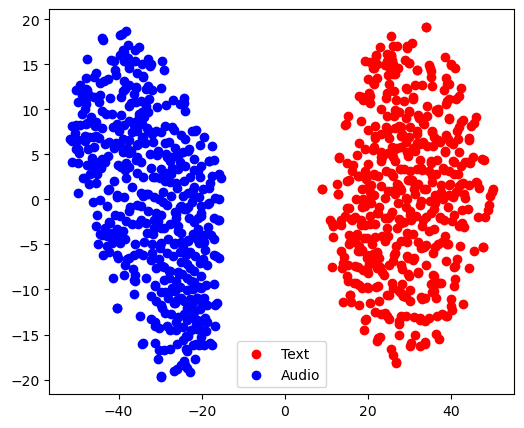

In [21]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# Set a seed so the randomness is reproducible
random.seed(0)

# Select 500 random pairs of text and audio embeddings
num_samples = 500
indices = random.sample(range(len(total_dataset_hubert_final['text'])), num_samples)
text_samples = [total_dataset_hubert_final['text'][i] for i in indices]
audio_samples = [total_dataset_hubert_final['audio'][i] for i in indices]

# Convert list of tensors to numpy arrays and stack them
text_embeddings = np.vstack([t.cpu().detach().numpy() for t in text_samples])
audio_embeddings = np.vstack([t.cpu().detach().numpy() for t in audio_samples])

# Perform t-SNE on combined embeddings
embeddings = np.concatenate((text_embeddings, audio_embeddings), axis=0)
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Split the transformed embeddings back out
text_tsne, audio_tsne = embeddings_tsne[:num_samples], embeddings_tsne[num_samples:]

# Create plot
plt.figure(figsize=(6, 5))

# Plot text embeddings
plt.scatter(text_tsne[:, 0], text_tsne[:, 1], color='r', label='Text')
# Plot audio embeddings
plt.scatter(audio_tsne[:, 0], audio_tsne[:, 1], color='b', label='Audio')

plt.legend()
plt.show()


In [24]:
def get_output_embeddings(model_path, dataloader):
    model = torch.load(model_path)
    model.eval()
    model = model.to(device)
    outputs = []

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (text_emb, audio_emb, image_emb) in pbar:
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)
            image_emb = image_emb.to(device)
            final_emb = model(audio_emb, image_emb)           

            outputs.append(final_emb)
    return outputs



In [25]:
class NewDataSet(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset['audio'])

    def __getitem__(self, i):
        return self.dataset['text'][i], self.dataset['audio'][i], self.dataset['image'][i]

In [29]:
dataset = total_dataset_hubert_final.copy()
test_loader = DataLoader(dataset= NewDataSet(dataset), batch_size=1, shuffle=False)
output_embeddings = get_output_embeddings('joint_model_translation_v2.pt',test_loader)

100%|██████████| 11411/11411 [00:13<00:00, 860.49it/s]


In [30]:
len(output_embeddings)

11411

In [34]:
output_embeddings = [t.squeeze(0) for t in output_embeddings]

In [35]:
output_embeddings[0].shape

torch.Size([768])

In [37]:
dataset['output-emb'] = output_embeddings

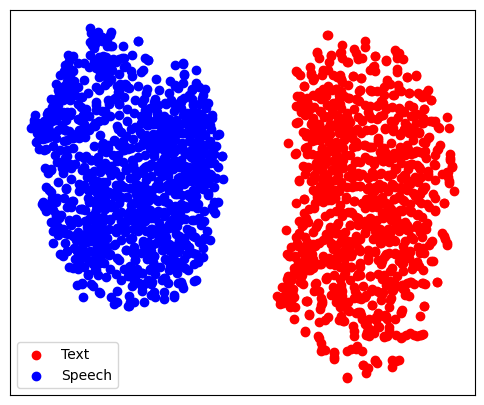

In [50]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# Set a seed so the randomness is reproducible
random.seed(0)

# Select 500 random pairs of text and audio embeddings
num_samples = 1000
indices = random.sample(range(len(dataset['text'])), num_samples)
text_samples = [dataset['text'][i] for i in indices]
audio_samples = [dataset['audio'][i] for i in indices]
output_samples = [dataset['output-emb'][i] for i in indices]

# Convert list of tensors to numpy arrays and stack them
text_embeddings = np.vstack([t.cpu().detach().numpy() for t in text_samples])
audio_embeddings = np.vstack([t.cpu().detach().numpy() for t in audio_samples])
output_embeddings = np.vstack([t.cpu().detach().numpy() for t in output_samples])


# Perform t-SNE on combined embeddings
embeddings = np.concatenate((text_embeddings, audio_embeddings), axis=0)
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Split the transformed embeddings back out
text_tsne, audio_tsne = embeddings_tsne[:num_samples], embeddings_tsne[num_samples:]

# Create plot
plt.figure(figsize=(6, 5))

# Plot text embeddings
plt.scatter(text_tsne[:, 0], text_tsne[:, 1], color='r', label='Text')
# Plot audio embeddings
plt.scatter(audio_tsne[:, 0], audio_tsne[:, 1], color='b', label='Speech')

plt.xticks([])
plt.yticks([])

plt.legend()

# Save the plot
plt.savefig('tsne_plot_text_speech.png')

plt.show()


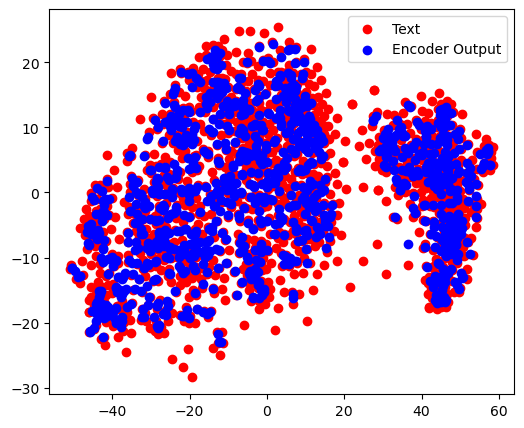

In [46]:
embeddings = np.concatenate((text_embeddings, output_embeddings), axis=0)
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Split the transformed embeddings back out
text_tsne, audio_tsne = embeddings_tsne[:num_samples], embeddings_tsne[num_samples:]

# Create plot
plt.figure(figsize=(6, 5))

# Plot text embeddings
plt.scatter(text_tsne[:, 0], text_tsne[:, 1], color='r', label='Text')
# Plot audio embeddings
plt.scatter(audio_tsne[:, 0], audio_tsne[:, 1], color='g', label='Encoder Output')

plt.legend()
plt.show()

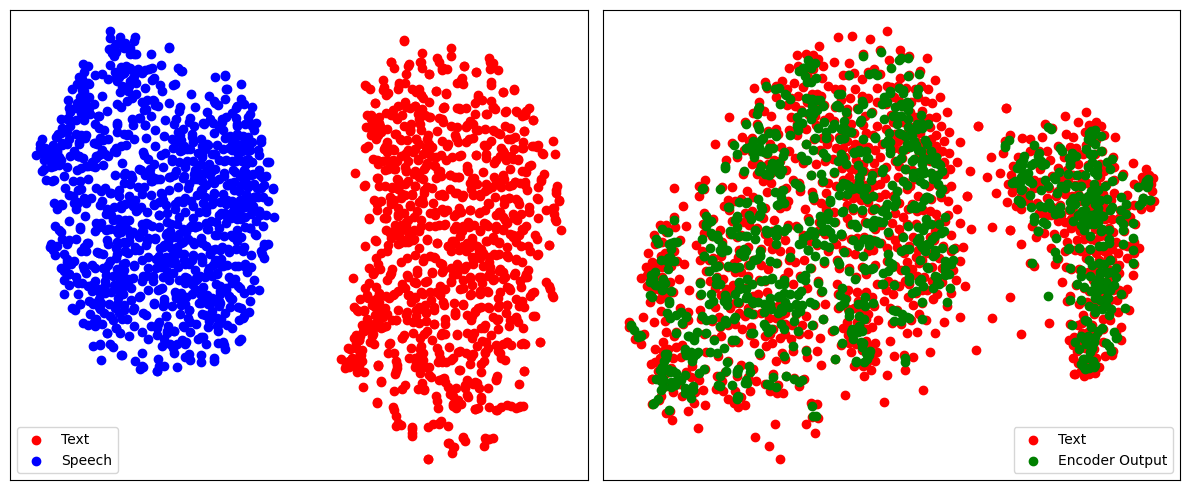

In [60]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# Set a seed so the randomness is reproducible
random.seed(0)

# Select 500 random pairs of text, audio, and output embeddings
num_samples = 1000
indices = random.sample(range(len(dataset['text'])), num_samples)
text_samples = [dataset['text'][i] for i in indices]
audio_samples = [dataset['audio'][i] for i in indices]
output_samples = [dataset['output-emb'][i] for i in indices]

# Convert list of tensors to numpy arrays and stack them
text_embeddings = np.vstack([t.cpu().detach().numpy() for t in text_samples])
audio_embeddings = np.vstack([t.cpu().detach().numpy() for t in audio_samples])
output_embeddings = np.vstack([t.cpu().detach().numpy() for t in output_samples])

# Create plot
plt.figure(figsize=(12, 5))

# Perform t-SNE on text and audio embeddings
embeddings = np.concatenate((text_embeddings, audio_embeddings), axis=0)
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Split the transformed embeddings back out
text_tsne, audio_tsne = embeddings_tsne[:num_samples], embeddings_tsne[num_samples:]

# Subplot 1: Text and Speech embeddings
plt.subplot(1, 2, 1)
plt.scatter(text_tsne[:, 0], text_tsne[:, 1], color='r', label='Text')
plt.scatter(audio_tsne[:, 0], audio_tsne[:, 1], color='b', label='Speech')
plt.xticks([])
plt.yticks([])
plt.legend()

# Perform t-SNE on text and output embeddings
embeddings = np.concatenate((text_embeddings, output_embeddings), axis=0)
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Split the transformed embeddings back out
text_tsne, output_tsne = embeddings_tsne[:num_samples], embeddings_tsne[num_samples:]

# Subplot 2: Text and Encoder Output embeddings
plt.subplot(1, 2, 2)
plt.scatter(text_tsne[:, 0], text_tsne[:, 1], color='r', label='Text')
plt.scatter(output_tsne[:, 0], output_tsne[:, 1], color='g', label='Encoder Output')
plt.xticks([])
plt.yticks([])
plt.legend(loc='lower right')

plt.tight_layout()

# Save the plot
plt.savefig('tsne_plot.png', bbox_inches='tight')

plt.show()


# Hubert ASR

In [6]:
url = "https://drive.google.com/file/d/1UChSPa_Uv6levN9pWN9jkNkBgkJWi6nL/view?usp=sharing"
output = "total_dataset_hubert_asr_v2.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UChSPa_Uv6levN9pWN9jkNkBgkJWi6nL
From (redirected): https://drive.google.com/uc?id=1UChSPa_Uv6levN9pWN9jkNkBgkJWi6nL&confirm=t&uuid=da50cd4f-98b3-4b62-a0aa-197b01446a56
To: /kaggle/working/total_dataset_hubert_asr_v2.pkl
100%|██████████| 1.50G/1.50G [00:27<00:00, 55.4MB/s]


'total_dataset_hubert_asr_v2.pkl'

In [7]:
with open('total_dataset_hubert_asr_v2.pkl', 'rb') as f:
    total_dataset_test_asr = pickle.load(f)

In [8]:
def evaluate_asr(dataloader, threshold=0.5):

    def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
        similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
        return similarity

    def cosine_similarity(embedding1, embedding2):
        dim = 1
        embedding1 = F.normalize(embedding1, p=2, dim=dim)
        embedding2 = F.normalize(embedding2, p=2, dim=dim)

        dot_product = torch.sum(embedding1 * embedding2, dim=dim)

        magnitude1 = torch.norm(embedding1, p=2, dim=dim)
        magnitude2 = torch.norm(embedding2, p=2, dim=dim)

        cosine_sim = dot_product / (magnitude1 * magnitude2)

        return cosine_sim
    
    def _evaluate(dataloader, threshold=0.5):
        total_hits_1 = 0
        total_mrr = 0
        total_instances = 0
        total_labels = []
        total_predictions = []
        number_of_golden_predictions = 0

        with torch.no_grad():
            for text_embedding, asr_embedding, label in tqdm(dataloader):
                label = label[0]
                text_embedding = text_embedding[0]
                asr_embedding = asr_embedding[0] 
                
                text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in asr_embedding]
                predicted_idx = np.argmax(text_candidate_cosine_similarities)
                
                label_similarity = text_candidate_cosine_similarities[label.item()]

                # Compute Hits@1
                if predicted_idx == label.item():   
                    total_hits_1 += 1

                # Compute MRR
                label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
                reciprocal_rank = 1 / (label_rank + 1)
                total_mrr += reciprocal_rank

                # Record predictions and labels
                predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
                total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
                total_predictions.extend(predictions)
                if label_similarity >= threshold:
                    number_of_golden_predictions += 1

                total_instances += 1

        # Compute average metrics over all instances
        avg_hits_1 = total_hits_1 / total_instances
        avg_mrr = total_mrr / total_instances
        precision = precision_score(total_labels, total_predictions, average='macro')
        recall = recall_score(total_labels, total_predictions, average='macro')
        f1 = f1_score(total_labels, total_predictions, average='macro')
        precision_micro = precision_score(total_labels, total_predictions, average='micro')
        recall_micro = recall_score(total_labels, total_predictions, average='micro')
        f1_micro = f1_score(total_labels, total_predictions, average='micro')
        accuracy = accuracy_score(total_labels, total_predictions)
        golden_prediction_accuracy = number_of_golden_predictions / total_instances

        return {
            'Hits@1': avg_hits_1,
            'MRR': avg_mrr,
            'Macro Precision': precision,
            'Macro Recall': recall,
            'Macro F1': f1,
            'Micro Precision': precision_micro,
            'Micro Recall': recall_micro,
            'Micro F1': f1_micro,
            'Accuracy': accuracy,
            'Golden Accuracy': golden_prediction_accuracy,
        }
    
    results = _evaluate(dataloader, threshold=threshold)
    table = []
    for i in range(len(results)):
        table.append([list(results.keys())[i], list(results.values())[i]])
    print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))


In [17]:
test_len_data = len(total_dataset_test_asr['text'])

number_of_candidates_per_sample = 10
test_metadata = []
random.seed(42)

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata.append(candidate_indexes)
len(test_metadata)

11411

In [ ]:
from sentence_transformers import SentenceTransformer

text_model = SentenceTransformer('sentence-transformers/LaBSE').to(device)

In [11]:
embeddings = text_model.encode(total_dataset_test_asr['hubert-asr-text'])
total_dataset_test_asr['hubert-asr-emb'] = [torch.from_numpy(emb) for emb in embeddings]

Batches:   0%|          | 0/357 [00:00<?, ?it/s]

In [18]:
class TestDatasetASR(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['text'][index]
        asr_embedding = [self.data['hubert-asr-emb'][i] for i in candidate_indexes]
        label_index = len(candidate_indexes) - 1
        asr_embedding = torch.stack(asr_embedding)

        return text_embedding, asr_embedding, label_index

In [19]:
#10
test_dataset = TestDatasetASR(total_dataset_test_asr, test_metadata)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 11411/11411 [00:13<00:00, 830.93it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.996319 |
+-----------------+----------+
| MRR             | 0.99772  |
+-----------------+----------+
| Macro Precision | 0.986349 |
+-----------------+----------+
| Macro Recall    | 0.991456 |
+-----------------+----------+
| Macro F1        | 0.988885 |
+-----------------+----------+
| Micro Precision | 0.995978 |
+-----------------+----------+
| Micro Recall    | 0.995978 |
+-----------------+----------+
| Micro F1        | 0.995978 |
+-----------------+----------+
| Accuracy        | 0.995978 |
+-----------------+----------+
| Golden Accuracy | 0.985803 |
+-----------------+----------+


In [15]:
test_dataset = TestDatasetASR(total_dataset_test_asr, test_metadata)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 11411/11411 [00:07<00:00, 1551.31it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.997196 |
+-----------------+----------+
| MRR             | 0.998437 |
+-----------------+----------+
| Macro Precision | 0.992427 |
+-----------------+----------+
| Macro Recall    | 0.991456 |
+-----------------+----------+
| Macro F1        | 0.991941 |
+-----------------+----------+
| Micro Precision | 0.994847 |
+-----------------+----------+
| Micro Recall    | 0.994847 |
+-----------------+----------+
| Micro F1        | 0.994847 |
+-----------------+----------+
| Accuracy        | 0.994847 |
+-----------------+----------+
| Golden Accuracy | 0.985803 |
+-----------------+----------+


# LibriSpeech Zero-Shot Eval

In [5]:
url = "https://drive.google.com/file/d/1MEzjk1xmXGnfbQZOxHgylvBCzgMqRFVr/view?usp=sharing"
output = "librispeech-test-clean_v2.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1MEzjk1xmXGnfbQZOxHgylvBCzgMqRFVr
To: /kaggle/working/librispeech-test-clean_v2.pkl
100%|██████████| 29.9M/29.9M [00:01<00:00, 15.3MB/s]


'librispeech-test-clean_v2.pkl'

In [15]:
with open('librispeech-test-clean_v2.pkl', 'rb') as f:
    librispeech_test_clean = pickle.load(f)

In [41]:
test_len_data = len(librispeech_test_clean['labse-emb'])

number_of_candidates_per_sample = 5
test_metadata_clean = []

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata_clean.append(candidate_indexes)
len(test_metadata_clean)    

2620

In [17]:
total_audio_embeddings = torch.stack(librispeech_test_clean['audio-emb'])
total_image_embeddings = torch.stack(librispeech_test_clean['image-emb'])
total_text_embeddings = torch.stack(librispeech_test_clean['labse-emb'])

# normalizer each embedding tensor
print(total_image_embeddings.shape)
total_audio_embeddings = F.normalize(total_audio_embeddings, dim=1)
total_text_embeddings = F.normalize(total_text_embeddings, dim=1)
total_image_embeddings = F.normalize(total_image_embeddings, dim=1)

librispeech_test_clean['audio-emb'] = total_audio_embeddings
librispeech_test_clean['labse-emb'] = total_text_embeddings
librispeech_test_clean['image-emb'] = total_image_embeddings

torch.Size([2620, 1000])


In [18]:
class TestDataset(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['labse-emb'][index]
        audio_embeddings = [self.data['audio-emb'][i] for i in candidate_indexes]
        image_embeddings = [self.data['image-emb'][i] for i in candidate_indexes]
        label_index = len(candidate_indexes) - 1
        audio_embeddings = torch.stack(audio_embeddings)
        image_embeddings = torch.stack(image_embeddings)

        return text_embedding, audio_embeddings, image_embeddings, label_index

In [19]:
def evaluate(model_path, mode='joint', threshold=0.5):
    model = torch.load(model_path)
    model.eval()
    model = model.to(device)

    def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
        similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
        return similarity

    def cosine_similarity(embedding1, embedding2):
        dim = 1
        embedding1 = F.normalize(embedding1, p=2, dim=dim)
        embedding2 = F.normalize(embedding2, p=2, dim=dim)

        dot_product = torch.sum(embedding1 * embedding2, dim=dim)

        magnitude1 = torch.norm(embedding1, p=2, dim=dim)
        magnitude2 = torch.norm(embedding2, p=2, dim=dim)

        cosine_sim = dot_product / (magnitude1 * magnitude2)

        return cosine_sim
    
    def _evaluate(model, dataloader, threshold=0.5, mode='joint'):
        total_hits_1 = 0
        total_mrr = 0
        total_instances = 0
        total_labels = []
        total_predictions = []
        number_of_golden_predictions = 0

        with torch.no_grad():
            for text_embedding, audio_candidates, image_candidates, label in tqdm(dataloader):
                label = label[0]
                text_embedding = text_embedding[0].to(device)
                label = label.to(device)

                if mode == 'joint':   
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(audio_candidates, image_candidates)
                elif mode == 'audio':
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    final_embs = model(audio_candidates)
                elif mode == 'image':
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(image_candidates)    
                
                text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in final_embs]
                predicted_idx = np.argmax(text_candidate_cosine_similarities)
                
                label_similarity = text_candidate_cosine_similarities[label.item()]

                # Compute Hits@1
                if predicted_idx == label.item():   
                    total_hits_1 += 1

                # Compute MRR
                label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
                reciprocal_rank = 1 / (label_rank + 1)
                total_mrr += reciprocal_rank

                # Record predictions and labels
                predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
                total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
                total_predictions.extend(predictions)
                if label_similarity >= threshold:
                    number_of_golden_predictions += 1

                total_instances += 1

        # Compute average metrics over all instances
        avg_hits_1 = total_hits_1 / total_instances
        avg_mrr = total_mrr / total_instances
        precision = precision_score(total_labels, total_predictions, average='macro')
        recall = recall_score(total_labels, total_predictions, average='macro')
        f1 = f1_score(total_labels, total_predictions, average='macro')
        precision_micro = precision_score(total_labels, total_predictions, average='micro')
        recall_micro = recall_score(total_labels, total_predictions, average='micro')
        f1_micro = f1_score(total_labels, total_predictions, average='micro')
        accuracy = accuracy_score(total_labels, total_predictions)
        golden_prediction_accuracy = number_of_golden_predictions / total_instances

        return {
            'Hits@1': avg_hits_1,
            'MRR': avg_mrr,
            'Macro Precision': precision,
            'Macro Recall': recall,
            'Macro F1': f1,
            'Micro Precision': precision_micro,
            'Micro Recall': recall_micro,
            'Micro F1': f1_micro,
            'Accuracy': accuracy,
            'Golden Accuracy': golden_prediction_accuracy,
        }
    
    results = _evaluate(model, test_final_loader, threshold=threshold, mode=mode)
    table = []
    for i in range(len(results)):
        table.append([list(results.keys())[i], list(results.values())[i]])
    print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))


In [20]:
test_dataset = TestDataset(librispeech_test_clean, test_metadata_clean)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate('joint_model_translation_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 2620/2620 [00:07<00:00, 342.78it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.951908 |
+-----------------+----------+
| MRR             | 0.974377 |
+-----------------+----------+
| Macro Precision | 0.818697 |
+-----------------+----------+
| Macro Recall    | 0.893989 |
+-----------------+----------+
| Macro F1        | 0.846315 |
+-----------------+----------+
| Micro Precision | 0.889237 |
+-----------------+----------+
| Micro Recall    | 0.889237 |
+-----------------+----------+
| Micro F1        | 0.889237 |
+-----------------+----------+
| Accuracy        | 0.889237 |
+-----------------+----------+
| Golden Accuracy | 0.901908 |
+-----------------+----------+


In [26]:
evaluate('gating_model_v3.pt', mode='joint', threshold=0.4)

100%|██████████| 2620/2620 [00:07<00:00, 349.52it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.953435 |
+-----------------+----------+
| MRR             | 0.975668 |
+-----------------+----------+
| Macro Precision | 0.815923 |
+-----------------+----------+
| Macro Recall    | 0.77209  |
+-----------------+----------+
| Macro F1        | 0.79075  |
+-----------------+----------+
| Micro Precision | 0.875115 |
+-----------------+----------+
| Micro Recall    | 0.875115 |
+-----------------+----------+
| Micro F1        | 0.875115 |
+-----------------+----------+
| Accuracy        | 0.875115 |
+-----------------+----------+
| Golden Accuracy | 0.600382 |
+-----------------+----------+


In [14]:
url = "https://drive.google.com/file/d/1-9e0p--1tRmGheB5LF99E0yDTcDogVqp/view?usp=sharing"
output = "librispeech-test-other_v2.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1-9e0p--1tRmGheB5LF99E0yDTcDogVqp
To: /kaggle/working/librispeech-test-other_v2.pkl
100%|██████████| 33.4M/33.4M [00:00<00:00, 83.6MB/s]


'librispeech-test-other_v2.pkl'

In [42]:
with open('librispeech-test-other_v2.pkl', 'rb') as f:
    librispeech_test_other = pickle.load(f)


test_len_data = len(librispeech_test_other['labse-emb'])
number_of_candidates_per_sample = 5
test_metadata_other = []

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata_other.append(candidate_indexes)
len(test_metadata_other)   

2939

In [28]:
total_audio_embeddings = torch.stack(librispeech_test_other['audio-emb'])
total_image_embeddings = torch.stack(librispeech_test_other['image-emb'])
total_text_embeddings = torch.stack(librispeech_test_other['labse-emb'])

# normalizer each embedding tensor
print(total_image_embeddings.shape)
total_audio_embeddings = F.normalize(total_audio_embeddings, dim=1)
total_text_embeddings = F.normalize(total_text_embeddings, dim=1)
total_image_embeddings = F.normalize(total_image_embeddings, dim=1)

librispeech_test_other['audio-emb'] = total_audio_embeddings
librispeech_test_other['labse-emb'] = total_text_embeddings
librispeech_test_other['image-emb'] = total_image_embeddings

torch.Size([2939, 1000])


In [29]:
test_dataset = TestDataset(librispeech_test_other, test_metadata_other)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate('joint_model_translation_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 2939/2939 [00:07<00:00, 370.07it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.941817 |
+-----------------+----------+
| MRR             | 0.969128 |
+-----------------+----------+
| Macro Precision | 0.783453 |
+-----------------+----------+
| Macro Recall    | 0.868493 |
+-----------------+----------+
| Macro F1        | 0.810474 |
+-----------------+----------+
| Micro Precision | 0.858796 |
+-----------------+----------+
| Micro Recall    | 0.858796 |
+-----------------+----------+
| Micro F1        | 0.858796 |
+-----------------+----------+
| Accuracy        | 0.858796 |
+-----------------+----------+
| Golden Accuracy | 0.884655 |
+-----------------+----------+


In [30]:
evaluate('gating_model_v3.pt', mode='joint', threshold=0.4)

100%|██████████| 2939/2939 [00:09<00:00, 322.89it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.9459   |
+-----------------+----------+
| MRR             | 0.971544 |
+-----------------+----------+
| Macro Precision | 0.791937 |
+-----------------+----------+
| Macro Recall    | 0.754891 |
+-----------------+----------+
| Macro F1        | 0.770832 |
+-----------------+----------+
| Micro Precision | 0.862402 |
+-----------------+----------+
| Micro Recall    | 0.862402 |
+-----------------+----------+
| Micro F1        | 0.862402 |
+-----------------+----------+
| Accuracy        | 0.862402 |
+-----------------+----------+
| Golden Accuracy | 0.575706 |
+-----------------+----------+


In [31]:
def evaluate_asr(dataloader, threshold=0.5):

    def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
        similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
        return similarity

    def cosine_similarity(embedding1, embedding2):
        dim = 1
        embedding1 = F.normalize(embedding1, p=2, dim=dim)
        embedding2 = F.normalize(embedding2, p=2, dim=dim)

        dot_product = torch.sum(embedding1 * embedding2, dim=dim)

        magnitude1 = torch.norm(embedding1, p=2, dim=dim)
        magnitude2 = torch.norm(embedding2, p=2, dim=dim)

        cosine_sim = dot_product / (magnitude1 * magnitude2)

        return cosine_sim
    
    def _evaluate(dataloader, threshold=0.5):
        total_hits_1 = 0
        total_mrr = 0
        total_instances = 0
        total_labels = []
        total_predictions = []
        number_of_golden_predictions = 0

        with torch.no_grad():
            for text_embedding, asr_embedding, label in tqdm(dataloader):
                label = label[0]
                text_embedding = text_embedding[0]
                asr_embedding = asr_embedding[0] 
                
                text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in asr_embedding]
                predicted_idx = np.argmax(text_candidate_cosine_similarities)
                
                label_similarity = text_candidate_cosine_similarities[label.item()]

                # Compute Hits@1
                if predicted_idx == label.item():   
                    total_hits_1 += 1

                # Compute MRR
                label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
                reciprocal_rank = 1 / (label_rank + 1)
                total_mrr += reciprocal_rank

                # Record predictions and labels
                predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
                total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
                total_predictions.extend(predictions)
                if label_similarity >= threshold:
                    number_of_golden_predictions += 1

                total_instances += 1

        # Compute average metrics over all instances
        avg_hits_1 = total_hits_1 / total_instances
        avg_mrr = total_mrr / total_instances
        precision = precision_score(total_labels, total_predictions, average='macro')
        recall = recall_score(total_labels, total_predictions, average='macro')
        f1 = f1_score(total_labels, total_predictions, average='macro')
        precision_micro = precision_score(total_labels, total_predictions, average='micro')
        recall_micro = recall_score(total_labels, total_predictions, average='micro')
        f1_micro = f1_score(total_labels, total_predictions, average='micro')
        accuracy = accuracy_score(total_labels, total_predictions)
        golden_prediction_accuracy = number_of_golden_predictions / total_instances

        return {
            'Hits@1': avg_hits_1,
            'MRR': avg_mrr,
            'Macro Precision': precision,
            'Macro Recall': recall,
            'Macro F1': f1,
            'Micro Precision': precision_micro,
            'Micro Recall': recall_micro,
            'Micro F1': f1_micro,
            'Accuracy': accuracy,
            'Golden Accuracy': golden_prediction_accuracy,
        }
    
    results = _evaluate(dataloader, threshold=threshold)
    table = []
    for i in range(len(results)):
        table.append([list(results.keys())[i], list(results.values())[i]])
    print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))


In [ ]:
from sentence_transformers import SentenceTransformer

text_model = SentenceTransformer('sentence-transformers/LaBSE').to(device)

In [33]:
embeddings = text_model.encode(librispeech_test_clean['hubert-asr'])
librispeech_test_clean['hubert-asr-emb'] = [torch.from_numpy(emb) for emb in embeddings]

embeddings = text_model.encode(librispeech_test_clean['wav2vec2-asr'])
librispeech_test_clean['wav2vec2-asr-emb'] = [torch.from_numpy(emb) for emb in embeddings]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

In [34]:
class HubertDataset(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['labse-emb'][index]
        asr_embedding = [self.data['hubert-asr-emb'][i] for i in candidate_indexes]
        label_index = len(candidate_indexes) - 1
        asr_embedding = torch.stack(asr_embedding)

        return text_embedding, asr_embedding, label_index

In [35]:
class Wav2vec2Dataset(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['labse-emb'][index]
        asr_embedding = [self.data['wav2vec2-asr-emb'][i] for i in candidate_indexes]
        label_index = len(candidate_indexes) - 1
        asr_embedding = torch.stack(asr_embedding)

        return text_embedding, asr_embedding, label_index

In [43]:
test_dataset = Wav2vec2Dataset(librispeech_test_clean, test_metadata_clean)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 2620/2620 [00:01<00:00, 1457.50it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 1        |
+-----------------+----------+
| MRR             | 1        |
+-----------------+----------+
| Macro Precision | 0.987686 |
+-----------------+----------+
| Macro Recall    | 0.996135 |
+-----------------+----------+
| Macro F1        | 0.991841 |
+-----------------+----------+
| Micro Precision | 0.994733 |
+-----------------+----------+
| Micro Recall    | 0.994733 |
+-----------------+----------+
| Micro F1        | 0.994733 |
+-----------------+----------+
| Accuracy        | 0.994733 |
+-----------------+----------+
| Golden Accuracy | 0.998473 |
+-----------------+----------+


In [37]:
test_dataset = HubertDataset(librispeech_test_clean, test_metadata_clean)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 2620/2620 [00:01<00:00, 1480.58it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 1        |
+-----------------+----------+
| MRR             | 1        |
+-----------------+----------+
| Macro Precision | 0.987504 |
+-----------------+----------+
| Macro Recall    | 0.996088 |
+-----------------+----------+
| Macro F1        | 0.991724 |
+-----------------+----------+
| Micro Precision | 0.994656 |
+-----------------+----------+
| Micro Recall    | 0.994656 |
+-----------------+----------+
| Micro F1        | 0.994656 |
+-----------------+----------+
| Accuracy        | 0.994656 |
+-----------------+----------+
| Golden Accuracy | 0.998473 |
+-----------------+----------+


In [38]:
embeddings = text_model.encode(librispeech_test_other['hubert-asr'])
librispeech_test_other['hubert-asr-emb'] = [torch.from_numpy(emb) for emb in embeddings]

embeddings = text_model.encode(librispeech_test_other['wav2vec2-asr'])
librispeech_test_other['wav2vec2-asr-emb'] = [torch.from_numpy(emb) for emb in embeddings]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

In [39]:
test_dataset = Wav2vec2Dataset(librispeech_test_other, test_metadata_other)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 2939/2939 [00:02<00:00, 1356.96it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.99966  |
+-----------------+----------+
| MRR             | 0.99983  |
+-----------------+----------+
| Macro Precision | 0.98665  |
+-----------------+----------+
| Macro Recall    | 0.995151 |
+-----------------+----------+
| Macro F1        | 0.99083  |
+-----------------+----------+
| Micro Precision | 0.99408  |
+-----------------+----------+
| Micro Recall    | 0.99408  |
+-----------------+----------+
| Micro F1        | 0.99408  |
+-----------------+----------+
| Accuracy        | 0.99408  |
+-----------------+----------+
| Golden Accuracy | 0.996938 |
+-----------------+----------+


In [40]:
test_dataset = HubertDataset(librispeech_test_other, test_metadata_other)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate_asr(test_final_loader, threshold=0.4)

100%|██████████| 2939/2939 [00:02<00:00, 1447.93it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 1        |
+-----------------+----------+
| MRR             | 1        |
+-----------------+----------+
| Macro Precision | 0.986059 |
+-----------------+----------+
| Macro Recall    | 0.996257 |
+-----------------+----------+
| Macro F1        | 0.991056 |
+-----------------+----------+
| Micro Precision | 0.994216 |
+-----------------+----------+
| Micro Recall    | 0.994216 |
+-----------------+----------+
| Micro F1        | 0.994216 |
+-----------------+----------+
| Accuracy        | 0.994216 |
+-----------------+----------+
| Golden Accuracy | 0.99966  |
+-----------------+----------+


In [1]:
from IPython.display import FileLink 
FileLink('gating_model_v3.pt')

/kaggle/working/gating_model_v3.pt

In [2]:
FileLink('joint_model_translation_v2.pt')

/kaggle/working/joint_model_translation_v2.pt

# VoxPopuli Dataset Zero-Shot

In [5]:
url = "https://drive.google.com/file/d/1X9R2RUkka2mMHv4DNTDisYp4FAHG30Ia/view?usp=sharing"
output = "voxpopuli_test_v3.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1X9R2RUkka2mMHv4DNTDisYp4FAHG30Ia
To: /kaggle/working/voxpopuli_test_v3.pkl
100%|██████████| 26.0M/26.0M [00:00<00:00, 65.2MB/s]


'voxpopuli_test_v3.pkl'

In [37]:
with open(f'voxpopuli_test_v3.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [38]:
total_audio_embeddings = torch.stack(dataset['audio-emb-v2'])

# normalizer each embedding tensor
total_audio_embeddings = F.normalize(total_audio_embeddings, dim=1)

dataset['audio-emb-v2'] = total_audio_embeddings

In [39]:
# normalizer each embedding tensor
total_image_embeddings = F.normalize(dataset['image-emb'], dim=1)

dataset['image-emb'] = total_image_embeddings

In [40]:
# normalizer each embedding tensor
total_labse_embeddings = F.normalize(dataset['labse-emb'], dim=1)

dataset['labse-emb'] = total_labse_embeddings

In [41]:
class TestDataset(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['labse-emb'][index]
        audio_embeddings = [self.data['audio-emb-v2'][i] for i in candidate_indexes]
        image_embeddings = [self.data['image-emb'][i] for i in candidate_indexes]
        label_index = len(candidate_indexes) - 1
        audio_embeddings = torch.stack(audio_embeddings)
        image_embeddings = torch.stack(image_embeddings)

        return text_embedding, audio_embeddings, image_embeddings, label_index

In [42]:
def evaluate(model_path, mode='joint', threshold=0.5):
    model = torch.load(model_path)
    model.eval()
    model = model.to(device)

    def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
        similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
        return similarity

    def cosine_similarity(embedding1, embedding2):
        dim = 1
        embedding1 = F.normalize(embedding1, p=2, dim=dim)
        embedding2 = F.normalize(embedding2, p=2, dim=dim)

        dot_product = torch.sum(embedding1 * embedding2, dim=dim)

        magnitude1 = torch.norm(embedding1, p=2, dim=dim)
        magnitude2 = torch.norm(embedding2, p=2, dim=dim)

        cosine_sim = dot_product / (magnitude1 * magnitude2)

        return cosine_sim
    
    def _evaluate(model, dataloader, threshold=0.5, mode='joint'):
        total_hits_1 = 0
        total_mrr = 0
        total_instances = 0
        total_labels = []
        total_predictions = []
        number_of_golden_predictions = 0

        with torch.no_grad():
            for text_embedding, audio_candidates, image_candidates, label in tqdm(dataloader):
                label = label[0]
                text_embedding = text_embedding[0].to(device)
                label = label.to(device)

                if mode == 'joint':   
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(audio_candidates, image_candidates)
                elif mode == 'audio':
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    final_embs = model(audio_candidates)
                elif mode == 'image':
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(image_candidates)    
                
                text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in final_embs]
                predicted_idx = np.argmax(text_candidate_cosine_similarities)
                
                label_similarity = text_candidate_cosine_similarities[label.item()]

                # Compute Hits@1
                if predicted_idx == label.item():   
                    total_hits_1 += 1

                # Compute MRR
                label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
                reciprocal_rank = 1 / (label_rank + 1)
                total_mrr += reciprocal_rank

                # Record predictions and labels
                predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
                total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
                total_predictions.extend(predictions)
                if label_similarity >= threshold:
                    number_of_golden_predictions += 1

                total_instances += 1

        # Compute average metrics over all instances
        avg_hits_1 = total_hits_1 / total_instances
        avg_mrr = total_mrr / total_instances
        precision = precision_score(total_labels, total_predictions, average='macro')
        recall = recall_score(total_labels, total_predictions, average='macro')
        f1 = f1_score(total_labels, total_predictions, average='macro')
        precision_micro = precision_score(total_labels, total_predictions, average='micro')
        recall_micro = recall_score(total_labels, total_predictions, average='micro')
        f1_micro = f1_score(total_labels, total_predictions, average='micro')
        accuracy = accuracy_score(total_labels, total_predictions)
        golden_prediction_accuracy = number_of_golden_predictions / total_instances

        return {
            'Hits@1': avg_hits_1,
            'MRR': avg_mrr,
            'Macro Precision': precision,
            'Macro Recall': recall,
            'Macro F1': f1,
            'Micro Precision': precision_micro,
            'Micro Recall': recall_micro,
            'Micro F1': f1_micro,
            'Accuracy': accuracy,
            'Golden Accuracy': golden_prediction_accuracy,
        }
    
    results = _evaluate(model, test_final_loader, threshold=threshold, mode=mode)
    table = []
    for i in range(len(results)):
        table.append([list(results.keys())[i], list(results.values())[i]])
    print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))


In [59]:
test_len_data = len(dataset['labse-emb'])

number_of_candidates_per_sample = 5
test_metadata_clean = []

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata_clean.append(candidate_indexes)
len(test_metadata_clean)    

1842

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

test_len_data = len(dataset['labse-emb'])
number_of_candidates_per_sample = 5
test_metadata_clean = []

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(dataset['labse-emb'])

for index in range(test_len_data):
    # Get the similarity scores for the current sample
    similarity_scores = similarity_matrix[index]
    
    # Get the indexes of the samples sorted by their similarity scores
    sorted_indexes = np.argsort(similarity_scores)
    
    # Select the indexes of the 4 least similar candidates
    candidate_indexes = sorted_indexes[:number_of_candidates_per_sample - 1].tolist()
    
    # Add the index of the current sample
    candidate_indexes += [index]
    
    test_metadata_clean.append(candidate_indexes)

len(test_metadata_clean)


1842

In [60]:
test_dataset = TestDataset(dataset, test_metadata_clean)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate('joint_model_translation_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 1842/1842 [00:05<00:00, 358.77it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.834419 |
+-----------------+----------+
| MRR             | 0.907401 |
+-----------------+----------+
| Macro Precision | 0.799362 |
+-----------------+----------+
| Macro Recall    | 0.750136 |
+-----------------+----------+
| Macro F1        | 0.770335 |
+-----------------+----------+
| Micro Precision | 0.864712 |
+-----------------+----------+
| Micro Recall    | 0.864712 |
+-----------------+----------+
| Micro F1        | 0.864712 |
+-----------------+----------+
| Accuracy        | 0.864712 |
+-----------------+----------+
| Golden Accuracy | 0.559175 |
+-----------------+----------+


In [57]:
test_dataset = TestDataset(dataset, test_metadata_clean)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
evaluate('joint_model_translation_v2.pt', mode='joint', threshold=0.4)

100%|██████████| 1842/1842 [00:04<00:00, 430.46it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.961998 |
+-----------------+----------+
| MRR             | 0.978764 |
+-----------------+----------+
| Macro Precision | 0.913841 |
+-----------------+----------+
| Macro Recall    | 0.774159 |
+-----------------+----------+
| Macro F1        | 0.820082 |
+-----------------+----------+
| Micro Precision | 0.903149 |
+-----------------+----------+
| Micro Recall    | 0.903149 |
+-----------------+----------+
| Micro F1        | 0.903149 |
+-----------------+----------+
| Accuracy        | 0.903149 |
+-----------------+----------+
| Golden Accuracy | 0.559175 |
+-----------------+----------+


In [58]:
evaluate('gating_model_v3.pt', mode='joint', threshold=0.36)

100%|██████████| 1842/1842 [00:04<00:00, 368.61it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.965798 |
+-----------------+----------+
| MRR             | 0.981098 |
+-----------------+----------+
| Macro Precision | 0.833892 |
+-----------------+----------+
| Macro Recall    | 0.702158 |
+-----------------+----------+
| Macro F1        | 0.739831 |
+-----------------+----------+
| Micro Precision | 0.864169 |
+-----------------+----------+
| Micro Recall    | 0.864169 |
+-----------------+----------+
| Micro F1        | 0.864169 |
+-----------------+----------+
| Accuracy        | 0.864169 |
+-----------------+----------+
| Golden Accuracy | 0.432139 |
+-----------------+----------+


In [45]:
evaluate('gating_model_v3.pt', mode='joint', threshold=0.35)

100%|██████████| 1842/1842 [00:04<00:00, 398.95it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.847448 |
+-----------------+----------+
| MRR             | 0.913871 |
+-----------------+----------+
| Macro Precision | 0.701035 |
+-----------------+----------+
| Macro Recall    | 0.694897 |
+-----------------+----------+
| Macro F1        | 0.697847 |
+-----------------+----------+
| Micro Precision | 0.809555 |
+-----------------+----------+
| Micro Recall    | 0.809555 |
+-----------------+----------+
| Micro F1        | 0.809555 |
+-----------------+----------+
| Accuracy        | 0.809555 |
+-----------------+----------+
| Golden Accuracy | 0.5038   |
+-----------------+----------+


In [53]:
evaluate('gating_model_v3.pt', mode='joint', threshold=0.36)

100%|██████████| 1842/1842 [00:04<00:00, 373.70it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.847448 |
+-----------------+----------+
| MRR             | 0.913871 |
+-----------------+----------+
| Macro Precision | 0.73033  |
+-----------------+----------+
| Macro Recall    | 0.679085 |
+-----------------+----------+
| Macro F1        | 0.69787  |
+-----------------+----------+
| Micro Precision | 0.827253 |
+-----------------+----------+
| Micro Recall    | 0.827253 |
+-----------------+----------+
| Micro F1        | 0.827253 |
+-----------------+----------+
| Accuracy        | 0.827253 |
+-----------------+----------+
| Golden Accuracy | 0.432139 |
+-----------------+----------+
